In [1]:
%load_ext autoreload
%autoreload 2

# Introduction

This is a template code with instructions on how to create and use the GNN model.   
This notebook skeleton uses train and validation as the input.  
But the labelling is test (since there is only two datasets).

For code without the instructions, look at `00_05_barebones_train_val.ipynb`  

**INFO**  
To do the final model run (i.e. happy with tuning and config), refer to `00_05_test_model.ipynb` for training a final model and obtaining the metrics on the test set. It is also possible to simply "hack" the test set here by setting the `user_split` argument to train test only

# Google colab init and imports

In [164]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [165]:
import os

folder_path = '/content/drive/My Drive/dl project self/GNN_recommender_system-vik_dev'
os.chdir(folder_path)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /content/drive/My Drive/dl project self/GNN_recommender_system-vik_dev


In [103]:
!pip install torch_geometric

In [166]:
import pandas as pd
import numpy as np
import torch

from utils.setup_nodes import create_edge_lists
from utils.graph_helpers import train_model, plot_train_val_loss, final_evaluation
from utils.graph_model import GAT_model, GATv2_model
from utils.general import seed_everything
from utils.predictions import recommend_products, pretty_print_recomendations, get_top_k_preds

# Set seed

In [105]:
seed_everything()

# Set variables

1. `user_split` is either `train_test_valid` or `train_test`
2. `prod_embed_name` is the name of the embeddings to be used for product
3. `user_embed_name` is the name of the embeddings to be used for user (note the files will be preprended with train/test/split)
4. `*_dir` is the respective file paths
5. `device` cuda or cpu depending on your machine
6. `*_cols` the cols to load from the dataframes (change if you need to change the features)
7. `fill_users` the method to fill up the new user data (zero or mean)

In [106]:
user_split = "train_test_valid"
prod_embed_name = "meta_features_512"
user_embed_name = "user_reviews_features_512"

data_dir = "data"
product_dir = "full_data"
embedding_dir = "embedding"

device = "cuda"

product_cols = ["parent_asin", "average_rating", "rating_number"]
user_cols = ["user_id", "rating_mean", "rating_count", "helpful_vote_mean", "helpful_vote_gte_1", "verified_purchase_mean", "last_active_in_days_min",
            "last_active_in_days_max", "word_count_mean"]
edge_cols = ["user_id", "parent_asin", "rating"]

fill_users = "zero"

# Load data

Take special attention to what is being loaded as a the test set.  
Remember if you want test data, set the value of `user_split` to `train_test` in the previous cell

Also, I am limiting the number of columns being read in. So edit accordingly to what colum values are needed for the current set up

If there is more than 1 tensor for the embedding, sugesstion is to do a torch.cat into a single longer tensor first and then carry it on to the next step. So load under different name then join it back to as product_emebdding, train_user_embedding and test_user_embedding

In [107]:
product_df = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = product_cols)
train_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/train_agg.parquet", columns = user_cols)
train_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/train.parquet", columns = edge_cols)

if user_split == "train_test_valid":
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/valid_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/valid.parquet", columns = edge_cols)
else:
    test_user_df = pd.read_parquet(f"{data_dir}/{user_split}_split/test_agg.parquet", columns = user_cols)
    test_user_edges = pd.read_parquet(f"{data_dir}/{user_split}_split/test.parquet", columns = edge_cols)


In [108]:
product_embedding = torch.load(f"{data_dir}/{embedding_dir}/product/{prod_embed_name}.pt")
train_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/train_{user_embed_name}.pt")
if user_split == "train_test_valid":
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/valid_{user_embed_name}.pt")
else:
    test_user_embedding = torch.load(f"{data_dir}/{embedding_dir}/{user_split}_split/test_{user_embed_name}.pt")

# Make nodes

We need to do a few things
1. Make a super user df - so that all the nodes are inside the graph and the idx would be correct later
2. Set up an index mapping from ids to idx (note that the product index need to be offeset)
3. Concat information to form the product nodes
4. Concat information to form the user nodes - only for the train users, test users need to init as something if they dont exist in train (maybe zero or mean)
5. Create edge list for train and test (using the idx)

For product nodes, we assume the df has information, less the ids. If there is no information, then change the creation accordingly  

For the user nodes, for users in test but not in train, the current method is to user zero.  
There is also a flag to fill with mean instead

In [109]:
# Add the embedding
train_user_df["embedding"] = list(train_user_embedding.numpy())
test_user_df["embedding"] = list(test_user_embedding.numpy())

# Concat user nodes
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()

## these are users that need to be zero-ed out
additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
additional_test_users["embedding"] = list(torch.zeros((len(additional_test_users), test_user_embedding.shape[1])).numpy())
if fill_users == "zero":
    additional_test_users.iloc[:, 1:-1] = 0
elif fill_users == "mean":
    additional_test_users.iloc[:, 1:-1] = train_user_df.iloc[:, 1:].mean()

# Make super user df
user_df = pd.concat([train_user_df, additional_test_users])

In [110]:
# Set up id mapping
offset = user_df.user_id.nunique()
user_id_to_idx = {unique_id : idx for idx, unique_id in enumerate(user_df.user_id.unique())}
prod_id_to_idx = {unique_id : offset + idx for idx, unique_id in enumerate(product_df.parent_asin.unique())}

# Add to df
product_df["prod_idx"] = product_df.parent_asin.apply(lambda x: prod_id_to_idx[x])
train_user_edges["user_idx"] = train_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
test_user_edges["user_idx"] = test_user_edges.user_id.apply(lambda x: user_id_to_idx[x])
train_user_edges["prod_idx"] = train_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])
test_user_edges["prod_idx"] = test_user_edges.parent_asin.apply(lambda x: prod_id_to_idx[x])

In [111]:
# Concat product nodes
product_nodes = torch.cat([torch.tensor(product_df.drop(["parent_asin", "prod_idx"], axis = 1).to_numpy()), product_embedding], dim = 1)

In [112]:
# concat user nodes
user_embed = torch.tensor(np.vstack(user_df["embedding"].values))
user_info = torch.tensor(user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
user_nodes = torch.cat([user_info, user_embed], dim = 1)

In [113]:
# Create edge list
train_edge_index, train_edge_weights = create_edge_lists(train_user_edges)
test_edge_index, test_edge_weights = create_edge_lists(train_user_edges)

# Move to GPU

This is placed here for clarity

In [114]:
product_nodes = product_nodes.type(torch.float).to(device)
user_nodes = user_nodes.type(torch.float).to(device)
train_edge_index = train_edge_index.to(device)
train_edge_weights = train_edge_weights.to(device)
test_edge_index = test_edge_index.to(device)
test_edge_weights = test_edge_weights.to(device)

# Instantiate the model

Whatever the model is decided, create it here  
ideally assign it to model so easier for the overall run  

The model when instantiating will take in the following variables (based on the default architecture that we are doing)
1. number of users - create extra embeddings for each user
2. number of products - create extra embedding for each product
3. user feature dimensions - size of self created information for users
4. product feature dimensions - size of self created information for products
5. embedding dim - what size the features reduce to (for default base model, this was the same for every place)

If you make any changes, feel free to edit accordingly

Finally don't forget to move the model to gpu

In [115]:
# Set up model features
num_users = len(user_df)
num_products = len(product_df)
user_feature_dim = user_nodes.shape[1]
product_feature_dim = product_nodes.shape[1]
hidden_dim = 64

In [ ]:
# Instantiate the model
GAT_model = GAT_model(num_users, num_products, user_feature_dim, product_feature_dim, hidden_dim)

In [ ]:
# move the model
GAT_model.to(device)

GAT_model(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GATConv(64, 64, heads=1)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [ ]:
# Instantiate the model
GATv2_model = GAT_model(num_users, num_products, user_feature_dim, product_feature_dim, hidden_dim)

In [ ]:
# move the model
GATv2_model.to(device)

GAT_model(
  (user_feature_transform): Linear(in_features=776, out_features=64, bias=True)
  (product_feature_transform): Linear(in_features=770, out_features=64, bias=True)
  (conv1): GATConv(64, 64, heads=1)
  (conv2): GCNConv(64, 64)
  (predictor): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# Train the model

2 models will be trained here, GAT and GATv2 for comparison. GATv2 has some slight difference in attention mechanism that solves the "Static attention" issue found in the original GAT, where for any given node, the relative ranking of it's attention score remains the same across all user nodes.

### Original GAT

In [ ]:
train_loss, test_loss, best_model = train_model(GAT_model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights,
                                                 user_nodes, product_nodes, num_epochs = 300, print_progress=True, print_freq=10)

Epoch: 10, Train Loss: 11.6690, Val Loss: 10.8312, best model epoch: 10
Epoch: 20, Train Loss: 3.8638, Val Loss: 3.2686, best model epoch: 20
Epoch: 30, Train Loss: 2.5729, Val Loss: 2.6857, best model epoch: 25
Epoch: 40, Train Loss: 2.1423, Val Loss: 2.1541, best model epoch: 36
Epoch: 50, Train Loss: 2.0643, Val Loss: 2.0692, best model epoch: 46
Epoch: 60, Train Loss: 2.0164, Val Loss: 2.0139, best model epoch: 60
Epoch: 70, Train Loss: 1.9662, Val Loss: 1.9606, best model epoch: 70
Epoch: 80, Train Loss: 1.9191, Val Loss: 1.9166, best model epoch: 80
Epoch: 90, Train Loss: 1.8983, Val Loss: 1.8953, best model epoch: 90
Epoch: 100, Train Loss: 1.8790, Val Loss: 1.8761, best model epoch: 100
Epoch: 110, Train Loss: 1.8636, Val Loss: 1.8598, best model epoch: 110
Epoch: 120, Train Loss: 1.8587, Val Loss: 1.8532, best model epoch: 117
Epoch: 130, Train Loss: 1.8500, Val Loss: 1.8451, best model epoch: 128
Epoch: 140, Train Loss: 1.8446, Val Loss: 1.8450, best model epoch: 137
Epoch: 1

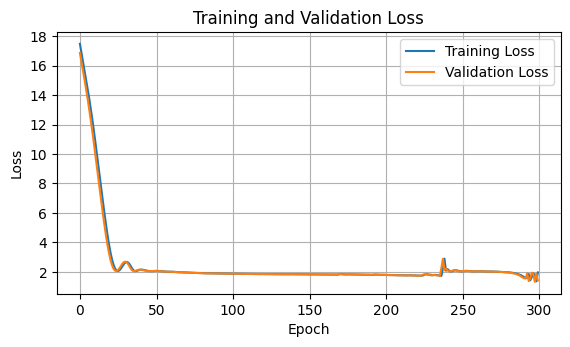

In [ ]:
plot_train_val_loss(train_loss, test_loss)

### GATv2

In [ ]:
train_loss, test_loss, best_model = train_model(GATv2_model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights,
                                                 user_nodes, product_nodes, num_epochs = 300, print_progress=True, print_freq=10)

Epoch: 10, Train Loss: 2.0018, Val Loss: 1.9844, best model epoch: 10
Epoch: 20, Train Loss: 1.9208, Val Loss: 1.9077, best model epoch: 20
Epoch: 30, Train Loss: 1.8751, Val Loss: 1.8705, best model epoch: 30
Epoch: 40, Train Loss: 1.8570, Val Loss: 1.8563, best model epoch: 39
Epoch: 50, Train Loss: 1.8538, Val Loss: 1.8487, best model epoch: 48
Epoch: 60, Train Loss: 1.8422, Val Loss: 1.8402, best model epoch: 59
Epoch: 70, Train Loss: 1.8334, Val Loss: 1.8336, best model epoch: 68
Epoch: 80, Train Loss: 1.8200, Val Loss: 1.8179, best model epoch: 80
Epoch: 90, Train Loss: 1.8100, Val Loss: 1.8061, best model epoch: 90
Epoch: 100, Train Loss: 1.7852, Val Loss: 1.7785, best model epoch: 100
Epoch: 110, Train Loss: 1.7692, Val Loss: 1.7523, best model epoch: 110
Epoch: 120, Train Loss: 1.7413, Val Loss: 1.7350, best model epoch: 120
Epoch: 130, Train Loss: 1.7595, Val Loss: 1.7561, best model epoch: 123
Epoch: 140, Train Loss: 1.7359, Val Loss: 1.7331, best model epoch: 138
Epoch: 150

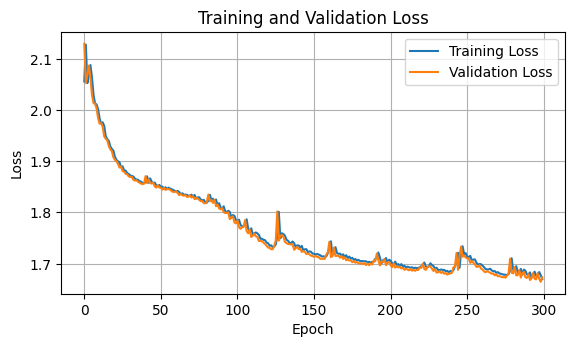

In [ ]:
plot_train_val_loss(train_loss, test_loss)

## Finetuning of model
This segment involves fine-tuning of the model

In [19]:
def run_GAT_model(hidden_dim=64, dropout_prob=0.2, lr=0.01, num_epochs = 100):
  # Instantiate the model
  model = GAT_model(num_users, num_products, user_feature_dim, product_feature_dim, hidden_dim, dropout_prob)

  # move the model
  model.to(device)

  train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights,
                                                  user_nodes, product_nodes, num_epochs = num_epochs, lr=lr, print_progress=True, print_freq=10)
  del best_model
  plot_train_val_loss(train_loss, test_loss)
  return {'hidden_dim':hidden_dim,
          'dropout_prob':dropout_prob,
          'lr':lr,
          'best test loss':min(test_loss),
          'best test loss epoch':test_loss.index(min(test_loss)) + 1,
          'corr_train_loss': train_loss[test_loss.index(min(test_loss))]}

def run_GATv2_model(hidden_dim=64, heads=2, dropout_prob=0.2, lr=0.01, num_epochs = 100):
  # Instantiate the model
  model = GATv2_model(num_users, num_products, user_feature_dim, product_feature_dim, hidden_dim, heads, dropout_prob)

  # move the model
  model.to(device)

  train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights,
                                                  user_nodes, product_nodes, num_epochs = num_epochs, lr=lr, print_progress=True, print_freq=10)

  del best_model
  plot_train_val_loss(train_loss, test_loss)
  return {'hidden_dim':hidden_dim,
            'dropout_prob':dropout_prob,
            'lr':lr,
            'heads': heads,
            'best test loss':min(test_loss),
            'best test loss epoch':test_loss.index(min(test_loss)) + 1,
            'corr_train_loss': train_loss[test_loss.index(min(test_loss))]}


In [20]:
from itertools import product

GAT_grid_params_part1 = {
    'hidden_dim': [16, 32, 64, 128, 256],
    'dropout_prob': [0.1, 0.3, 0.5],
    'lr': [1e-3, 5e-4, 1e-4],
}

# Adding new params to grid search on
GAT_grid_params_part2 = {
    'hidden_dim': [16, 32, 64, 128, 256],
    'dropout_prob': [0.2],
    'lr': [1e-3, 5e-4, 1e-4],
}

GAT_grid_params_part3 = {
    'hidden_dim': [16, 32, 64, 128, 256],
    'dropout_prob': [0.1, 0.3, 0.5],
    'lr': [0.01],
}

# GATv2 gridsearch split into many since GPU runs out memory
GATv2_grid_params_part1 = {
    'hidden_dim': [32, 128],
    'dropout_prob': [0.1, 0.3],
    'lr': [1e-3, 1e-4],
    'heads': [1, 2],
}

GATv2_grid_params_part2 = {
    'hidden_dim': [64, 256],
    'dropout_prob': [0.1, 0.3],
    'lr': [1e-3, 1e-4],
    'heads': [1, 2],
}

GATv2_grid_params_part3 = {
    'hidden_dim': [256],
    'dropout_prob': [0.1, 0.3],
    'lr': [1e-3, 1e-4],
    'heads': [1, 2],
}

GATv2_grid_params_part4 = {
    'hidden_dim': [16],
    'dropout_prob': [0.1, 0.3],
    'lr': [1e-3, 1e-4],
    'heads': [1, 2],
}

# Adding new params to grid search on
new_lr_values = [0.01, 5e-4]
new_dropout_values = [0.5, 0.2]
GATv2_grid_params_part5 = {
    'hidden_dim': [32, 128],
    'dropout_prob': new_dropout_values,
    'lr': new_lr_values,
    'heads': [1, 2],
}

# Part 6: New lr/dropout with hidden_dim from Part 2
GATv2_grid_params_part6 = {
    'hidden_dim': [64],
    'dropout_prob': new_dropout_values,
    'lr': new_lr_values,
    'heads': [1, 2],
}

# Part 7: New lr/dropout with hidden_dim from Part 4
GATv2_grid_params_part7 = {
    'hidden_dim': [16],
    'dropout_prob': new_dropout_values,
    'lr': new_lr_values,
    'heads': [1, 2],
}



def create_gridsearch_df(grid_params):
  keys = grid_params.keys()
  values = (grid_params[key] for key in keys)
  grid = [dict(zip(keys, v)) for v in product(*values)]
  return pd.DataFrame(grid)

GAT_grid_params_part1 = create_gridsearch_df(GAT_grid_params_part1)
GAT_grid_params_part2 = create_gridsearch_df(GAT_grid_params_part2)
GAT_grid_params_part3 = create_gridsearch_df(GAT_grid_params_part3)

GATv2_grid_params_part1 = create_gridsearch_df(GATv2_grid_params_part1)
GATv2_grid_params_part2 = create_gridsearch_df(GATv2_grid_params_part2)
GATv2_grid_params_part3 = create_gridsearch_df(GATv2_grid_params_part3)
GATv2_grid_params_part4 = create_gridsearch_df(GATv2_grid_params_part4)

GATv2_grid_params_part5 = create_gridsearch_df(GATv2_grid_params_part5)
GATv2_grid_params_part6 = create_gridsearch_df(GATv2_grid_params_part6)
GATv2_grid_params_part7 = create_gridsearch_df(GATv2_grid_params_part7)

Fine tuning GAT

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 18.4396, Val Loss: 18.3739, best model epoch: 10
Epoch: 20, Train Loss: 18.0230, Val Loss: 17.9579, best model epoch: 20
Epoch: 30, Train Loss: 17.6078, Val Loss: 17.5391, best model epoch: 30
Epoch: 40, Train Loss: 17.1690, Val Loss: 17.0926, best model epoch: 40
Epoch: 50, Train Loss: 16.7050, Val Loss: 16.6267, best model epoch: 50
Epoch: 60, Train Loss: 16.2246, Val Loss: 16.1401, best model epoch: 60
Epoch: 70, Train Loss: 15.7152, Val Loss: 15.6275, best model epoch: 70
Epoch: 80, Train Loss: 15.1692, Val Loss: 15.0745, best model epoch: 80
Epoch: 90, Train Loss: 14.5854, Val Loss: 14.4837, best model epoch: 90
Epoch: 100, Train Loss: 13.9611, Val Loss: 13.8528, best model epoch: 100
Epoch: 110, Train Loss: 13.2956, Val Loss: 13.1801, best model epoch: 110
Epoch: 120, Train Loss: 12.5905, Val Loss: 12.4655, best model epoch: 120
Epoch: 130, Train Loss: 11.8439, Val Loss: 11.7063, best model epoch: 130
Epoch: 1

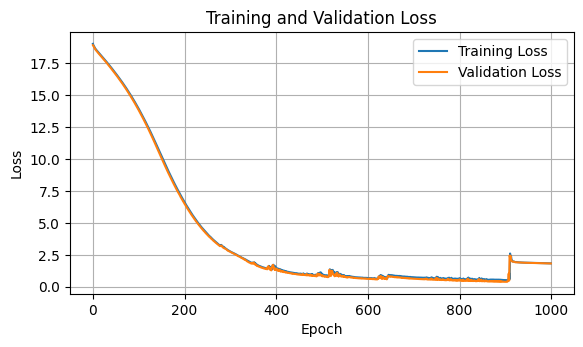

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.0005
Epoch: 10, Train Loss: 17.8262, Val Loss: 17.7960, best model epoch: 10
Epoch: 20, Train Loss: 17.5888, Val Loss: 17.5670, best model epoch: 20
Epoch: 30, Train Loss: 17.4463, Val Loss: 17.4282, best model epoch: 30
Epoch: 40, Train Loss: 17.3046, Val Loss: 17.2807, best model epoch: 40
Epoch: 50, Train Loss: 17.1453, Val Loss: 17.1205, best model epoch: 50
Epoch: 60, Train Loss: 16.9884, Val Loss: 16.9615, best model epoch: 60
Epoch: 70, Train Loss: 16.8312, Val Loss: 16.8013, best model epoch: 70
Epoch: 80, Train Loss: 16.6717, Val Loss: 16.6386, best model epoch: 80
Epoch: 90, Train Loss: 16.5075, Val Loss: 16.4718, best model epoch: 90
Epoch: 100, Train Loss: 16.3357, Val Loss: 16.2976, best model epoch: 100
Epoch: 110, Train Loss: 16.1534, Val Loss: 16.1125, best model epoch: 110
Epoch: 120, Train Loss: 15.9579, Val Loss: 15.9113, best model epoch: 120
Epoch: 130, Train Loss: 15.7466, Val Loss: 15.6947, best model epoch: 130
Epoch: 

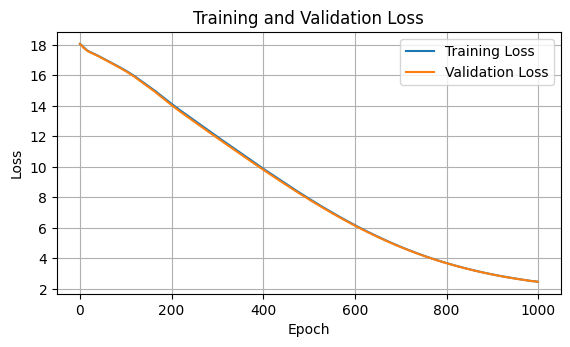

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 19.3259, Val Loss: 19.3060, best model epoch: 10
Epoch: 20, Train Loss: 19.1990, Val Loss: 19.1755, best model epoch: 20
Epoch: 30, Train Loss: 19.0821, Val Loss: 19.0579, best model epoch: 30
Epoch: 40, Train Loss: 18.9937, Val Loss: 18.9729, best model epoch: 40
Epoch: 50, Train Loss: 18.9254, Val Loss: 18.9015, best model epoch: 50
Epoch: 60, Train Loss: 18.8519, Val Loss: 18.8271, best model epoch: 60
Epoch: 70, Train Loss: 18.7827, Val Loss: 18.7559, best model epoch: 70
Epoch: 80, Train Loss: 18.7149, Val Loss: 18.6862, best model epoch: 80
Epoch: 90, Train Loss: 18.6472, Val Loss: 18.6172, best model epoch: 90
Epoch: 100, Train Loss: 18.5806, Val Loss: 18.5492, best model epoch: 100
Epoch: 110, Train Loss: 18.5148, Val Loss: 18.4823, best model epoch: 110
Epoch: 120, Train Loss: 18.4493, Val Loss: 18.4163, best model epoch: 120
Epoch: 130, Train Loss: 18.3848, Val Loss: 18.3511, best model epoch: 130
Epoch: 

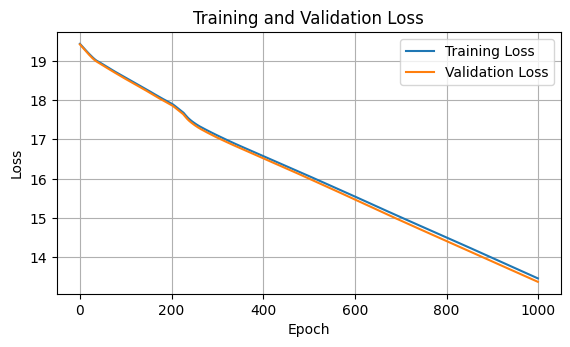

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 17.7915, Val Loss: 17.6911, best model epoch: 10
Epoch: 20, Train Loss: 17.3728, Val Loss: 17.2657, best model epoch: 20
Epoch: 30, Train Loss: 16.9888, Val Loss: 16.8759, best model epoch: 30
Epoch: 40, Train Loss: 16.5932, Val Loss: 16.4684, best model epoch: 40
Epoch: 50, Train Loss: 16.1788, Val Loss: 16.0321, best model epoch: 50
Epoch: 60, Train Loss: 15.7425, Val Loss: 15.5849, best model epoch: 60
Epoch: 70, Train Loss: 15.2825, Val Loss: 15.1105, best model epoch: 70
Epoch: 80, Train Loss: 14.7922, Val Loss: 14.6051, best model epoch: 80
Epoch: 90, Train Loss: 14.2746, Val Loss: 14.0724, best model epoch: 90
Epoch: 100, Train Loss: 13.7303, Val Loss: 13.5193, best model epoch: 100
Epoch: 110, Train Loss: 13.1678, Val Loss: 12.9495, best model epoch: 110
Epoch: 120, Train Loss: 12.5882, Val Loss: 12.3702, best model epoch: 120
Epoch: 130, Train Loss: 11.9983, Val Loss: 11.7828, best model epoch: 130
Epoch: 1

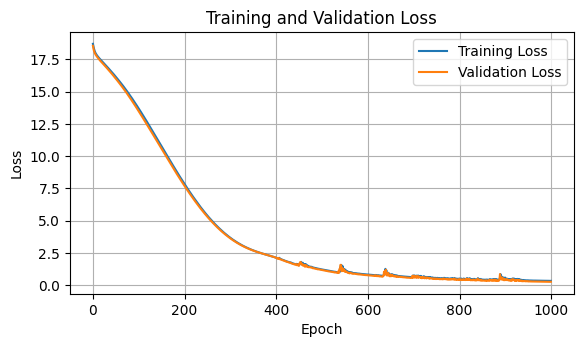

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.0005
Epoch: 10, Train Loss: 18.8144, Val Loss: 18.7616, best model epoch: 10
Epoch: 20, Train Loss: 18.4771, Val Loss: 18.4114, best model epoch: 20
Epoch: 30, Train Loss: 18.1935, Val Loss: 18.1345, best model epoch: 30
Epoch: 40, Train Loss: 17.9231, Val Loss: 17.8572, best model epoch: 40
Epoch: 50, Train Loss: 17.6609, Val Loss: 17.5884, best model epoch: 50
Epoch: 60, Train Loss: 17.4165, Val Loss: 17.3330, best model epoch: 60
Epoch: 70, Train Loss: 17.1793, Val Loss: 17.0748, best model epoch: 70
Epoch: 80, Train Loss: 16.9552, Val Loss: 16.8258, best model epoch: 80
Epoch: 90, Train Loss: 16.7442, Val Loss: 16.6043, best model epoch: 90
Epoch: 100, Train Loss: 16.5508, Val Loss: 16.4205, best model epoch: 100
Epoch: 110, Train Loss: 16.3788, Val Loss: 16.2553, best model epoch: 110
Epoch: 120, Train Loss: 16.2232, Val Loss: 16.1103, best model epoch: 120
Epoch: 130, Train Loss: 16.0769, Val Loss: 15.9687, best model epoch: 130
Epoch: 

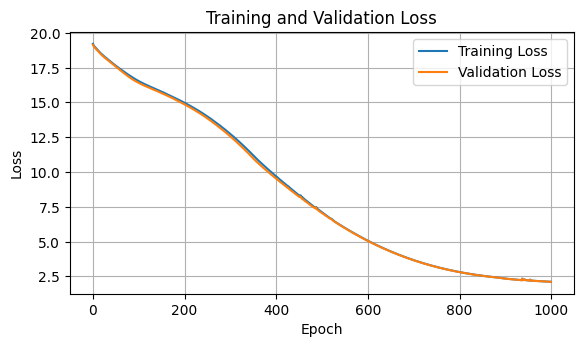

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 17.5699, Val Loss: 17.5794, best model epoch: 10
Epoch: 20, Train Loss: 17.5034, Val Loss: 17.5056, best model epoch: 20
Epoch: 30, Train Loss: 17.4501, Val Loss: 17.4470, best model epoch: 30
Epoch: 40, Train Loss: 17.4042, Val Loss: 17.3974, best model epoch: 40
Epoch: 50, Train Loss: 17.3647, Val Loss: 17.3557, best model epoch: 50
Epoch: 60, Train Loss: 17.3297, Val Loss: 17.3183, best model epoch: 60
Epoch: 70, Train Loss: 17.2950, Val Loss: 17.2817, best model epoch: 70
Epoch: 80, Train Loss: 17.2610, Val Loss: 17.2456, best model epoch: 80
Epoch: 90, Train Loss: 17.2270, Val Loss: 17.2098, best model epoch: 90
Epoch: 100, Train Loss: 17.1932, Val Loss: 17.1742, best model epoch: 100
Epoch: 110, Train Loss: 17.1596, Val Loss: 17.1386, best model epoch: 110
Epoch: 120, Train Loss: 17.1259, Val Loss: 17.1031, best model epoch: 120
Epoch: 130, Train Loss: 17.0921, Val Loss: 17.0674, best model epoch: 130
Epoch: 

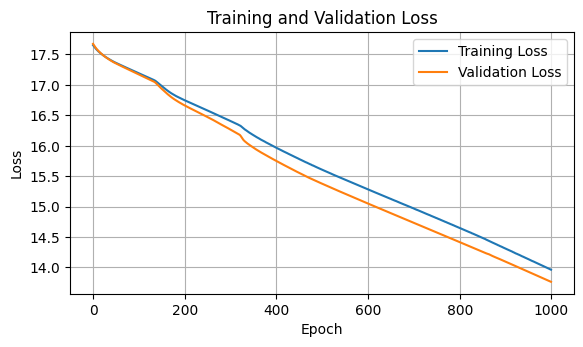

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.001
Epoch: 10, Train Loss: 17.7738, Val Loss: 17.5464, best model epoch: 10
Epoch: 20, Train Loss: 17.4114, Val Loss: 17.1043, best model epoch: 20
Epoch: 30, Train Loss: 17.0406, Val Loss: 16.6828, best model epoch: 30
Epoch: 40, Train Loss: 16.6535, Val Loss: 16.2411, best model epoch: 40
Epoch: 50, Train Loss: 16.2323, Val Loss: 15.7930, best model epoch: 50
Epoch: 60, Train Loss: 15.7605, Val Loss: 15.2817, best model epoch: 60
Epoch: 70, Train Loss: 15.2010, Val Loss: 14.7124, best model epoch: 70
Epoch: 80, Train Loss: 14.5823, Val Loss: 14.0920, best model epoch: 80
Epoch: 90, Train Loss: 13.8859, Val Loss: 13.4110, best model epoch: 90
Epoch: 100, Train Loss: 13.0570, Val Loss: 12.6061, best model epoch: 100
Epoch: 110, Train Loss: 12.2312, Val Loss: 11.7550, best model epoch: 110
Epoch: 120, Train Loss: 11.3918, Val Loss: 10.9246, best model epoch: 120
Epoch: 130, Train Loss: 10.5265, Val Loss: 10.0583, best model epoch: 130
Epoch: 1

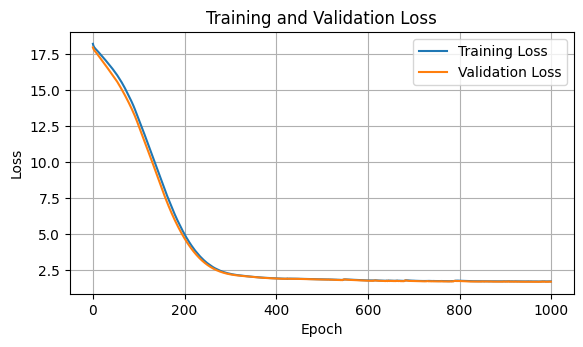

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 16.2567, Val Loss: 16.1562, best model epoch: 10
Epoch: 20, Train Loss: 16.0537, Val Loss: 15.9761, best model epoch: 20
Epoch: 30, Train Loss: 15.8786, Val Loss: 15.7667, best model epoch: 30
Epoch: 40, Train Loss: 15.6913, Val Loss: 15.5415, best model epoch: 40
Epoch: 50, Train Loss: 15.4952, Val Loss: 15.3040, best model epoch: 50
Epoch: 60, Train Loss: 15.2888, Val Loss: 15.0616, best model epoch: 60
Epoch: 70, Train Loss: 15.0758, Val Loss: 14.8170, best model epoch: 70
Epoch: 80, Train Loss: 14.8543, Val Loss: 14.5678, best model epoch: 80
Epoch: 90, Train Loss: 14.6230, Val Loss: 14.3136, best model epoch: 90
Epoch: 100, Train Loss: 14.3810, Val Loss: 14.0514, best model epoch: 100
Epoch: 110, Train Loss: 14.1275, Val Loss: 13.7868, best model epoch: 110
Epoch: 120, Train Loss: 13.8734, Val Loss: 13.5170, best model epoch: 120
Epoch: 130, Train Loss: 13.5900, Val Loss: 13.2259, best model epoch: 130
Epoch: 

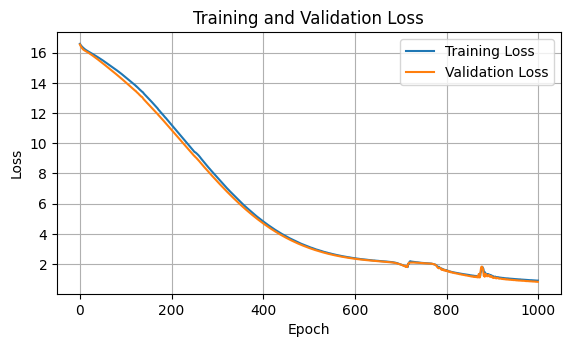

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.0001
Epoch: 10, Train Loss: 16.6621, Val Loss: 16.6292, best model epoch: 10
Epoch: 20, Train Loss: 16.6075, Val Loss: 16.5615, best model epoch: 20
Epoch: 30, Train Loss: 16.5576, Val Loss: 16.4999, best model epoch: 30
Epoch: 40, Train Loss: 16.5132, Val Loss: 16.4459, best model epoch: 40
Epoch: 50, Train Loss: 16.4704, Val Loss: 16.3982, best model epoch: 50
Epoch: 60, Train Loss: 16.4279, Val Loss: 16.3511, best model epoch: 60
Epoch: 70, Train Loss: 16.3842, Val Loss: 16.3013, best model epoch: 70
Epoch: 80, Train Loss: 16.3386, Val Loss: 16.2508, best model epoch: 80
Epoch: 90, Train Loss: 16.2928, Val Loss: 16.2003, best model epoch: 90
Epoch: 100, Train Loss: 16.2459, Val Loss: 16.1491, best model epoch: 100
Epoch: 110, Train Loss: 16.1983, Val Loss: 16.0974, best model epoch: 110
Epoch: 120, Train Loss: 16.1504, Val Loss: 16.0463, best model epoch: 120
Epoch: 130, Train Loss: 16.1024, Val Loss: 15.9959, best model epoch: 130
Epoch: 

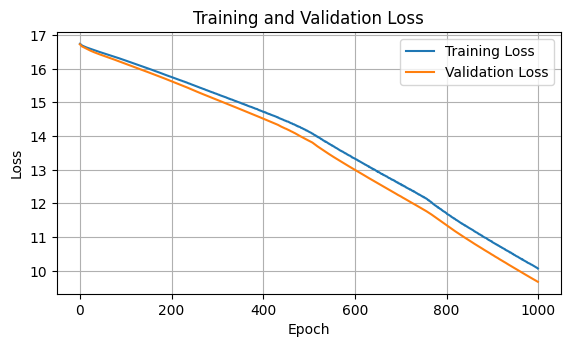

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 18.2319, Val Loss: 18.1499, best model epoch: 10
Epoch: 20, Train Loss: 17.5787, Val Loss: 17.4896, best model epoch: 20
Epoch: 30, Train Loss: 16.8903, Val Loss: 16.7874, best model epoch: 30
Epoch: 40, Train Loss: 16.1129, Val Loss: 15.9890, best model epoch: 40
Epoch: 50, Train Loss: 15.2678, Val Loss: 15.1248, best model epoch: 50
Epoch: 60, Train Loss: 14.3238, Val Loss: 14.1513, best model epoch: 60
Epoch: 70, Train Loss: 13.3184, Val Loss: 13.1249, best model epoch: 70
Epoch: 80, Train Loss: 12.2763, Val Loss: 12.0697, best model epoch: 80
Epoch: 90, Train Loss: 11.2095, Val Loss: 10.9989, best model epoch: 90
Epoch: 100, Train Loss: 10.1496, Val Loss: 9.9431, best model epoch: 100
Epoch: 110, Train Loss: 9.1072, Val Loss: 8.9069, best model epoch: 110
Epoch: 120, Train Loss: 8.0963, Val Loss: 7.9065, best model epoch: 120
Epoch: 130, Train Loss: 7.1369, Val Loss: 6.9605, best model epoch: 130
Epoch: 140, Tra

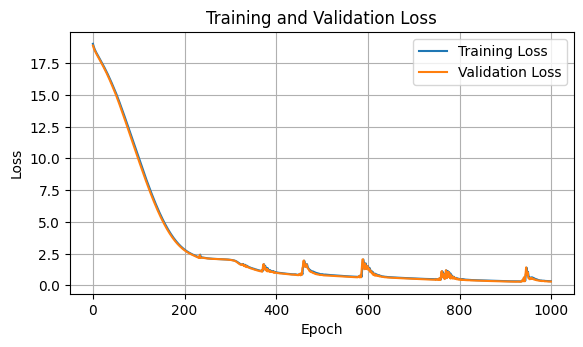

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.0005
Epoch: 10, Train Loss: 19.0902, Val Loss: 19.0590, best model epoch: 10
Epoch: 20, Train Loss: 18.8336, Val Loss: 18.7975, best model epoch: 20
Epoch: 30, Train Loss: 18.5557, Val Loss: 18.5132, best model epoch: 30
Epoch: 40, Train Loss: 18.2610, Val Loss: 18.2143, best model epoch: 40
Epoch: 50, Train Loss: 17.9412, Val Loss: 17.8863, best model epoch: 50
Epoch: 60, Train Loss: 17.6045, Val Loss: 17.5381, best model epoch: 60
Epoch: 70, Train Loss: 17.2594, Val Loss: 17.1803, best model epoch: 70
Epoch: 80, Train Loss: 16.8900, Val Loss: 16.7966, best model epoch: 80
Epoch: 90, Train Loss: 16.5079, Val Loss: 16.4034, best model epoch: 90
Epoch: 100, Train Loss: 16.1170, Val Loss: 15.9980, best model epoch: 100
Epoch: 110, Train Loss: 15.7179, Val Loss: 15.5869, best model epoch: 110
Epoch: 120, Train Loss: 15.3041, Val Loss: 15.1597, best model epoch: 120
Epoch: 130, Train Loss: 14.8726, Val Loss: 14.7146, best model epoch: 130
Epoch: 

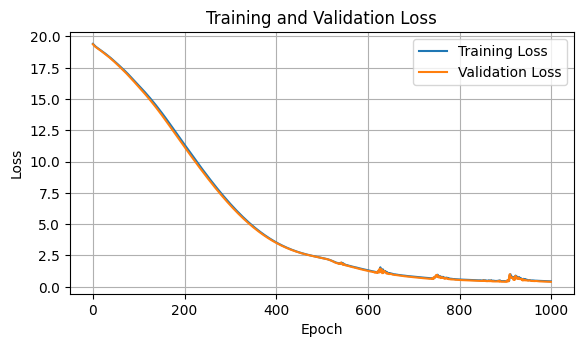

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 18.6539, Val Loss: 18.6452, best model epoch: 10
Epoch: 20, Train Loss: 18.5732, Val Loss: 18.5650, best model epoch: 20
Epoch: 30, Train Loss: 18.5037, Val Loss: 18.4931, best model epoch: 30
Epoch: 40, Train Loss: 18.4378, Val Loss: 18.4256, best model epoch: 40
Epoch: 50, Train Loss: 18.3731, Val Loss: 18.3593, best model epoch: 50
Epoch: 60, Train Loss: 18.3086, Val Loss: 18.2933, best model epoch: 60
Epoch: 70, Train Loss: 18.2412, Val Loss: 18.2234, best model epoch: 70
Epoch: 80, Train Loss: 18.1689, Val Loss: 18.1479, best model epoch: 80
Epoch: 90, Train Loss: 18.0919, Val Loss: 18.0680, best model epoch: 90
Epoch: 100, Train Loss: 18.0151, Val Loss: 17.9882, best model epoch: 100
Epoch: 110, Train Loss: 17.9376, Val Loss: 17.9070, best model epoch: 110
Epoch: 120, Train Loss: 17.8637, Val Loss: 17.8319, best model epoch: 120
Epoch: 130, Train Loss: 17.7932, Val Loss: 17.7599, best model epoch: 130
Epoch: 

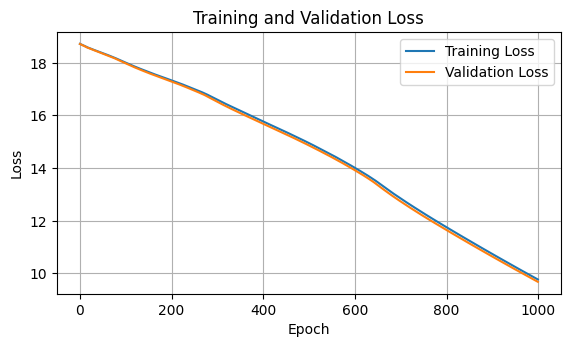

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 17.0201, Val Loss: 16.9559, best model epoch: 10
Epoch: 20, Train Loss: 16.6850, Val Loss: 16.6077, best model epoch: 20
Epoch: 30, Train Loss: 16.3306, Val Loss: 16.2435, best model epoch: 30
Epoch: 40, Train Loss: 15.9519, Val Loss: 15.8475, best model epoch: 40
Epoch: 50, Train Loss: 15.5290, Val Loss: 15.4070, best model epoch: 50
Epoch: 60, Train Loss: 15.0543, Val Loss: 14.9200, best model epoch: 60
Epoch: 70, Train Loss: 14.5243, Val Loss: 14.3759, best model epoch: 70
Epoch: 80, Train Loss: 13.9361, Val Loss: 13.7700, best model epoch: 80
Epoch: 90, Train Loss: 13.2527, Val Loss: 13.0581, best model epoch: 90
Epoch: 100, Train Loss: 12.5095, Val Loss: 12.3001, best model epoch: 100
Epoch: 110, Train Loss: 11.7298, Val Loss: 11.5260, best model epoch: 110
Epoch: 120, Train Loss: 10.9298, Val Loss: 10.7377, best model epoch: 120
Epoch: 130, Train Loss: 10.1232, Val Loss: 9.9455, best model epoch: 130
Epoch: 14

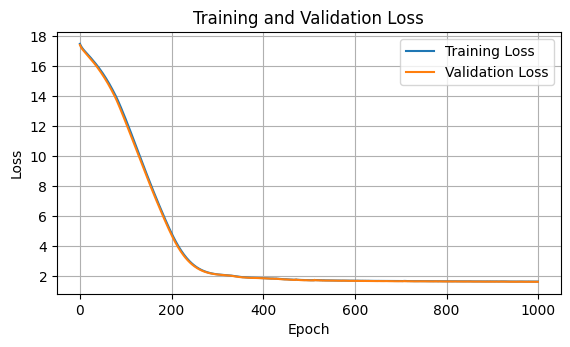

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.0005
Epoch: 10, Train Loss: 17.6324, Val Loss: 17.5712, best model epoch: 10
Epoch: 20, Train Loss: 17.3601, Val Loss: 17.2838, best model epoch: 20
Epoch: 30, Train Loss: 17.0554, Val Loss: 16.9558, best model epoch: 30
Epoch: 40, Train Loss: 16.7548, Val Loss: 16.6315, best model epoch: 40
Epoch: 50, Train Loss: 16.4419, Val Loss: 16.2911, best model epoch: 50
Epoch: 60, Train Loss: 16.1133, Val Loss: 15.9458, best model epoch: 60
Epoch: 70, Train Loss: 15.7806, Val Loss: 15.6011, best model epoch: 70
Epoch: 80, Train Loss: 15.4377, Val Loss: 15.2459, best model epoch: 80
Epoch: 90, Train Loss: 15.0866, Val Loss: 14.8849, best model epoch: 90
Epoch: 100, Train Loss: 14.7343, Val Loss: 14.5167, best model epoch: 100
Epoch: 110, Train Loss: 14.3672, Val Loss: 14.1331, best model epoch: 110
Epoch: 120, Train Loss: 13.9857, Val Loss: 13.7375, best model epoch: 120
Epoch: 130, Train Loss: 13.5902, Val Loss: 13.3317, best model epoch: 130
Epoch: 

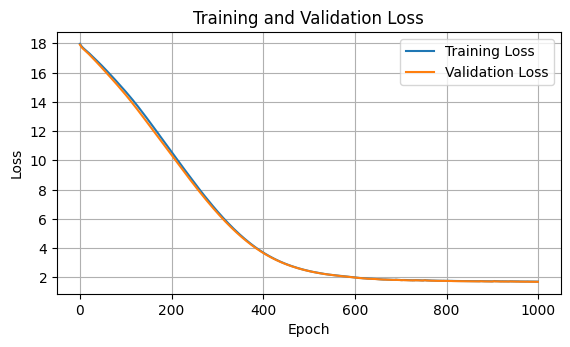

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 19.0150, Val Loss: 18.9688, best model epoch: 10
Epoch: 20, Train Loss: 18.9148, Val Loss: 18.8583, best model epoch: 20
Epoch: 30, Train Loss: 18.8458, Val Loss: 18.7830, best model epoch: 30
Epoch: 40, Train Loss: 18.7828, Val Loss: 18.7144, best model epoch: 40
Epoch: 50, Train Loss: 18.7240, Val Loss: 18.6560, best model epoch: 50
Epoch: 60, Train Loss: 18.6686, Val Loss: 18.6039, best model epoch: 60
Epoch: 70, Train Loss: 18.6138, Val Loss: 18.5513, best model epoch: 70
Epoch: 80, Train Loss: 18.5581, Val Loss: 18.4974, best model epoch: 80
Epoch: 90, Train Loss: 18.4949, Val Loss: 18.4286, best model epoch: 90
Epoch: 100, Train Loss: 18.4156, Val Loss: 18.3476, best model epoch: 100
Epoch: 110, Train Loss: 18.3409, Val Loss: 18.2750, best model epoch: 110
Epoch: 120, Train Loss: 18.2710, Val Loss: 18.2076, best model epoch: 120
Epoch: 130, Train Loss: 18.2013, Val Loss: 18.1370, best model epoch: 130
Epoch: 

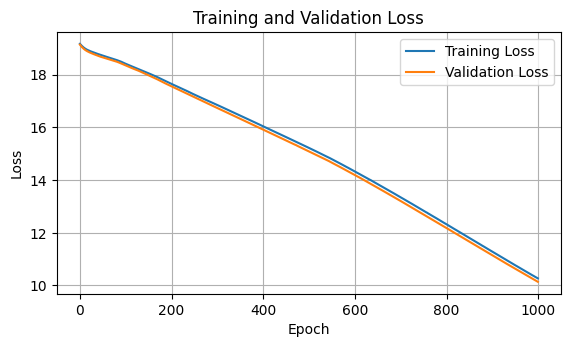

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.001
Epoch: 10, Train Loss: 16.4791, Val Loss: 16.3450, best model epoch: 10
Epoch: 20, Train Loss: 15.9589, Val Loss: 15.7884, best model epoch: 20
Epoch: 30, Train Loss: 15.4245, Val Loss: 15.2324, best model epoch: 30
Epoch: 40, Train Loss: 14.8643, Val Loss: 14.6499, best model epoch: 40
Epoch: 50, Train Loss: 14.2628, Val Loss: 14.0328, best model epoch: 50
Epoch: 60, Train Loss: 13.6171, Val Loss: 13.3666, best model epoch: 60
Epoch: 70, Train Loss: 12.9161, Val Loss: 12.6452, best model epoch: 70
Epoch: 80, Train Loss: 12.1549, Val Loss: 11.8603, best model epoch: 80
Epoch: 90, Train Loss: 11.3115, Val Loss: 11.0028, best model epoch: 90
Epoch: 100, Train Loss: 10.4223, Val Loss: 10.1095, best model epoch: 100
Epoch: 110, Train Loss: 9.5073, Val Loss: 9.2034, best model epoch: 110
Epoch: 120, Train Loss: 8.5901, Val Loss: 8.3034, best model epoch: 120
Epoch: 130, Train Loss: 7.6870, Val Loss: 7.4236, best model epoch: 130
Epoch: 140, Tr

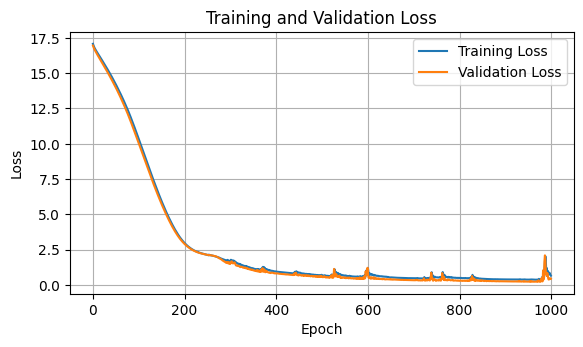

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 16.9031, Val Loss: 16.8089, best model epoch: 10
Epoch: 20, Train Loss: 16.5975, Val Loss: 16.4703, best model epoch: 20
Epoch: 30, Train Loss: 16.2746, Val Loss: 16.0900, best model epoch: 30
Epoch: 40, Train Loss: 15.9411, Val Loss: 15.7045, best model epoch: 40
Epoch: 50, Train Loss: 15.5916, Val Loss: 15.3148, best model epoch: 50
Epoch: 60, Train Loss: 15.2242, Val Loss: 14.9039, best model epoch: 60
Epoch: 70, Train Loss: 14.8371, Val Loss: 14.4825, best model epoch: 70
Epoch: 80, Train Loss: 14.4324, Val Loss: 14.0566, best model epoch: 80
Epoch: 90, Train Loss: 14.0014, Val Loss: 13.6182, best model epoch: 90
Epoch: 100, Train Loss: 13.5608, Val Loss: 13.1646, best model epoch: 100
Epoch: 110, Train Loss: 13.1049, Val Loss: 12.7058, best model epoch: 110
Epoch: 120, Train Loss: 12.6280, Val Loss: 12.2144, best model epoch: 120
Epoch: 130, Train Loss: 12.1222, Val Loss: 11.6959, best model epoch: 130
Epoch: 

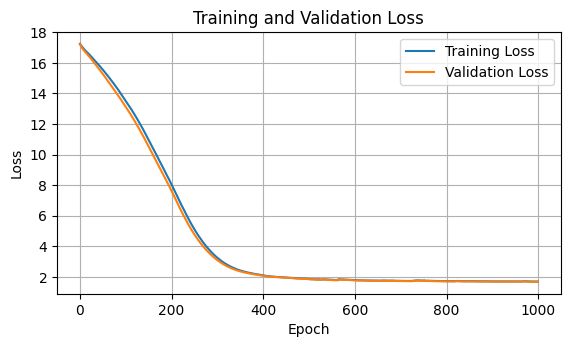

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.0001
Epoch: 10, Train Loss: 17.6218, Val Loss: 17.5929, best model epoch: 10
Epoch: 20, Train Loss: 17.5350, Val Loss: 17.4899, best model epoch: 20
Epoch: 30, Train Loss: 17.4555, Val Loss: 17.4016, best model epoch: 30
Epoch: 40, Train Loss: 17.3833, Val Loss: 17.3180, best model epoch: 40
Epoch: 50, Train Loss: 17.3115, Val Loss: 17.2435, best model epoch: 50
Epoch: 60, Train Loss: 17.2542, Val Loss: 17.1827, best model epoch: 60
Epoch: 70, Train Loss: 17.2023, Val Loss: 17.1265, best model epoch: 70
Epoch: 80, Train Loss: 17.1508, Val Loss: 17.0699, best model epoch: 80
Epoch: 90, Train Loss: 17.0996, Val Loss: 17.0147, best model epoch: 90
Epoch: 100, Train Loss: 17.0527, Val Loss: 16.9636, best model epoch: 100
Epoch: 110, Train Loss: 17.0061, Val Loss: 16.9145, best model epoch: 110
Epoch: 120, Train Loss: 16.9593, Val Loss: 16.8697, best model epoch: 120
Epoch: 130, Train Loss: 16.9080, Val Loss: 16.8211, best model epoch: 130
Epoch: 

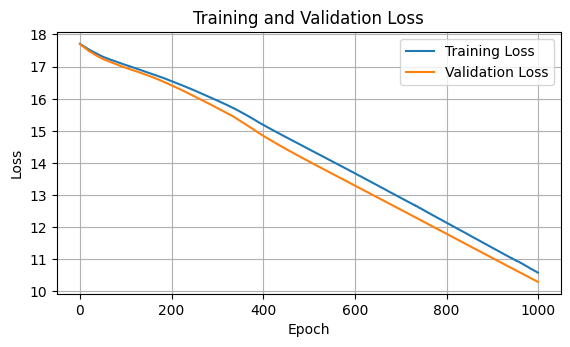

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.3821, Val Loss: 17.2925, best model epoch: 10
Epoch: 20, Train Loss: 16.6459, Val Loss: 16.5492, best model epoch: 20
Epoch: 30, Train Loss: 15.8902, Val Loss: 15.7752, best model epoch: 30
Epoch: 40, Train Loss: 15.0173, Val Loss: 14.8621, best model epoch: 40
Epoch: 50, Train Loss: 13.9797, Val Loss: 13.7638, best model epoch: 50
Epoch: 60, Train Loss: 12.8549, Val Loss: 12.6065, best model epoch: 60
Epoch: 70, Train Loss: 11.6848, Val Loss: 11.4205, best model epoch: 70
Epoch: 80, Train Loss: 10.4824, Val Loss: 10.2191, best model epoch: 80
Epoch: 90, Train Loss: 9.2715, Val Loss: 9.0183, best model epoch: 90
Epoch: 100, Train Loss: 8.0823, Val Loss: 7.8438, best model epoch: 100
Epoch: 110, Train Loss: 6.9484, Val Loss: 6.7300, best model epoch: 110
Epoch: 120, Train Loss: 5.9031, Val Loss: 5.7091, best model epoch: 120
Epoch: 130, Train Loss: 4.9752, Val Loss: 4.8082, best model epoch: 130
Epoch: 140, Train 

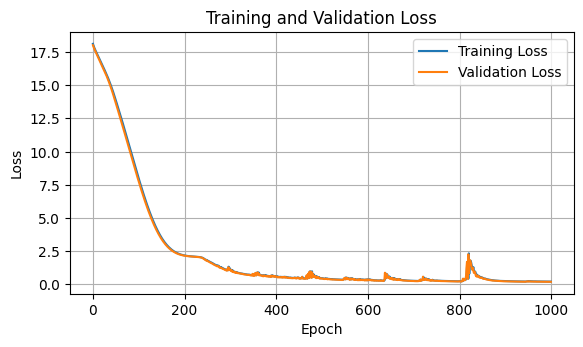

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.0005
Epoch: 10, Train Loss: 17.6535, Val Loss: 17.6107, best model epoch: 10
Epoch: 20, Train Loss: 17.3234, Val Loss: 17.2795, best model epoch: 20
Epoch: 30, Train Loss: 17.0109, Val Loss: 16.9612, best model epoch: 30
Epoch: 40, Train Loss: 16.6723, Val Loss: 16.6143, best model epoch: 40
Epoch: 50, Train Loss: 16.2974, Val Loss: 16.2291, best model epoch: 50
Epoch: 60, Train Loss: 15.9003, Val Loss: 15.8263, best model epoch: 60
Epoch: 70, Train Loss: 15.4982, Val Loss: 15.4178, best model epoch: 70
Epoch: 80, Train Loss: 15.0775, Val Loss: 14.9907, best model epoch: 80
Epoch: 90, Train Loss: 14.6345, Val Loss: 14.5395, best model epoch: 90
Epoch: 100, Train Loss: 14.1623, Val Loss: 14.0578, best model epoch: 100
Epoch: 110, Train Loss: 13.6574, Val Loss: 13.5433, best model epoch: 110
Epoch: 120, Train Loss: 13.1181, Val Loss: 12.9915, best model epoch: 120
Epoch: 130, Train Loss: 12.5292, Val Loss: 12.3898, best model epoch: 130
Epoch: 

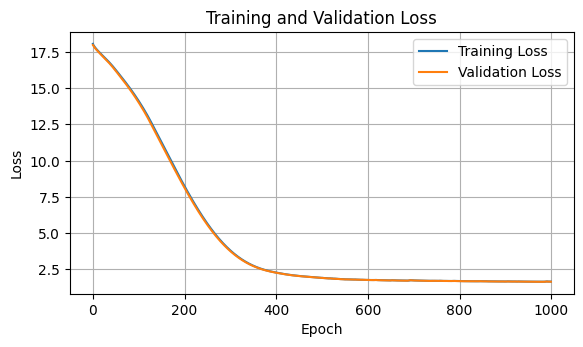

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.4925, Val Loss: 17.4799, best model epoch: 10
Epoch: 20, Train Loss: 17.3928, Val Loss: 17.3791, best model epoch: 20
Epoch: 30, Train Loss: 17.2974, Val Loss: 17.2822, best model epoch: 30
Epoch: 40, Train Loss: 17.2030, Val Loss: 17.1868, best model epoch: 40
Epoch: 50, Train Loss: 17.1140, Val Loss: 17.0968, best model epoch: 50
Epoch: 60, Train Loss: 17.0331, Val Loss: 17.0162, best model epoch: 60
Epoch: 70, Train Loss: 16.9564, Val Loss: 16.9383, best model epoch: 70
Epoch: 80, Train Loss: 16.8820, Val Loss: 16.8622, best model epoch: 80
Epoch: 90, Train Loss: 16.8069, Val Loss: 16.7855, best model epoch: 90
Epoch: 100, Train Loss: 16.7310, Val Loss: 16.7072, best model epoch: 100
Epoch: 110, Train Loss: 16.6539, Val Loss: 16.6276, best model epoch: 110
Epoch: 120, Train Loss: 16.5747, Val Loss: 16.5455, best model epoch: 120
Epoch: 130, Train Loss: 16.4942, Val Loss: 16.4618, best model epoch: 130
Epoch: 

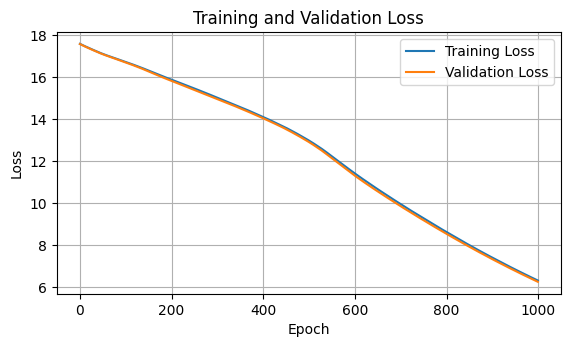

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 17.4927, Val Loss: 17.3789, best model epoch: 10
Epoch: 20, Train Loss: 16.7456, Val Loss: 16.5897, best model epoch: 20
Epoch: 30, Train Loss: 15.9047, Val Loss: 15.7103, best model epoch: 30
Epoch: 40, Train Loss: 14.9586, Val Loss: 14.7190, best model epoch: 40
Epoch: 50, Train Loss: 13.9006, Val Loss: 13.6245, best model epoch: 50
Epoch: 60, Train Loss: 12.7366, Val Loss: 12.4392, best model epoch: 60
Epoch: 70, Train Loss: 11.4843, Val Loss: 11.1760, best model epoch: 70
Epoch: 80, Train Loss: 10.1845, Val Loss: 9.8821, best model epoch: 80
Epoch: 90, Train Loss: 8.8868, Val Loss: 8.6046, best model epoch: 90
Epoch: 100, Train Loss: 7.6202, Val Loss: 7.3645, best model epoch: 100
Epoch: 110, Train Loss: 6.4296, Val Loss: 6.2019, best model epoch: 110
Epoch: 120, Train Loss: 5.3474, Val Loss: 5.1496, best model epoch: 120
Epoch: 130, Train Loss: 4.4035, Val Loss: 4.2406, best model epoch: 130
Epoch: 140, Train L

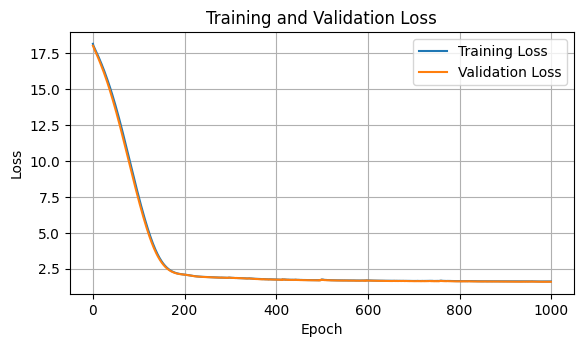

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.0005
Epoch: 10, Train Loss: 16.9163, Val Loss: 16.8651, best model epoch: 10
Epoch: 20, Train Loss: 16.6151, Val Loss: 16.5505, best model epoch: 20
Epoch: 30, Train Loss: 16.3105, Val Loss: 16.2296, best model epoch: 30
Epoch: 40, Train Loss: 15.9941, Val Loss: 15.8986, best model epoch: 40
Epoch: 50, Train Loss: 15.6291, Val Loss: 15.5132, best model epoch: 50
Epoch: 60, Train Loss: 15.2061, Val Loss: 15.0647, best model epoch: 60
Epoch: 70, Train Loss: 14.7347, Val Loss: 14.5741, best model epoch: 70
Epoch: 80, Train Loss: 14.2230, Val Loss: 14.0314, best model epoch: 80
Epoch: 90, Train Loss: 13.6633, Val Loss: 13.4456, best model epoch: 90
Epoch: 100, Train Loss: 13.0834, Val Loss: 12.8456, best model epoch: 100
Epoch: 110, Train Loss: 12.4622, Val Loss: 12.2065, best model epoch: 110
Epoch: 120, Train Loss: 11.8097, Val Loss: 11.5439, best model epoch: 120
Epoch: 130, Train Loss: 11.1335, Val Loss: 10.8551, best model epoch: 130
Epoch: 

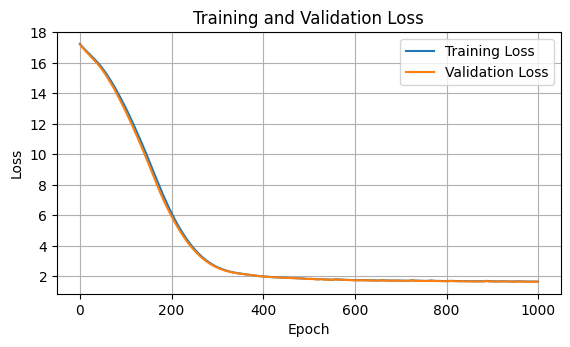

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.1425, Val Loss: 18.1252, best model epoch: 10
Epoch: 20, Train Loss: 18.0385, Val Loss: 18.0137, best model epoch: 20
Epoch: 30, Train Loss: 17.9420, Val Loss: 17.9118, best model epoch: 30
Epoch: 40, Train Loss: 17.8500, Val Loss: 17.8133, best model epoch: 40
Epoch: 50, Train Loss: 17.7571, Val Loss: 17.7143, best model epoch: 50
Epoch: 60, Train Loss: 17.6634, Val Loss: 17.6141, best model epoch: 60
Epoch: 70, Train Loss: 17.5714, Val Loss: 17.5146, best model epoch: 70
Epoch: 80, Train Loss: 17.4808, Val Loss: 17.4160, best model epoch: 80
Epoch: 90, Train Loss: 17.3917, Val Loss: 17.3189, best model epoch: 90
Epoch: 100, Train Loss: 17.3049, Val Loss: 17.2239, best model epoch: 100
Epoch: 110, Train Loss: 17.2188, Val Loss: 17.1304, best model epoch: 110
Epoch: 120, Train Loss: 17.1315, Val Loss: 17.0348, best model epoch: 120
Epoch: 130, Train Loss: 17.0421, Val Loss: 16.9363, best model epoch: 130
Epoch: 

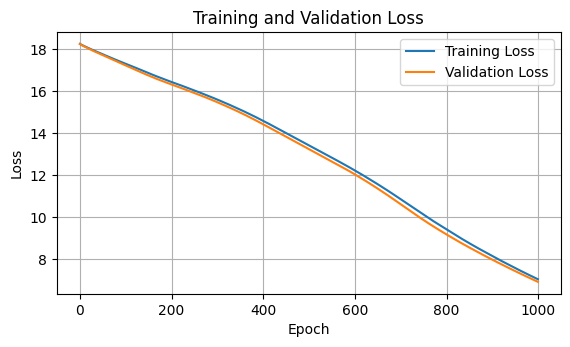

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.001
Epoch: 10, Train Loss: 17.7577, Val Loss: 17.6588, best model epoch: 10
Epoch: 20, Train Loss: 17.2109, Val Loss: 17.0806, best model epoch: 20
Epoch: 30, Train Loss: 16.5621, Val Loss: 16.3884, best model epoch: 30
Epoch: 40, Train Loss: 15.8053, Val Loss: 15.6078, best model epoch: 40
Epoch: 50, Train Loss: 14.9292, Val Loss: 14.7058, best model epoch: 50
Epoch: 60, Train Loss: 13.9314, Val Loss: 13.6942, best model epoch: 60
Epoch: 70, Train Loss: 12.8361, Val Loss: 12.5809, best model epoch: 70
Epoch: 80, Train Loss: 11.6461, Val Loss: 11.3786, best model epoch: 80
Epoch: 90, Train Loss: 10.3887, Val Loss: 10.1192, best model epoch: 90
Epoch: 100, Train Loss: 9.1162, Val Loss: 8.8580, best model epoch: 100
Epoch: 110, Train Loss: 7.8741, Val Loss: 7.6358, best model epoch: 110
Epoch: 120, Train Loss: 6.6929, Val Loss: 6.4795, best model epoch: 120
Epoch: 130, Train Loss: 5.6079, Val Loss: 5.4195, best model epoch: 130
Epoch: 140, Trai

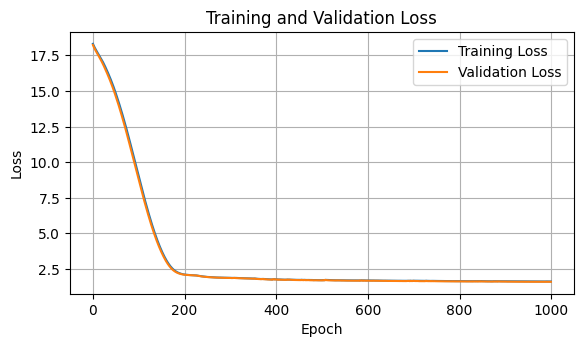

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 18.1878, Val Loss: 18.0952, best model epoch: 10
Epoch: 20, Train Loss: 17.8723, Val Loss: 17.7597, best model epoch: 20
Epoch: 30, Train Loss: 17.5468, Val Loss: 17.4212, best model epoch: 30
Epoch: 40, Train Loss: 17.2204, Val Loss: 17.0725, best model epoch: 40
Epoch: 50, Train Loss: 16.8776, Val Loss: 16.7117, best model epoch: 50
Epoch: 60, Train Loss: 16.5170, Val Loss: 16.3370, best model epoch: 60
Epoch: 70, Train Loss: 16.1430, Val Loss: 15.9512, best model epoch: 70
Epoch: 80, Train Loss: 15.7499, Val Loss: 15.5495, best model epoch: 80
Epoch: 90, Train Loss: 15.3312, Val Loss: 15.1229, best model epoch: 90
Epoch: 100, Train Loss: 14.8831, Val Loss: 14.6683, best model epoch: 100
Epoch: 110, Train Loss: 14.4072, Val Loss: 14.1816, best model epoch: 110
Epoch: 120, Train Loss: 13.8961, Val Loss: 13.6622, best model epoch: 120
Epoch: 130, Train Loss: 13.3565, Val Loss: 13.1134, best model epoch: 130
Epoch: 

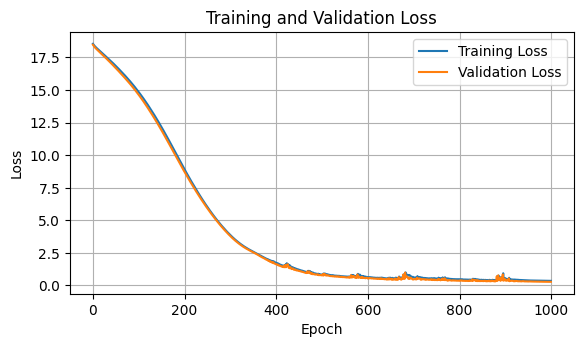

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.0001
Epoch: 10, Train Loss: 18.2741, Val Loss: 18.2371, best model epoch: 10
Epoch: 20, Train Loss: 18.1744, Val Loss: 18.1211, best model epoch: 20
Epoch: 30, Train Loss: 18.0821, Val Loss: 18.0150, best model epoch: 30
Epoch: 40, Train Loss: 18.0001, Val Loss: 17.9243, best model epoch: 40
Epoch: 50, Train Loss: 17.9229, Val Loss: 17.8399, best model epoch: 50
Epoch: 60, Train Loss: 17.8469, Val Loss: 17.7587, best model epoch: 60
Epoch: 70, Train Loss: 17.7727, Val Loss: 17.6790, best model epoch: 70
Epoch: 80, Train Loss: 17.6988, Val Loss: 17.6005, best model epoch: 80
Epoch: 90, Train Loss: 17.6254, Val Loss: 17.5233, best model epoch: 90
Epoch: 100, Train Loss: 17.5522, Val Loss: 17.4466, best model epoch: 100
Epoch: 110, Train Loss: 17.4780, Val Loss: 17.3695, best model epoch: 110
Epoch: 120, Train Loss: 17.4022, Val Loss: 17.2913, best model epoch: 120
Epoch: 130, Train Loss: 17.3267, Val Loss: 17.2123, best model epoch: 130
Epoch: 

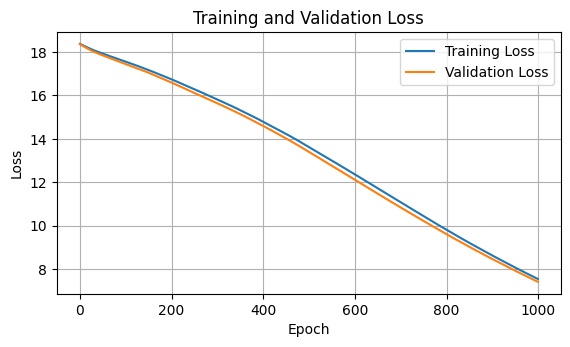

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.3920, Val Loss: 17.2731, best model epoch: 10
Epoch: 20, Train Loss: 16.3562, Val Loss: 16.2316, best model epoch: 20
Epoch: 30, Train Loss: 15.2500, Val Loss: 15.1065, best model epoch: 30
Epoch: 40, Train Loss: 14.0025, Val Loss: 13.8299, best model epoch: 40
Epoch: 50, Train Loss: 12.5563, Val Loss: 12.3591, best model epoch: 50
Epoch: 60, Train Loss: 10.9604, Val Loss: 10.7459, best model epoch: 60
Epoch: 70, Train Loss: 9.2682, Val Loss: 9.0455, best model epoch: 70
Epoch: 80, Train Loss: 7.5495, Val Loss: 7.3261, best model epoch: 80
Epoch: 90, Train Loss: 5.8905, Val Loss: 5.6801, best model epoch: 90
Epoch: 100, Train Loss: 4.4242, Val Loss: 4.2443, best model epoch: 100
Epoch: 110, Train Loss: 3.2749, Val Loss: 3.1429, best model epoch: 110
Epoch: 120, Train Loss: 2.5295, Val Loss: 2.4521, best model epoch: 120
Epoch: 130, Train Loss: 2.1738, Val Loss: 2.1421, best model epoch: 130
Epoch: 140, Train Los

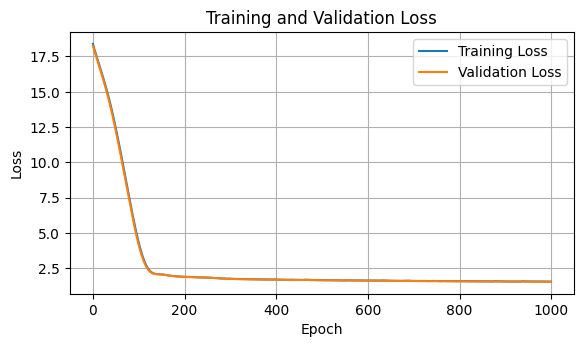

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.0005
Epoch: 10, Train Loss: 18.5286, Val Loss: 18.4761, best model epoch: 10
Epoch: 20, Train Loss: 18.0833, Val Loss: 18.0276, best model epoch: 20
Epoch: 30, Train Loss: 17.6434, Val Loss: 17.5794, best model epoch: 30
Epoch: 40, Train Loss: 17.1780, Val Loss: 17.1015, best model epoch: 40
Epoch: 50, Train Loss: 16.6701, Val Loss: 16.5807, best model epoch: 50
Epoch: 60, Train Loss: 16.1169, Val Loss: 16.0134, best model epoch: 60
Epoch: 70, Train Loss: 15.5172, Val Loss: 15.3971, best model epoch: 70
Epoch: 80, Train Loss: 14.8654, Val Loss: 14.7285, best model epoch: 80
Epoch: 90, Train Loss: 14.1426, Val Loss: 13.9885, best model epoch: 90
Epoch: 100, Train Loss: 13.3362, Val Loss: 13.1562, best model epoch: 100
Epoch: 110, Train Loss: 12.4627, Val Loss: 12.2677, best model epoch: 110
Epoch: 120, Train Loss: 11.5667, Val Loss: 11.3727, best model epoch: 120
Epoch: 130, Train Loss: 10.6578, Val Loss: 10.4720, best model epoch: 130
Epoch:

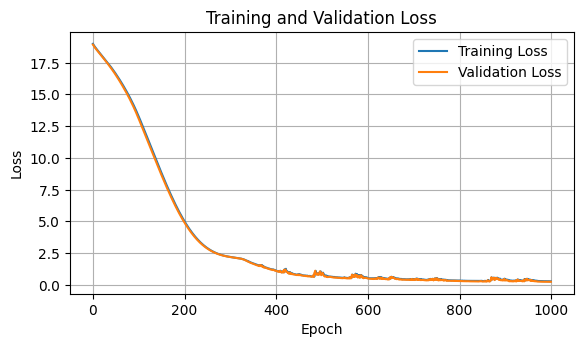

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 18.0491, Val Loss: 18.0348, best model epoch: 10
Epoch: 20, Train Loss: 17.9395, Val Loss: 17.9236, best model epoch: 20
Epoch: 30, Train Loss: 17.8370, Val Loss: 17.8203, best model epoch: 30
Epoch: 40, Train Loss: 17.7448, Val Loss: 17.7274, best model epoch: 40
Epoch: 50, Train Loss: 17.6542, Val Loss: 17.6355, best model epoch: 50
Epoch: 60, Train Loss: 17.5645, Val Loss: 17.5443, best model epoch: 60
Epoch: 70, Train Loss: 17.4728, Val Loss: 17.4509, best model epoch: 70
Epoch: 80, Train Loss: 17.3815, Val Loss: 17.3585, best model epoch: 80
Epoch: 90, Train Loss: 17.2914, Val Loss: 17.2675, best model epoch: 90
Epoch: 100, Train Loss: 17.1976, Val Loss: 17.1705, best model epoch: 100
Epoch: 110, Train Loss: 17.0981, Val Loss: 17.0678, best model epoch: 110
Epoch: 120, Train Loss: 16.9953, Val Loss: 16.9613, best model epoch: 120
Epoch: 130, Train Loss: 16.8895, Val Loss: 16.8510, best model epoch: 130
Epoch:

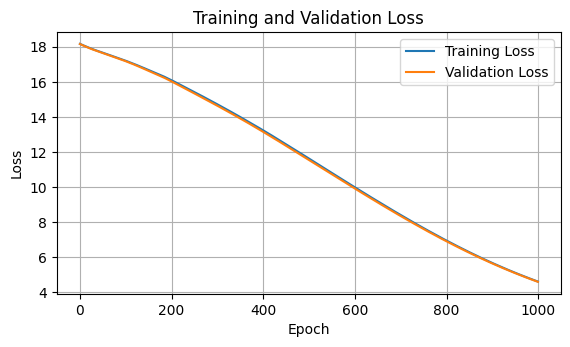

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 17.0686, Val Loss: 16.9506, best model epoch: 10
Epoch: 20, Train Loss: 16.1802, Val Loss: 16.0331, best model epoch: 20
Epoch: 30, Train Loss: 15.1723, Val Loss: 14.9922, best model epoch: 30
Epoch: 40, Train Loss: 13.9980, Val Loss: 13.7834, best model epoch: 40
Epoch: 50, Train Loss: 12.6665, Val Loss: 12.4279, best model epoch: 50
Epoch: 60, Train Loss: 11.1780, Val Loss: 10.9212, best model epoch: 60
Epoch: 70, Train Loss: 9.5806, Val Loss: 9.3149, best model epoch: 70
Epoch: 80, Train Loss: 7.9285, Val Loss: 7.6583, best model epoch: 80
Epoch: 90, Train Loss: 6.2862, Val Loss: 6.0110, best model epoch: 90
Epoch: 100, Train Loss: 4.7758, Val Loss: 4.5283, best model epoch: 100
Epoch: 110, Train Loss: 3.5560, Val Loss: 3.3801, best model epoch: 110
Epoch: 120, Train Loss: 2.7320, Val Loss: 2.6319, best model epoch: 120
Epoch: 130, Train Loss: 2.2814, Val Loss: 2.2350, best model epoch: 130
Epoch: 140, Train Los

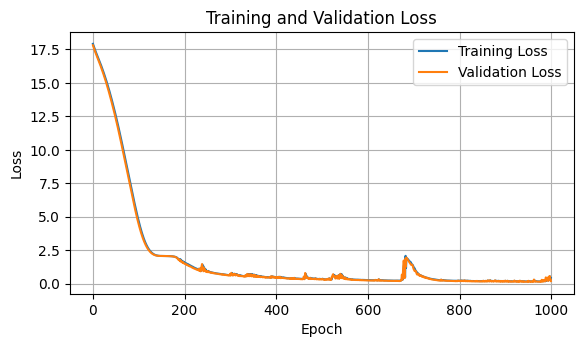

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.0005
Epoch: 10, Train Loss: 17.5104, Val Loss: 17.4274, best model epoch: 10
Epoch: 20, Train Loss: 17.0291, Val Loss: 16.9256, best model epoch: 20
Epoch: 30, Train Loss: 16.5570, Val Loss: 16.4388, best model epoch: 30
Epoch: 40, Train Loss: 16.0907, Val Loss: 15.9589, best model epoch: 40
Epoch: 50, Train Loss: 15.5937, Val Loss: 15.4482, best model epoch: 50
Epoch: 60, Train Loss: 15.0545, Val Loss: 14.8961, best model epoch: 60
Epoch: 70, Train Loss: 14.4724, Val Loss: 14.3082, best model epoch: 70
Epoch: 80, Train Loss: 13.8493, Val Loss: 13.6841, best model epoch: 80
Epoch: 90, Train Loss: 13.1880, Val Loss: 13.0233, best model epoch: 90
Epoch: 100, Train Loss: 12.4850, Val Loss: 12.3205, best model epoch: 100
Epoch: 110, Train Loss: 11.7416, Val Loss: 11.5778, best model epoch: 110
Epoch: 120, Train Loss: 10.9604, Val Loss: 10.7986, best model epoch: 120
Epoch: 130, Train Loss: 10.1396, Val Loss: 9.9759, best model epoch: 130
Epoch: 

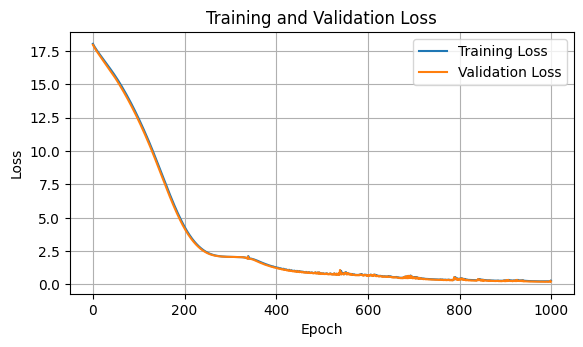

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.5909, Val Loss: 18.5749, best model epoch: 10
Epoch: 20, Train Loss: 18.4919, Val Loss: 18.4713, best model epoch: 20
Epoch: 30, Train Loss: 18.3954, Val Loss: 18.3701, best model epoch: 30
Epoch: 40, Train Loss: 18.3002, Val Loss: 18.2702, best model epoch: 40
Epoch: 50, Train Loss: 18.2050, Val Loss: 18.1699, best model epoch: 50
Epoch: 60, Train Loss: 18.1088, Val Loss: 18.0682, best model epoch: 60
Epoch: 70, Train Loss: 18.0120, Val Loss: 17.9644, best model epoch: 70
Epoch: 80, Train Loss: 17.9137, Val Loss: 17.8584, best model epoch: 80
Epoch: 90, Train Loss: 17.8124, Val Loss: 17.7461, best model epoch: 90
Epoch: 100, Train Loss: 17.7066, Val Loss: 17.6332, best model epoch: 100
Epoch: 110, Train Loss: 17.6008, Val Loss: 17.5193, best model epoch: 110
Epoch: 120, Train Loss: 17.4964, Val Loss: 17.4083, best model epoch: 120
Epoch: 130, Train Loss: 17.3937, Val Loss: 17.2990, best model epoch: 130
Epoch:

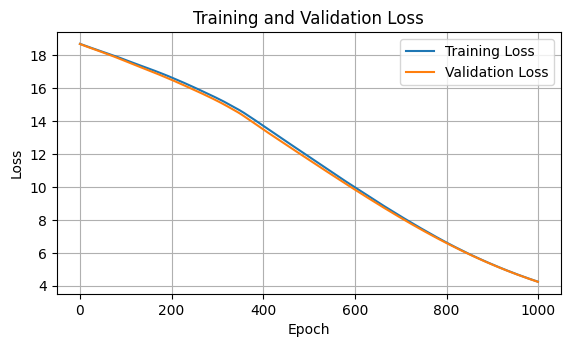

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.001
Epoch: 10, Train Loss: 17.1034, Val Loss: 16.9500, best model epoch: 10
Epoch: 20, Train Loss: 16.2089, Val Loss: 16.0296, best model epoch: 20
Epoch: 30, Train Loss: 15.2018, Val Loss: 15.0024, best model epoch: 30
Epoch: 40, Train Loss: 14.0358, Val Loss: 13.8112, best model epoch: 40
Epoch: 50, Train Loss: 12.6699, Val Loss: 12.4107, best model epoch: 50
Epoch: 60, Train Loss: 11.1089, Val Loss: 10.8285, best model epoch: 60
Epoch: 70, Train Loss: 9.4301, Val Loss: 9.1568, best model epoch: 70
Epoch: 80, Train Loss: 7.7402, Val Loss: 7.4923, best model epoch: 80
Epoch: 90, Train Loss: 6.1435, Val Loss: 5.9249, best model epoch: 90
Epoch: 100, Train Loss: 4.7253, Val Loss: 4.5356, best model epoch: 100
Epoch: 110, Train Loss: 3.5723, Val Loss: 3.4228, best model epoch: 110
Epoch: 120, Train Loss: 2.7550, Val Loss: 2.6548, best model epoch: 120
Epoch: 130, Train Loss: 2.2747, Val Loss: 2.2209, best model epoch: 130
Epoch: 140, Train Los

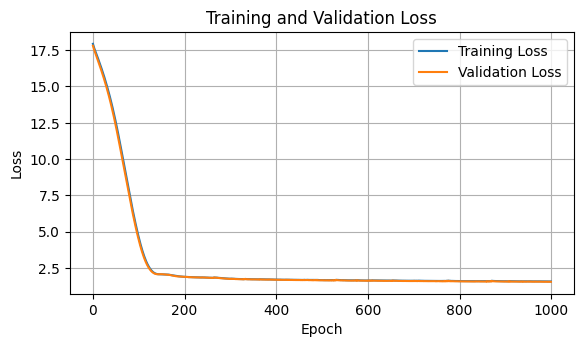

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.6441, Val Loss: 17.5586, best model epoch: 10
Epoch: 20, Train Loss: 17.2443, Val Loss: 17.1423, best model epoch: 20
Epoch: 30, Train Loss: 16.8234, Val Loss: 16.7037, best model epoch: 30
Epoch: 40, Train Loss: 16.3771, Val Loss: 16.2409, best model epoch: 40
Epoch: 50, Train Loss: 15.8928, Val Loss: 15.7481, best model epoch: 50
Epoch: 60, Train Loss: 15.3603, Val Loss: 15.2098, best model epoch: 60
Epoch: 70, Train Loss: 14.7750, Val Loss: 14.6209, best model epoch: 70
Epoch: 80, Train Loss: 14.1384, Val Loss: 13.9800, best model epoch: 80
Epoch: 90, Train Loss: 13.4490, Val Loss: 13.2843, best model epoch: 90
Epoch: 100, Train Loss: 12.7062, Val Loss: 12.5340, best model epoch: 100
Epoch: 110, Train Loss: 11.9099, Val Loss: 11.7284, best model epoch: 110
Epoch: 120, Train Loss: 11.0614, Val Loss: 10.8689, best model epoch: 120
Epoch: 130, Train Loss: 10.1780, Val Loss: 9.9743, best model epoch: 130
Epoch: 

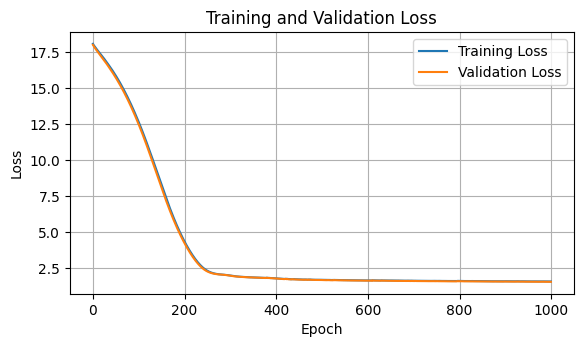

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.0001
Epoch: 10, Train Loss: 18.3576, Val Loss: 18.3301, best model epoch: 10
Epoch: 20, Train Loss: 18.2502, Val Loss: 18.2075, best model epoch: 20
Epoch: 30, Train Loss: 18.1530, Val Loss: 18.1021, best model epoch: 30
Epoch: 40, Train Loss: 18.0628, Val Loss: 18.0059, best model epoch: 40
Epoch: 50, Train Loss: 17.9740, Val Loss: 17.9087, best model epoch: 50
Epoch: 60, Train Loss: 17.8805, Val Loss: 17.8060, best model epoch: 60
Epoch: 70, Train Loss: 17.7881, Val Loss: 17.7045, best model epoch: 70
Epoch: 80, Train Loss: 17.6991, Val Loss: 17.6056, best model epoch: 80
Epoch: 90, Train Loss: 17.6113, Val Loss: 17.5103, best model epoch: 90
Epoch: 100, Train Loss: 17.5231, Val Loss: 17.4134, best model epoch: 100
Epoch: 110, Train Loss: 17.4327, Val Loss: 17.3150, best model epoch: 110
Epoch: 120, Train Loss: 17.3431, Val Loss: 17.2163, best model epoch: 120
Epoch: 130, Train Loss: 17.2514, Val Loss: 17.1136, best model epoch: 130
Epoch:

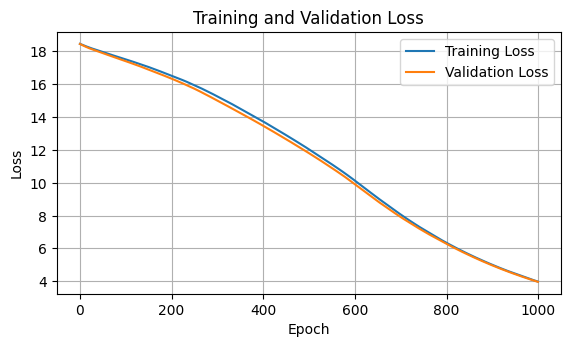

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.3649, Val Loss: 17.2510, best model epoch: 10
Epoch: 20, Train Loss: 16.2114, Val Loss: 16.0698, best model epoch: 20
Epoch: 30, Train Loss: 14.7676, Val Loss: 14.5884, best model epoch: 30
Epoch: 40, Train Loss: 12.9860, Val Loss: 12.7680, best model epoch: 40
Epoch: 50, Train Loss: 10.9056, Val Loss: 10.6582, best model epoch: 50
Epoch: 60, Train Loss: 8.6432, Val Loss: 8.3856, best model epoch: 60
Epoch: 70, Train Loss: 6.4121, Val Loss: 6.1696, best model epoch: 70
Epoch: 80, Train Loss: 4.4469, Val Loss: 4.2455, best model epoch: 80
Epoch: 90, Train Loss: 3.0097, Val Loss: 2.8775, best model epoch: 90
Epoch: 100, Train Loss: 2.2582, Val Loss: 2.2055, best model epoch: 100
Epoch: 110, Train Loss: 2.0602, Val Loss: 2.0573, best model epoch: 110
Epoch: 120, Train Loss: 2.0466, Val Loss: 2.0410, best model epoch: 120
Epoch: 130, Train Loss: 1.9663, Val Loss: 1.9595, best model epoch: 130
Epoch: 140, Train Loss:

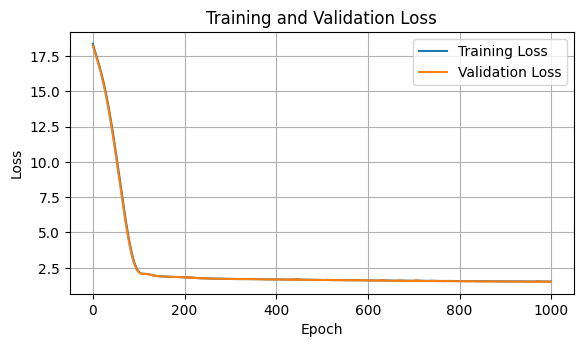

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.0005
Epoch: 10, Train Loss: 17.9852, Val Loss: 17.9106, best model epoch: 10
Epoch: 20, Train Loss: 17.3462, Val Loss: 17.2672, best model epoch: 20
Epoch: 30, Train Loss: 16.6675, Val Loss: 16.5745, best model epoch: 30
Epoch: 40, Train Loss: 15.8965, Val Loss: 15.7836, best model epoch: 40
Epoch: 50, Train Loss: 15.0260, Val Loss: 14.8949, best model epoch: 50
Epoch: 60, Train Loss: 14.0707, Val Loss: 13.9186, best model epoch: 60
Epoch: 70, Train Loss: 13.0116, Val Loss: 12.8345, best model epoch: 70
Epoch: 80, Train Loss: 11.8375, Val Loss: 11.6303, best model epoch: 80
Epoch: 90, Train Loss: 10.5814, Val Loss: 10.3533, best model epoch: 90
Epoch: 100, Train Loss: 9.2789, Val Loss: 9.0435, best model epoch: 100
Epoch: 110, Train Loss: 7.9816, Val Loss: 7.7516, best model epoch: 110
Epoch: 120, Train Loss: 6.7560, Val Loss: 6.5557, best model epoch: 120
Epoch: 130, Train Loss: 5.6449, Val Loss: 5.4771, best model epoch: 130
Epoch: 140, Tr

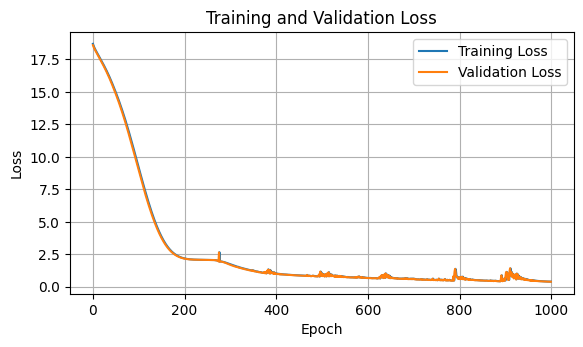

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 18.5477, Val Loss: 18.5285, best model epoch: 10
Epoch: 20, Train Loss: 18.3939, Val Loss: 18.3729, best model epoch: 20
Epoch: 30, Train Loss: 18.2445, Val Loss: 18.2220, best model epoch: 30
Epoch: 40, Train Loss: 18.0986, Val Loss: 18.0744, best model epoch: 40
Epoch: 50, Train Loss: 17.9516, Val Loss: 17.9238, best model epoch: 50
Epoch: 60, Train Loss: 17.7991, Val Loss: 17.7680, best model epoch: 60
Epoch: 70, Train Loss: 17.6457, Val Loss: 17.6112, best model epoch: 70
Epoch: 80, Train Loss: 17.4874, Val Loss: 17.4490, best model epoch: 80
Epoch: 90, Train Loss: 17.3246, Val Loss: 17.2827, best model epoch: 90
Epoch: 100, Train Loss: 17.1589, Val Loss: 17.1159, best model epoch: 100
Epoch: 110, Train Loss: 16.9951, Val Loss: 16.9500, best model epoch: 110
Epoch: 120, Train Loss: 16.8297, Val Loss: 16.7820, best model epoch: 120
Epoch: 130, Train Loss: 16.6601, Val Loss: 16.6090, best model epoch: 130
Epoch:

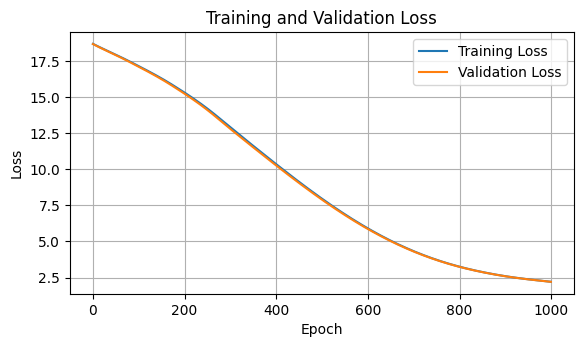

hidden_dim: 256 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 16.9573, Val Loss: 16.8184, best model epoch: 10
Epoch: 20, Train Loss: 15.8557, Val Loss: 15.6982, best model epoch: 20
Epoch: 30, Train Loss: 14.5985, Val Loss: 14.4103, best model epoch: 30
Epoch: 40, Train Loss: 13.0758, Val Loss: 12.8435, best model epoch: 40
Epoch: 50, Train Loss: 11.2649, Val Loss: 10.9994, best model epoch: 50
Epoch: 60, Train Loss: 9.2617, Val Loss: 8.9877, best model epoch: 60
Epoch: 70, Train Loss: 7.2267, Val Loss: 6.9677, best model epoch: 70
Epoch: 80, Train Loss: 5.3402, Val Loss: 5.1137, best model epoch: 80
Epoch: 90, Train Loss: 3.7877, Val Loss: 3.6153, best model epoch: 90
Epoch: 100, Train Loss: 2.7217, Val Loss: 2.6173, best model epoch: 100
Epoch: 110, Train Loss: 2.1862, Val Loss: 2.1455, best model epoch: 110
Epoch: 120, Train Loss: 2.0583, Val Loss: 2.0591, best model epoch: 119
Epoch: 130, Train Loss: 2.0576, Val Loss: 2.0554, best model epoch: 130
Epoch: 140, Train Loss:

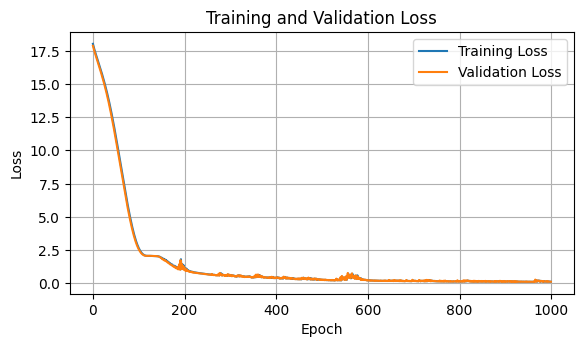

hidden_dim: 256 | dropout_prob: 0.3  | lr: 0.0005
Epoch: 10, Train Loss: 17.4773, Val Loss: 17.3999, best model epoch: 10
Epoch: 20, Train Loss: 16.9217, Val Loss: 16.8317, best model epoch: 20
Epoch: 30, Train Loss: 16.3059, Val Loss: 16.1913, best model epoch: 30
Epoch: 40, Train Loss: 15.5875, Val Loss: 15.4396, best model epoch: 40
Epoch: 50, Train Loss: 14.7551, Val Loss: 14.5745, best model epoch: 50
Epoch: 60, Train Loss: 13.8102, Val Loss: 13.5951, best model epoch: 60
Epoch: 70, Train Loss: 12.7425, Val Loss: 12.4908, best model epoch: 70
Epoch: 80, Train Loss: 11.5691, Val Loss: 11.2894, best model epoch: 80
Epoch: 90, Train Loss: 10.3242, Val Loss: 10.0344, best model epoch: 90
Epoch: 100, Train Loss: 9.0357, Val Loss: 8.7408, best model epoch: 100
Epoch: 110, Train Loss: 7.7208, Val Loss: 7.4171, best model epoch: 110
Epoch: 120, Train Loss: 6.4194, Val Loss: 6.1272, best model epoch: 120
Epoch: 130, Train Loss: 5.2119, Val Loss: 4.9738, best model epoch: 130
Epoch: 140, Tr

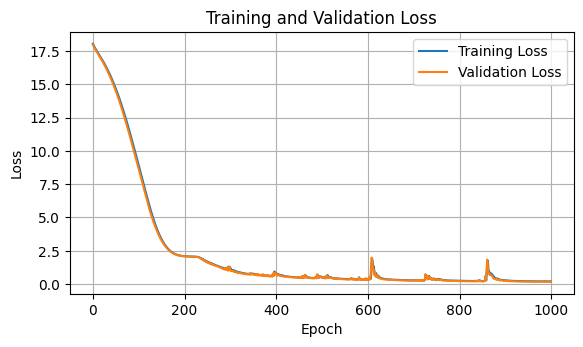

hidden_dim: 256 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.4968, Val Loss: 18.4701, best model epoch: 10
Epoch: 20, Train Loss: 18.3506, Val Loss: 18.3191, best model epoch: 20
Epoch: 30, Train Loss: 18.2106, Val Loss: 18.1734, best model epoch: 30
Epoch: 40, Train Loss: 18.0737, Val Loss: 18.0308, best model epoch: 40
Epoch: 50, Train Loss: 17.9397, Val Loss: 17.8904, best model epoch: 50
Epoch: 60, Train Loss: 17.8085, Val Loss: 17.7537, best model epoch: 60
Epoch: 70, Train Loss: 17.6776, Val Loss: 17.6175, best model epoch: 70
Epoch: 80, Train Loss: 17.5460, Val Loss: 17.4795, best model epoch: 80
Epoch: 90, Train Loss: 17.4121, Val Loss: 17.3391, best model epoch: 90
Epoch: 100, Train Loss: 17.2763, Val Loss: 17.1988, best model epoch: 100
Epoch: 110, Train Loss: 17.1392, Val Loss: 17.0581, best model epoch: 110
Epoch: 120, Train Loss: 16.9998, Val Loss: 16.9161, best model epoch: 120
Epoch: 130, Train Loss: 16.8579, Val Loss: 16.7713, best model epoch: 130
Epoch:

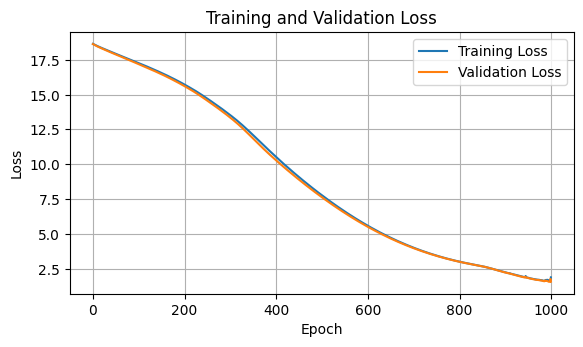

hidden_dim: 256 | dropout_prob: 0.5  | lr: 0.001
Epoch: 10, Train Loss: 16.7005, Val Loss: 16.5387, best model epoch: 10
Epoch: 20, Train Loss: 15.5084, Val Loss: 15.3088, best model epoch: 20
Epoch: 30, Train Loss: 14.0718, Val Loss: 13.8311, best model epoch: 30
Epoch: 40, Train Loss: 12.3215, Val Loss: 12.0430, best model epoch: 40
Epoch: 50, Train Loss: 10.2927, Val Loss: 9.9913, best model epoch: 50
Epoch: 60, Train Loss: 8.1086, Val Loss: 7.8071, best model epoch: 60
Epoch: 70, Train Loss: 5.9760, Val Loss: 5.7068, best model epoch: 70
Epoch: 80, Train Loss: 4.1656, Val Loss: 3.9643, best model epoch: 80
Epoch: 90, Train Loss: 2.9011, Val Loss: 2.7804, best model epoch: 90
Epoch: 100, Train Loss: 2.2511, Val Loss: 2.2022, best model epoch: 100
Epoch: 110, Train Loss: 2.0647, Val Loss: 2.0594, best model epoch: 110
Epoch: 120, Train Loss: 2.0668, Val Loss: 2.0712, best model epoch: 111
Epoch: 130, Train Loss: 2.0602, Val Loss: 2.0574, best model epoch: 130
Epoch: 140, Train Loss: 

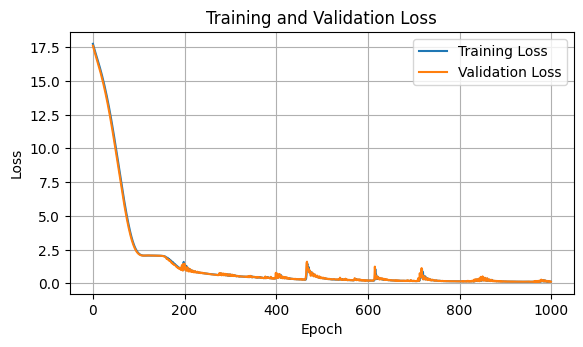

hidden_dim: 256 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.1054, Val Loss: 17.0120, best model epoch: 10
Epoch: 20, Train Loss: 16.5470, Val Loss: 16.4343, best model epoch: 20
Epoch: 30, Train Loss: 15.9403, Val Loss: 15.8093, best model epoch: 30
Epoch: 40, Train Loss: 15.2658, Val Loss: 15.1177, best model epoch: 40
Epoch: 50, Train Loss: 14.5012, Val Loss: 14.3383, best model epoch: 50
Epoch: 60, Train Loss: 13.6343, Val Loss: 13.4579, best model epoch: 60
Epoch: 70, Train Loss: 12.6644, Val Loss: 12.4787, best model epoch: 70
Epoch: 80, Train Loss: 11.6019, Val Loss: 11.4092, best model epoch: 80
Epoch: 90, Train Loss: 10.4635, Val Loss: 10.2623, best model epoch: 90
Epoch: 100, Train Loss: 9.2653, Val Loss: 9.0537, best model epoch: 100
Epoch: 110, Train Loss: 8.0311, Val Loss: 7.8118, best model epoch: 110
Epoch: 120, Train Loss: 6.8164, Val Loss: 6.6108, best model epoch: 120
Epoch: 130, Train Loss: 5.6907, Val Loss: 5.5136, best model epoch: 130
Epoch: 140, Tr

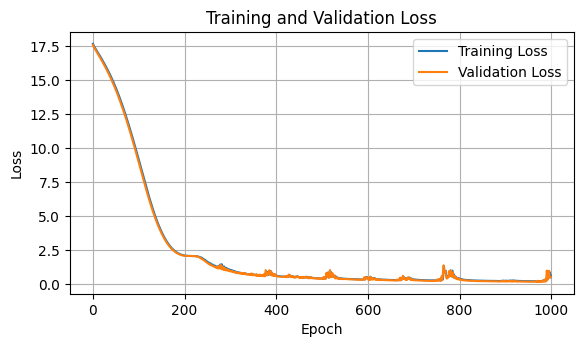

hidden_dim: 256 | dropout_prob: 0.5  | lr: 0.0001
Epoch: 10, Train Loss: 18.2439, Val Loss: 18.2155, best model epoch: 10
Epoch: 20, Train Loss: 18.1200, Val Loss: 18.0816, best model epoch: 20
Epoch: 30, Train Loss: 18.0000, Val Loss: 17.9536, best model epoch: 30
Epoch: 40, Train Loss: 17.8785, Val Loss: 17.8257, best model epoch: 40
Epoch: 50, Train Loss: 17.7576, Val Loss: 17.6980, best model epoch: 50
Epoch: 60, Train Loss: 17.6344, Val Loss: 17.5673, best model epoch: 60
Epoch: 70, Train Loss: 17.5081, Val Loss: 17.4351, best model epoch: 70
Epoch: 80, Train Loss: 17.3791, Val Loss: 17.3002, best model epoch: 80
Epoch: 90, Train Loss: 17.2461, Val Loss: 17.1612, best model epoch: 90
Epoch: 100, Train Loss: 17.1067, Val Loss: 17.0144, best model epoch: 100
Epoch: 110, Train Loss: 16.9598, Val Loss: 16.8601, best model epoch: 110
Epoch: 120, Train Loss: 16.8058, Val Loss: 16.6988, best model epoch: 120
Epoch: 130, Train Loss: 16.6455, Val Loss: 16.5312, best model epoch: 130
Epoch:

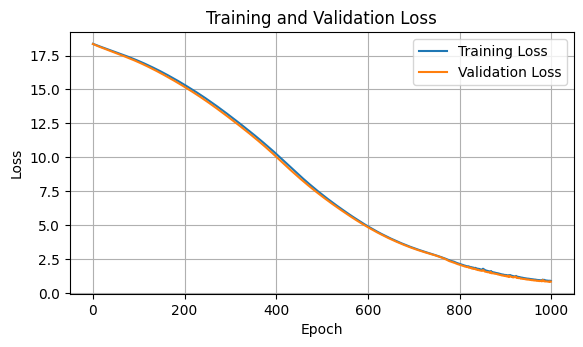

In [ ]:
# GAT grid search
GAT_results = []
for indx, row in GAT_grid_params.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GAT_results.append(run_GAT_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs))

In [ ]:
pd.DataFrame(GAT_results).to_excel('GAT_results.xlsx')
pd.DataFrame(GAT_results)

hidden_dim  dropout_prob      lr  best test loss  best test loss epoch  \
0           16           0.1  0.0010        0.371372                   903   
1           16           0.1  0.0005        2.469716                  1000   
2           16           0.1  0.0001       13.366374                  1000   
3           16           0.3  0.0010        0.248999                   999   
4           16           0.3  0.0005        2.114984                  1000   
5           16           0.3  0.0001       13.763688                  1000   
6           16           0.5  0.0010        1.697986                   974   
7           16           0.5  0.0005        0.816228                  1000   
8           16           0.5  0.0001        9.671947                  1000   
9           32           0.1  0.0010        0.276405                   933   
10          32           0.1  0.0005        0.394236                  1000   
11          32           0.1  0.0001        9.675983                  1000   
12          32           0.3  0.0010        1.628989                   996   
13          32           0.3  0.0005        1.699240                  1000   
14          32           0.3  0.0001       10.136342                  1000   
15          32           0.5  0.0010        0.211188                   977   
16          32           0.5  0.0005        1.658285                   995   
17          32           0.5  0.0001       10.292025                  1000   
18          64           0.1  0.0010        0.165190                  1000   
19          64           0.1  0.0005        1.626772                   983   
20          64           0.1  0.0001        6.268209                  1000   
21          64           0.3  0.0010        1.574164                   994   
22          64           0.3  0.0005        1.628552                  1000   
23          64           0.3  0.0001        6.932207                  1000   
24          64           0.5  0.0010        1.595049                   965   
25          64           0.5  0.0005        0.281549                   998   
26          64           0.5  0.0001        7.410598                  1000   
27         128           0.1  0.0010        1.523230                   998   
28         128           0.1  0.0005        0.229086                   999   
29         128           0.1  0.0001        4.584821                  1000   
30         128           0.3  0.0010        0.129582                   960   
31         128           0.3  0.0005        0.199351                   996   
32         128           0.3  0.0001        4.227051                  1000   
33         128           0.5  0.0010        1.537630                   997   
34         128           0.5  0.0005        1.572377                  1000   
35         128           0.5  0.0001        3.968199                  1000   
36         256           0.1  0.0010        1.494081                  1000   
37         256           0.1  0.0005        0.366510                   998   
38         256           0.1  0.0001        2.202734                  1000   
39         256           0.3  0.0010        0.105792                   963   
40         256           0.3  0.0005        0.160427                   996   
41         256           0.3  0.0001        1.564939                   996   
42         256           0.5  0.0010        0.116783                   964   
43         256           0.5  0.0005        0.156728                   979   
44         256           0.5  0.0001        0.832552                   996   

    corr_train_loss  
0          0.501202  
1          2.474565  
2         13.454049  
3          0.324313  
4          2.118318  
5         13.962736  
6          1.720934  
7          0.899648  
8         10.067192  
9          0.302782  
10         0.431358  
11         9.765594  
12         1.645295  
13         1.712069  
14        10.267267  
15         0.360297  
16         1.675860  
17        10.577578

More params to be tested

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.001
Epoch: 10, Train Loss: 14.9419, Val Loss: 14.7926, best model epoch: 10
Epoch: 20, Train Loss: 14.2483, Val Loss: 14.0247, best model epoch: 20
Epoch: 30, Train Loss: 13.6120, Val Loss: 13.3544, best model epoch: 30
Epoch: 40, Train Loss: 13.0711, Val Loss: 12.8074, best model epoch: 40
Epoch: 50, Train Loss: 12.5270, Val Loss: 12.2479, best model epoch: 50
Epoch: 60, Train Loss: 11.9759, Val Loss: 11.6866, best model epoch: 60
Epoch: 70, Train Loss: 11.4071, Val Loss: 11.1148, best model epoch: 70
Epoch: 80, Train Loss: 10.8243, Val Loss: 10.5320, best model epoch: 80
Epoch: 90, Train Loss: 10.2290, Val Loss: 9.9402, best model epoch: 90
Epoch: 100, Train Loss: 9.6143, Val Loss: 9.3304, best model epoch: 100
Epoch: 110, Train Loss: 8.9847, Val Loss: 8.7064, best model epoch: 110
Epoch: 120, Train Loss: 8.3474, Val Loss: 8.0791, best model epoch: 120
Epoch: 130, Train Loss: 7.7142, Val Loss: 7.4564, best model epoch: 130
Epoch: 140, Train

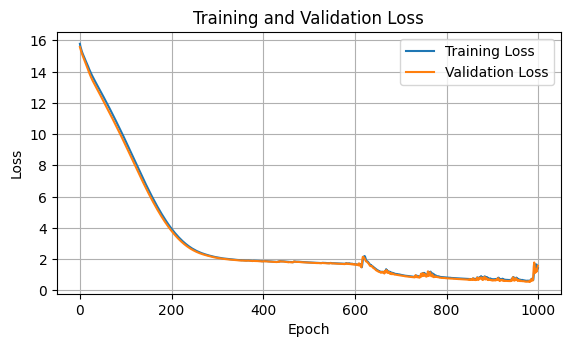

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 16.4613, Val Loss: 16.4251, best model epoch: 10
Epoch: 20, Train Loss: 16.2554, Val Loss: 16.2253, best model epoch: 20
Epoch: 30, Train Loss: 16.0787, Val Loss: 16.0464, best model epoch: 30
Epoch: 40, Train Loss: 15.9087, Val Loss: 15.8743, best model epoch: 40
Epoch: 50, Train Loss: 15.7410, Val Loss: 15.7041, best model epoch: 50
Epoch: 60, Train Loss: 15.5713, Val Loss: 15.5309, best model epoch: 60
Epoch: 70, Train Loss: 15.3986, Val Loss: 15.3528, best model epoch: 70
Epoch: 80, Train Loss: 15.2267, Val Loss: 15.1753, best model epoch: 80
Epoch: 90, Train Loss: 15.0619, Val Loss: 15.0046, best model epoch: 90
Epoch: 100, Train Loss: 14.8956, Val Loss: 14.8309, best model epoch: 100
Epoch: 110, Train Loss: 14.7236, Val Loss: 14.6516, best model epoch: 110
Epoch: 120, Train Loss: 14.5447, Val Loss: 14.4626, best model epoch: 120
Epoch: 130, Train Loss: 14.3554, Val Loss: 14.2654, best model epoch: 130
Epoch: 

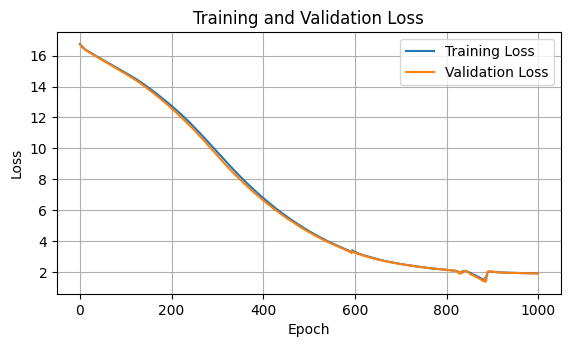

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.0001
Epoch: 10, Train Loss: 17.4375, Val Loss: 17.4021, best model epoch: 10
Epoch: 20, Train Loss: 17.3358, Val Loss: 17.2916, best model epoch: 20
Epoch: 30, Train Loss: 17.2152, Val Loss: 17.1704, best model epoch: 30
Epoch: 40, Train Loss: 17.1240, Val Loss: 17.0831, best model epoch: 40
Epoch: 50, Train Loss: 17.0507, Val Loss: 17.0048, best model epoch: 50
Epoch: 60, Train Loss: 16.9822, Val Loss: 16.9304, best model epoch: 60
Epoch: 70, Train Loss: 16.9195, Val Loss: 16.8615, best model epoch: 70
Epoch: 80, Train Loss: 16.8589, Val Loss: 16.7954, best model epoch: 80
Epoch: 90, Train Loss: 16.7973, Val Loss: 16.7281, best model epoch: 90
Epoch: 100, Train Loss: 16.7368, Val Loss: 16.6623, best model epoch: 100
Epoch: 110, Train Loss: 16.6798, Val Loss: 16.5996, best model epoch: 110
Epoch: 120, Train Loss: 16.6249, Val Loss: 16.5391, best model epoch: 120
Epoch: 130, Train Loss: 16.5723, Val Loss: 16.4802, best model epoch: 130
Epoch: 

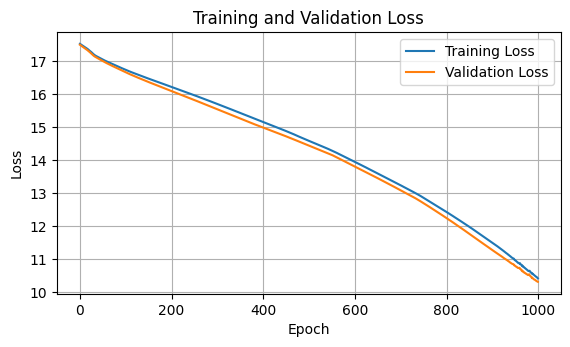

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.001
Epoch: 10, Train Loss: 18.4483, Val Loss: 18.3261, best model epoch: 10
Epoch: 20, Train Loss: 17.8075, Val Loss: 17.6683, best model epoch: 20
Epoch: 30, Train Loss: 17.1612, Val Loss: 16.9736, best model epoch: 30
Epoch: 40, Train Loss: 16.4454, Val Loss: 16.2102, best model epoch: 40
Epoch: 50, Train Loss: 15.7023, Val Loss: 15.4472, best model epoch: 50
Epoch: 60, Train Loss: 14.9637, Val Loss: 14.7080, best model epoch: 60
Epoch: 70, Train Loss: 14.2132, Val Loss: 13.9618, best model epoch: 70
Epoch: 80, Train Loss: 13.4424, Val Loss: 13.1956, best model epoch: 80
Epoch: 90, Train Loss: 12.6538, Val Loss: 12.4126, best model epoch: 90
Epoch: 100, Train Loss: 11.8527, Val Loss: 11.6187, best model epoch: 100
Epoch: 110, Train Loss: 11.0443, Val Loss: 10.8204, best model epoch: 110
Epoch: 120, Train Loss: 10.2380, Val Loss: 10.0254, best model epoch: 120
Epoch: 130, Train Loss: 9.4403, Val Loss: 9.2414, best model epoch: 130
Epoch: 140

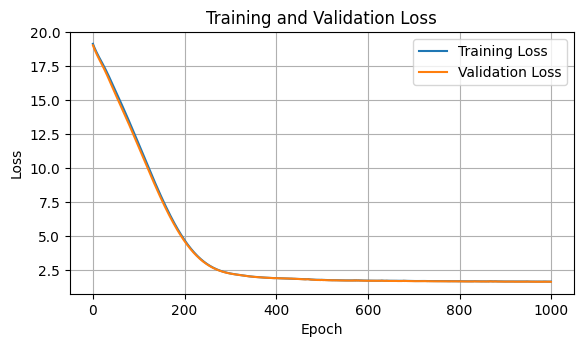

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 16.1618, Val Loss: 16.1052, best model epoch: 10
Epoch: 20, Train Loss: 15.8593, Val Loss: 15.8013, best model epoch: 20
Epoch: 30, Train Loss: 15.5787, Val Loss: 15.5118, best model epoch: 30
Epoch: 40, Train Loss: 15.2935, Val Loss: 15.2116, best model epoch: 40
Epoch: 50, Train Loss: 15.0046, Val Loss: 14.9071, best model epoch: 50
Epoch: 60, Train Loss: 14.7057, Val Loss: 14.5957, best model epoch: 60
Epoch: 70, Train Loss: 14.3963, Val Loss: 14.2714, best model epoch: 70
Epoch: 80, Train Loss: 14.0785, Val Loss: 13.9357, best model epoch: 80
Epoch: 90, Train Loss: 13.7390, Val Loss: 13.5860, best model epoch: 90
Epoch: 100, Train Loss: 13.3851, Val Loss: 13.2246, best model epoch: 100
Epoch: 110, Train Loss: 13.0178, Val Loss: 12.8519, best model epoch: 110
Epoch: 120, Train Loss: 12.6359, Val Loss: 12.4636, best model epoch: 120
Epoch: 130, Train Loss: 12.2419, Val Loss: 12.0654, best model epoch: 130
Epoch: 

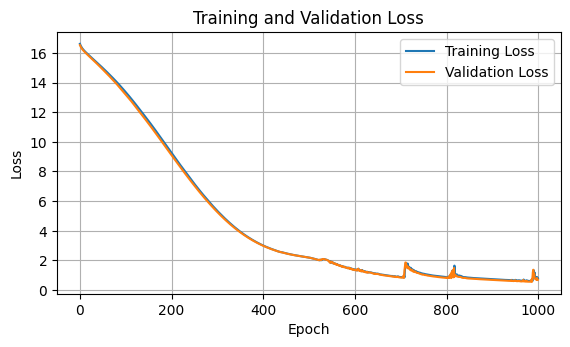

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.0001
Epoch: 10, Train Loss: 16.9157, Val Loss: 16.8946, best model epoch: 10
Epoch: 20, Train Loss: 16.8583, Val Loss: 16.8340, best model epoch: 20
Epoch: 30, Train Loss: 16.8041, Val Loss: 16.7780, best model epoch: 30
Epoch: 40, Train Loss: 16.7517, Val Loss: 16.7233, best model epoch: 40
Epoch: 50, Train Loss: 16.7008, Val Loss: 16.6726, best model epoch: 50
Epoch: 60, Train Loss: 16.6500, Val Loss: 16.6225, best model epoch: 60
Epoch: 70, Train Loss: 16.5954, Val Loss: 16.5662, best model epoch: 70
Epoch: 80, Train Loss: 16.5357, Val Loss: 16.5024, best model epoch: 80
Epoch: 90, Train Loss: 16.4705, Val Loss: 16.4323, best model epoch: 90
Epoch: 100, Train Loss: 16.3997, Val Loss: 16.3571, best model epoch: 100
Epoch: 110, Train Loss: 16.3269, Val Loss: 16.2815, best model epoch: 110
Epoch: 120, Train Loss: 16.2540, Val Loss: 16.2072, best model epoch: 120
Epoch: 130, Train Loss: 16.1835, Val Loss: 16.1348, best model epoch: 130
Epoch: 

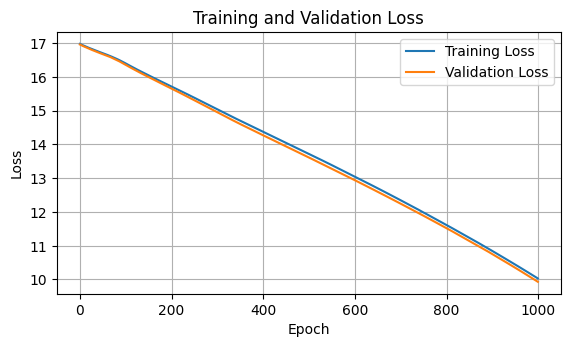

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.001
Epoch: 10, Train Loss: 18.1124, Val Loss: 18.0236, best model epoch: 10
Epoch: 20, Train Loss: 17.4237, Val Loss: 17.3116, best model epoch: 20
Epoch: 30, Train Loss: 16.6814, Val Loss: 16.5398, best model epoch: 30
Epoch: 40, Train Loss: 15.8776, Val Loss: 15.7236, best model epoch: 40
Epoch: 50, Train Loss: 15.0514, Val Loss: 14.8829, best model epoch: 50
Epoch: 60, Train Loss: 14.1550, Val Loss: 13.9741, best model epoch: 60
Epoch: 70, Train Loss: 13.1915, Val Loss: 13.0014, best model epoch: 70
Epoch: 80, Train Loss: 12.1693, Val Loss: 11.9680, best model epoch: 80
Epoch: 90, Train Loss: 11.0931, Val Loss: 10.8796, best model epoch: 90
Epoch: 100, Train Loss: 9.9481, Val Loss: 9.7165, best model epoch: 100
Epoch: 110, Train Loss: 8.7538, Val Loss: 8.5178, best model epoch: 110
Epoch: 120, Train Loss: 7.5886, Val Loss: 7.3759, best model epoch: 120
Epoch: 130, Train Loss: 6.4961, Val Loss: 6.3210, best model epoch: 130
Epoch: 140, Trai

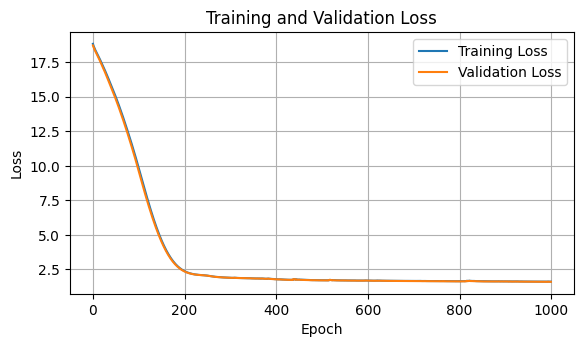

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 17.6371, Val Loss: 17.5696, best model epoch: 10
Epoch: 20, Train Loss: 17.1704, Val Loss: 17.0886, best model epoch: 20
Epoch: 30, Train Loss: 16.6965, Val Loss: 16.5995, best model epoch: 30
Epoch: 40, Train Loss: 16.2011, Val Loss: 16.0839, best model epoch: 40
Epoch: 50, Train Loss: 15.6825, Val Loss: 15.5484, best model epoch: 50
Epoch: 60, Train Loss: 15.1287, Val Loss: 14.9706, best model epoch: 60
Epoch: 70, Train Loss: 14.5262, Val Loss: 14.3412, best model epoch: 70
Epoch: 80, Train Loss: 13.8998, Val Loss: 13.6969, best model epoch: 80
Epoch: 90, Train Loss: 13.2554, Val Loss: 13.0464, best model epoch: 90
Epoch: 100, Train Loss: 12.5983, Val Loss: 12.3832, best model epoch: 100
Epoch: 110, Train Loss: 11.9193, Val Loss: 11.6955, best model epoch: 110
Epoch: 120, Train Loss: 11.2127, Val Loss: 10.9790, best model epoch: 120
Epoch: 130, Train Loss: 10.4896, Val Loss: 10.2468, best model epoch: 130
Epoch: 

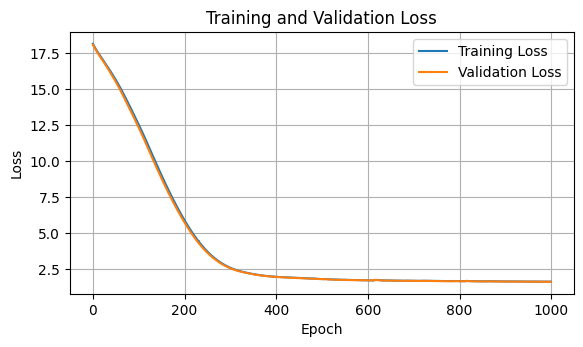

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.0001
Epoch: 10, Train Loss: 18.2604, Val Loss: 18.2325, best model epoch: 10
Epoch: 20, Train Loss: 18.1338, Val Loss: 18.0967, best model epoch: 20
Epoch: 30, Train Loss: 18.0110, Val Loss: 17.9662, best model epoch: 30
Epoch: 40, Train Loss: 17.8965, Val Loss: 17.8463, best model epoch: 40
Epoch: 50, Train Loss: 17.7906, Val Loss: 17.7354, best model epoch: 50
Epoch: 60, Train Loss: 17.6889, Val Loss: 17.6284, best model epoch: 60
Epoch: 70, Train Loss: 17.5875, Val Loss: 17.5222, best model epoch: 70
Epoch: 80, Train Loss: 17.4898, Val Loss: 17.4192, best model epoch: 80
Epoch: 90, Train Loss: 17.3926, Val Loss: 17.3143, best model epoch: 90
Epoch: 100, Train Loss: 17.2941, Val Loss: 17.2092, best model epoch: 100
Epoch: 110, Train Loss: 17.1965, Val Loss: 17.1057, best model epoch: 110
Epoch: 120, Train Loss: 17.0992, Val Loss: 17.0016, best model epoch: 120
Epoch: 130, Train Loss: 16.9999, Val Loss: 16.8958, best model epoch: 130
Epoch: 

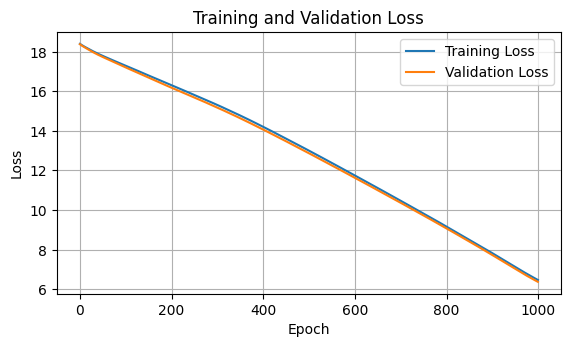

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.001
Epoch: 10, Train Loss: 17.0515, Val Loss: 16.9481, best model epoch: 10
Epoch: 20, Train Loss: 16.1997, Val Loss: 16.0703, best model epoch: 20
Epoch: 30, Train Loss: 15.2365, Val Loss: 15.0787, best model epoch: 30
Epoch: 40, Train Loss: 14.1048, Val Loss: 13.9106, best model epoch: 40
Epoch: 50, Train Loss: 12.7756, Val Loss: 12.5417, best model epoch: 50
Epoch: 60, Train Loss: 11.2474, Val Loss: 10.9773, best model epoch: 60
Epoch: 70, Train Loss: 9.5546, Val Loss: 9.2611, best model epoch: 70
Epoch: 80, Train Loss: 7.7955, Val Loss: 7.5054, best model epoch: 80
Epoch: 90, Train Loss: 6.1063, Val Loss: 5.8447, best model epoch: 90
Epoch: 100, Train Loss: 4.6206, Val Loss: 4.4091, best model epoch: 100
Epoch: 110, Train Loss: 3.4442, Val Loss: 3.2926, best model epoch: 110
Epoch: 120, Train Loss: 2.6596, Val Loss: 2.5729, best model epoch: 120
Epoch: 130, Train Loss: 2.2466, Val Loss: 2.2095, best model epoch: 130
Epoch: 140, Train Los

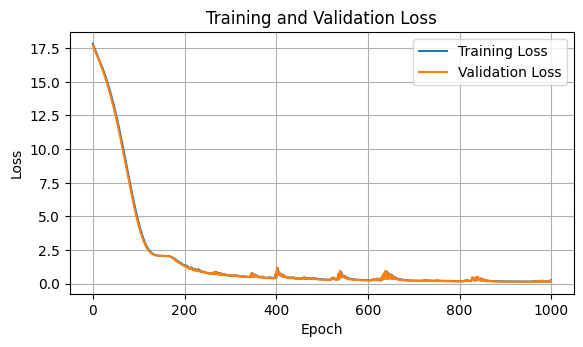

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 18.1124, Val Loss: 18.0500, best model epoch: 10
Epoch: 20, Train Loss: 17.7123, Val Loss: 17.6468, best model epoch: 20
Epoch: 30, Train Loss: 17.3277, Val Loss: 17.2533, best model epoch: 30
Epoch: 40, Train Loss: 16.9201, Val Loss: 16.8314, best model epoch: 40
Epoch: 50, Train Loss: 16.4714, Val Loss: 16.3648, best model epoch: 50
Epoch: 60, Train Loss: 15.9539, Val Loss: 15.8235, best model epoch: 60
Epoch: 70, Train Loss: 15.3480, Val Loss: 15.1850, best model epoch: 70
Epoch: 80, Train Loss: 14.6483, Val Loss: 14.4410, best model epoch: 80
Epoch: 90, Train Loss: 13.8628, Val Loss: 13.5980, best model epoch: 90
Epoch: 100, Train Loss: 12.9787, Val Loss: 12.6552, best model epoch: 100
Epoch: 110, Train Loss: 12.0395, Val Loss: 11.6870, best model epoch: 110
Epoch: 120, Train Loss: 11.1008, Val Loss: 10.7718, best model epoch: 120
Epoch: 130, Train Loss: 10.1785, Val Loss: 9.8878, best model epoch: 130
Epoch: 

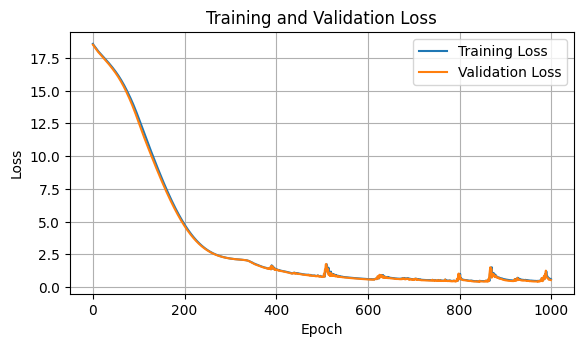

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.0001
Epoch: 10, Train Loss: 17.6844, Val Loss: 17.6667, best model epoch: 10
Epoch: 20, Train Loss: 17.5663, Val Loss: 17.5445, best model epoch: 20
Epoch: 30, Train Loss: 17.4523, Val Loss: 17.4279, best model epoch: 30
Epoch: 40, Train Loss: 17.3390, Val Loss: 17.3113, best model epoch: 40
Epoch: 50, Train Loss: 17.2264, Val Loss: 17.1987, best model epoch: 50
Epoch: 60, Train Loss: 17.1199, Val Loss: 17.0820, best model epoch: 60
Epoch: 70, Train Loss: 17.0093, Val Loss: 16.9711, best model epoch: 70
Epoch: 80, Train Loss: 16.9018, Val Loss: 16.8599, best model epoch: 80
Epoch: 90, Train Loss: 16.7937, Val Loss: 16.7501, best model epoch: 90
Epoch: 100, Train Loss: 16.6866, Val Loss: 16.6408, best model epoch: 100
Epoch: 110, Train Loss: 16.5808, Val Loss: 16.5298, best model epoch: 110
Epoch: 120, Train Loss: 16.4730, Val Loss: 16.4166, best model epoch: 120
Epoch: 130, Train Loss: 16.3601, Val Loss: 16.3001, best model epoch: 130
Epoch:

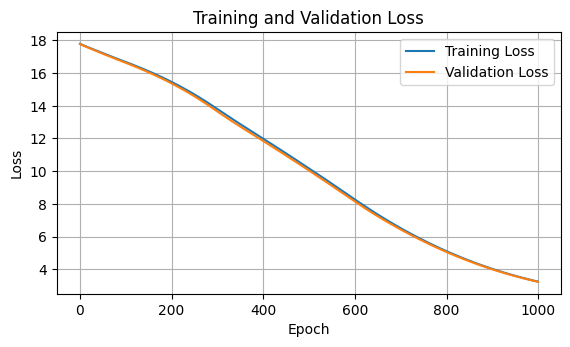

hidden_dim: 256 | dropout_prob: 0.2  | lr: 0.001
Epoch: 10, Train Loss: 17.1257, Val Loss: 17.0076, best model epoch: 10
Epoch: 20, Train Loss: 16.0344, Val Loss: 15.8915, best model epoch: 20
Epoch: 30, Train Loss: 14.7107, Val Loss: 14.5345, best model epoch: 30
Epoch: 40, Train Loss: 13.0840, Val Loss: 12.8685, best model epoch: 40
Epoch: 50, Train Loss: 11.1583, Val Loss: 10.9062, best model epoch: 50
Epoch: 60, Train Loss: 9.0189, Val Loss: 8.7442, best model epoch: 60
Epoch: 70, Train Loss: 6.8392, Val Loss: 6.5681, best model epoch: 70
Epoch: 80, Train Loss: 4.8917, Val Loss: 4.6716, best model epoch: 80
Epoch: 90, Train Loss: 3.4025, Val Loss: 3.2583, best model epoch: 90
Epoch: 100, Train Loss: 2.5095, Val Loss: 2.4388, best model epoch: 100
Epoch: 110, Train Loss: 2.1386, Val Loss: 2.1171, best model epoch: 110
Epoch: 120, Train Loss: 2.0595, Val Loss: 2.0583, best model epoch: 120
Epoch: 130, Train Loss: 2.0621, Val Loss: 2.0635, best model epoch: 121
Epoch: 140, Train Loss:

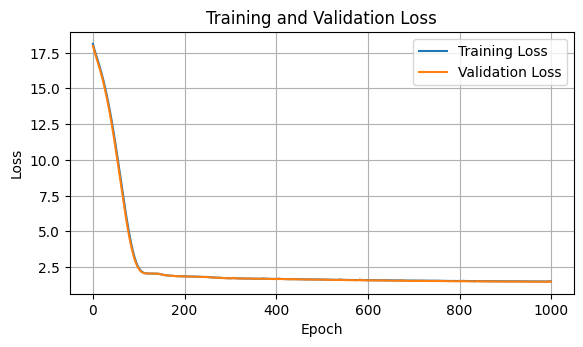

hidden_dim: 256 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 16.9890, Val Loss: 16.9153, best model epoch: 10
Epoch: 20, Train Loss: 16.4006, Val Loss: 16.3213, best model epoch: 20
Epoch: 30, Train Loss: 15.7614, Val Loss: 15.6700, best model epoch: 30
Epoch: 40, Train Loss: 15.0315, Val Loss: 14.9254, best model epoch: 40
Epoch: 50, Train Loss: 14.1941, Val Loss: 14.0710, best model epoch: 50
Epoch: 60, Train Loss: 13.2269, Val Loss: 13.0792, best model epoch: 60
Epoch: 70, Train Loss: 12.1292, Val Loss: 11.9572, best model epoch: 70
Epoch: 80, Train Loss: 10.9361, Val Loss: 10.7490, best model epoch: 80
Epoch: 90, Train Loss: 9.6891, Val Loss: 9.4947, best model epoch: 90
Epoch: 100, Train Loss: 8.4224, Val Loss: 8.2270, best model epoch: 100
Epoch: 110, Train Loss: 7.1846, Val Loss: 6.9991, best model epoch: 110
Epoch: 120, Train Loss: 6.0321, Val Loss: 5.8681, best model epoch: 120
Epoch: 130, Train Loss: 5.0113, Val Loss: 4.8735, best model epoch: 130
Epoch: 140, Trai

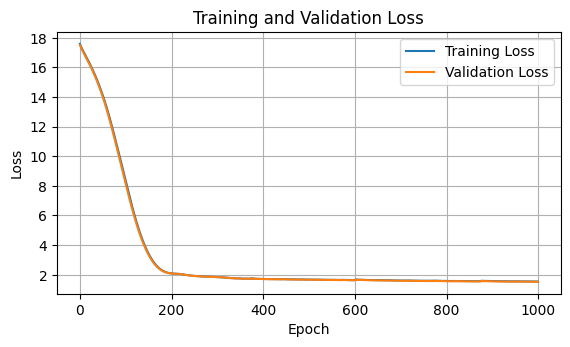

hidden_dim: 256 | dropout_prob: 0.2  | lr: 0.0001
Epoch: 10, Train Loss: 18.0066, Val Loss: 17.9846, best model epoch: 10
Epoch: 20, Train Loss: 17.8693, Val Loss: 17.8454, best model epoch: 20
Epoch: 30, Train Loss: 17.7420, Val Loss: 17.7156, best model epoch: 30
Epoch: 40, Train Loss: 17.6170, Val Loss: 17.5881, best model epoch: 40
Epoch: 50, Train Loss: 17.4911, Val Loss: 17.4593, best model epoch: 50
Epoch: 60, Train Loss: 17.3634, Val Loss: 17.3289, best model epoch: 60
Epoch: 70, Train Loss: 17.2335, Val Loss: 17.1961, best model epoch: 70
Epoch: 80, Train Loss: 17.0996, Val Loss: 17.0588, best model epoch: 80
Epoch: 90, Train Loss: 16.9611, Val Loss: 16.9171, best model epoch: 90
Epoch: 100, Train Loss: 16.8178, Val Loss: 16.7703, best model epoch: 100
Epoch: 110, Train Loss: 16.6675, Val Loss: 16.6160, best model epoch: 110
Epoch: 120, Train Loss: 16.5088, Val Loss: 16.4534, best model epoch: 120
Epoch: 130, Train Loss: 16.3430, Val Loss: 16.2830, best model epoch: 130
Epoch:

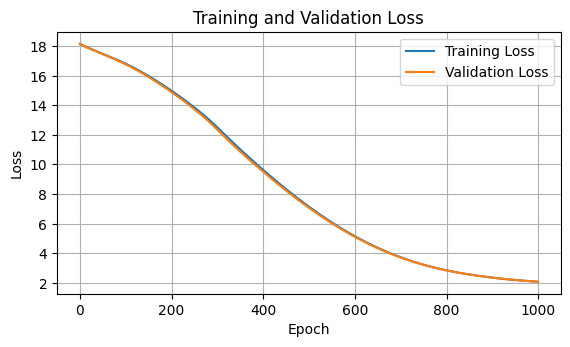

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.01
Epoch: 10, Train Loss: 16.3313, Val Loss: 16.0049, best model epoch: 10
Epoch: 20, Train Loss: 12.6204, Val Loss: 12.1441, best model epoch: 20
Epoch: 30, Train Loss: 7.8168, Val Loss: 7.2863, best model epoch: 30
Epoch: 40, Train Loss: 3.5093, Val Loss: 3.1771, best model epoch: 40
Epoch: 50, Train Loss: 2.0693, Val Loss: 2.1047, best model epoch: 48
Epoch: 60, Train Loss: 2.2788, Val Loss: 2.2554, best model epoch: 48
Epoch: 70, Train Loss: 2.0804, Val Loss: 2.0886, best model epoch: 48
Epoch: 80, Train Loss: 2.0587, Val Loss: 2.0577, best model epoch: 80
Epoch: 90, Train Loss: 2.0622, Val Loss: 2.0625, best model epoch: 80
Epoch: 100, Train Loss: 2.0589, Val Loss: 2.0585, best model epoch: 80
Epoch: 110, Train Loss: 2.0587, Val Loss: 2.0581, best model epoch: 80
Epoch: 120, Train Loss: 2.0579, Val Loss: 2.0579, best model epoch: 80
Epoch: 130, Train Loss: 2.0573, Val Loss: 2.0569, best model epoch: 130
Epoch: 140, Train Loss: 2.0561, Va

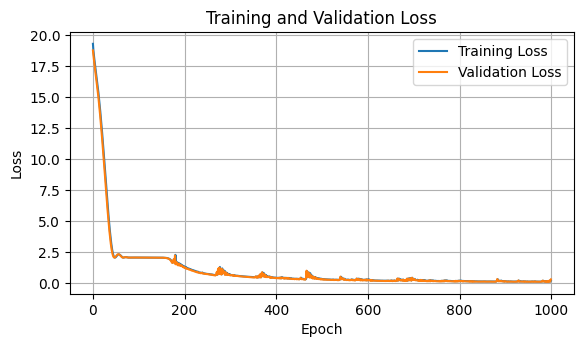

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.01
Epoch: 10, Train Loss: 16.6646, Val Loss: 16.0794, best model epoch: 10
Epoch: 20, Train Loss: 12.0100, Val Loss: 11.2620, best model epoch: 20
Epoch: 30, Train Loss: 6.4897, Val Loss: 5.8623, best model epoch: 30
Epoch: 40, Train Loss: 2.6283, Val Loss: 2.4201, best model epoch: 40
Epoch: 50, Train Loss: 2.1704, Val Loss: 2.2214, best model epoch: 45
Epoch: 60, Train Loss: 2.2170, Val Loss: 2.1864, best model epoch: 45
Epoch: 70, Train Loss: 2.0925, Val Loss: 2.0927, best model epoch: 65
Epoch: 80, Train Loss: 2.0555, Val Loss: 2.0550, best model epoch: 80
Epoch: 90, Train Loss: 2.0473, Val Loss: 2.0431, best model epoch: 90
Epoch: 100, Train Loss: 1.9994, Val Loss: 1.9905, best model epoch: 100
Epoch: 110, Train Loss: 1.7779, Val Loss: 1.7112, best model epoch: 110
Epoch: 120, Train Loss: 1.6007, Val Loss: 1.5058, best model epoch: 118
Epoch: 130, Train Loss: 1.3925, Val Loss: 1.2454, best model epoch: 128
Epoch: 140, Train Loss: 1.0986,

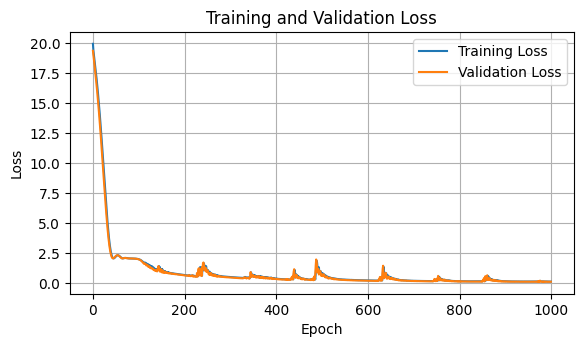

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 14.8220, Val Loss: 14.3988, best model epoch: 10
Epoch: 20, Train Loss: 11.5797, Val Loss: 11.0695, best model epoch: 20
Epoch: 30, Train Loss: 7.6663, Val Loss: 7.1937, best model epoch: 30
Epoch: 40, Train Loss: 4.0933, Val Loss: 3.7838, best model epoch: 40
Epoch: 50, Train Loss: 2.2340, Val Loss: 2.1593, best model epoch: 50
Epoch: 60, Train Loss: 2.1236, Val Loss: 2.1455, best model epoch: 54
Epoch: 70, Train Loss: 2.1227, Val Loss: 2.1103, best model epoch: 54
Epoch: 80, Train Loss: 2.0789, Val Loss: 2.0731, best model epoch: 54
Epoch: 90, Train Loss: 2.0574, Val Loss: 2.0567, best model epoch: 87
Epoch: 100, Train Loss: 2.0521, Val Loss: 2.0500, best model epoch: 100
Epoch: 110, Train Loss: 2.0339, Val Loss: 2.0262, best model epoch: 110
Epoch: 120, Train Loss: 1.9917, Val Loss: 1.9757, best model epoch: 120
Epoch: 130, Train Loss: 1.9460, Val Loss: 1.9282, best model epoch: 130
Epoch: 140, Train Loss: 1.9177,

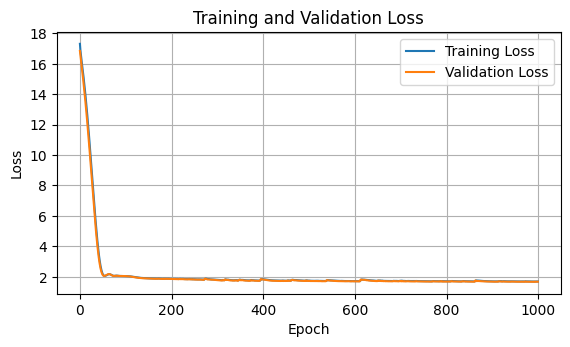

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.01
Epoch: 10, Train Loss: 13.5821, Val Loss: 13.0278, best model epoch: 10
Epoch: 20, Train Loss: 7.5386, Val Loss: 6.8492, best model epoch: 20
Epoch: 30, Train Loss: 2.5906, Val Loss: 2.3474, best model epoch: 30
Epoch: 40, Train Loss: 2.4122, Val Loss: 2.4691, best model epoch: 33
Epoch: 50, Train Loss: 2.0735, Val Loss: 2.0997, best model epoch: 48
Epoch: 60, Train Loss: 2.0538, Val Loss: 2.0504, best model epoch: 60
Epoch: 70, Train Loss: 2.0166, Val Loss: 2.0087, best model epoch: 70
Epoch: 80, Train Loss: 1.9613, Val Loss: 1.9572, best model epoch: 80
Epoch: 90, Train Loss: 1.9279, Val Loss: 1.9227, best model epoch: 90
Epoch: 100, Train Loss: 1.9045, Val Loss: 1.9004, best model epoch: 100
Epoch: 110, Train Loss: 1.8864, Val Loss: 1.8825, best model epoch: 110
Epoch: 120, Train Loss: 1.8705, Val Loss: 1.8670, best model epoch: 120
Epoch: 130, Train Loss: 1.8585, Val Loss: 1.8557, best model epoch: 129
Epoch: 140, Train Loss: 1.8575, V

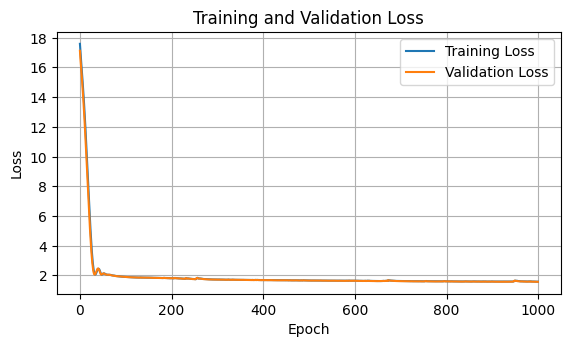

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.01
Epoch: 10, Train Loss: 12.4671, Val Loss: 11.7342, best model epoch: 10
Epoch: 20, Train Loss: 5.7259, Val Loss: 5.0172, best model epoch: 20
Epoch: 30, Train Loss: 2.0599, Val Loss: 2.0847, best model epoch: 29
Epoch: 40, Train Loss: 2.3246, Val Loss: 2.2370, best model epoch: 29
Epoch: 50, Train Loss: 2.1203, Val Loss: 2.0942, best model epoch: 43
Epoch: 60, Train Loss: 2.0757, Val Loss: 2.0796, best model epoch: 43
Epoch: 70, Train Loss: 2.0587, Val Loss: 2.0587, best model epoch: 43
Epoch: 80, Train Loss: 2.0575, Val Loss: 2.0571, best model epoch: 79
Epoch: 90, Train Loss: 2.0577, Val Loss: 2.0576, best model epoch: 79
Epoch: 100, Train Loss: 2.0568, Val Loss: 2.0562, best model epoch: 100
Epoch: 110, Train Loss: 2.0558, Val Loss: 2.0557, best model epoch: 110
Epoch: 120, Train Loss: 2.0539, Val Loss: 2.0535, best model epoch: 120
Epoch: 130, Train Loss: 2.0488, Val Loss: 2.0470, best model epoch: 130
Epoch: 140, Train Loss: 1.9816, V

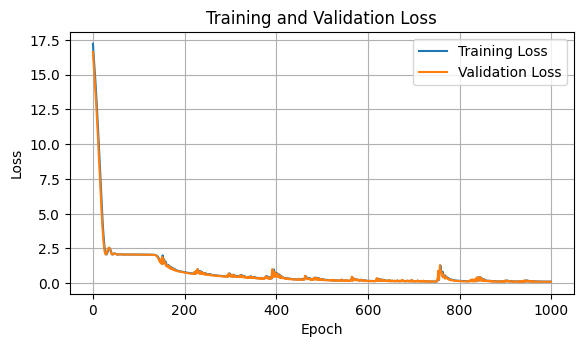

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 12.9110, Val Loss: 12.1427, best model epoch: 10
Epoch: 20, Train Loss: 6.5317, Val Loss: 5.7544, best model epoch: 20
Epoch: 30, Train Loss: 2.1625, Val Loss: 2.0726, best model epoch: 30
Epoch: 40, Train Loss: 2.5536, Val Loss: 2.5418, best model epoch: 31
Epoch: 50, Train Loss: 2.1051, Val Loss: 2.1077, best model epoch: 47
Epoch: 60, Train Loss: 2.0591, Val Loss: 2.0600, best model epoch: 47
Epoch: 70, Train Loss: 2.0635, Val Loss: 2.0662, best model epoch: 47
Epoch: 80, Train Loss: 2.0599, Val Loss: 2.0579, best model epoch: 47
Epoch: 90, Train Loss: 2.0580, Val Loss: 2.0585, best model epoch: 47
Epoch: 100, Train Loss: 2.0575, Val Loss: 2.0582, best model epoch: 47
Epoch: 110, Train Loss: 2.0552, Val Loss: 2.0552, best model epoch: 110
Epoch: 120, Train Loss: 2.0475, Val Loss: 2.0475, best model epoch: 120
Epoch: 130, Train Loss: 1.9924, Val Loss: 1.9831, best model epoch: 130
Epoch: 140, Train Loss: 1.6852, Va

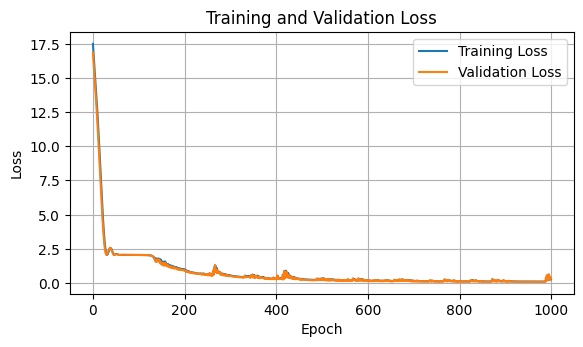

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.01
Epoch: 10, Train Loss: 11.9164, Val Loss: 11.1570, best model epoch: 10
Epoch: 20, Train Loss: 4.3545, Val Loss: 3.7320, best model epoch: 20
Epoch: 30, Train Loss: 2.3877, Val Loss: 2.5420, best model epoch: 26
Epoch: 40, Train Loss: 2.0659, Val Loss: 2.1028, best model epoch: 26
Epoch: 50, Train Loss: 2.0591, Val Loss: 2.0594, best model epoch: 49
Epoch: 60, Train Loss: 2.0669, Val Loss: 2.0626, best model epoch: 49
Epoch: 70, Train Loss: 2.0643, Val Loss: 2.0627, best model epoch: 62
Epoch: 80, Train Loss: 2.0597, Val Loss: 2.0601, best model epoch: 75
Epoch: 90, Train Loss: 2.0581, Val Loss: 2.0582, best model epoch: 88
Epoch: 100, Train Loss: 2.0579, Val Loss: 2.0578, best model epoch: 99
Epoch: 110, Train Loss: 2.0572, Val Loss: 2.0571, best model epoch: 110
Epoch: 120, Train Loss: 2.0546, Val Loss: 2.0542, best model epoch: 120
Epoch: 130, Train Loss: 2.0442, Val Loss: 2.0421, best model epoch: 130
Epoch: 140, Train Loss: 1.9831, Va

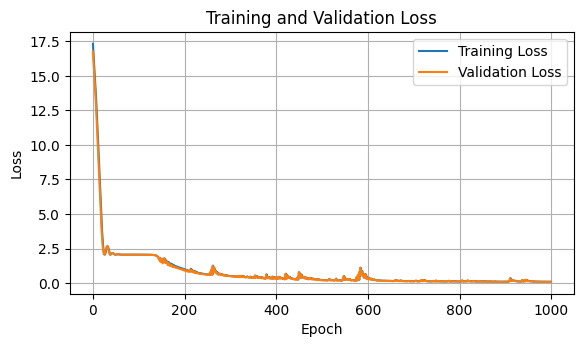

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.01
Epoch: 10, Train Loss: 11.4203, Val Loss: 10.3608, best model epoch: 10
Epoch: 20, Train Loss: 2.6973, Val Loss: 2.3151, best model epoch: 20
Epoch: 30, Train Loss: 2.9186, Val Loss: 2.7985, best model epoch: 22
Epoch: 40, Train Loss: 2.2112, Val Loss: 2.2023, best model epoch: 35
Epoch: 50, Train Loss: 2.0746, Val Loss: 2.0851, best model epoch: 35
Epoch: 60, Train Loss: 2.0575, Val Loss: 2.0575, best model epoch: 35
Epoch: 70, Train Loss: 2.0594, Val Loss: 2.0574, best model epoch: 35
Epoch: 80, Train Loss: 2.0552, Val Loss: 2.0542, best model epoch: 80
Epoch: 90, Train Loss: 2.0555, Val Loss: 2.0528, best model epoch: 85
Epoch: 100, Train Loss: 2.0008, Val Loss: 1.9625, best model epoch: 100
Epoch: 110, Train Loss: 2.1017, Val Loss: 2.1150, best model epoch: 106
Epoch: 120, Train Loss: 1.9498, Val Loss: 1.9425, best model epoch: 106
Epoch: 130, Train Loss: 1.5048, Val Loss: 1.4210, best model epoch: 130
Epoch: 140, Train Loss: 1.2842, V

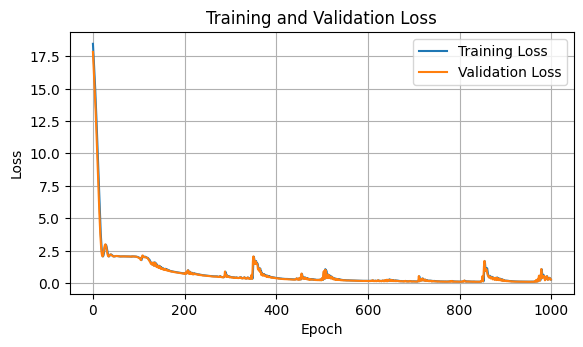

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 12.6041, Val Loss: 11.7319, best model epoch: 10
Epoch: 20, Train Loss: 4.5252, Val Loss: 3.8397, best model epoch: 20
Epoch: 30, Train Loss: 2.4037, Val Loss: 2.5764, best model epoch: 26
Epoch: 40, Train Loss: 2.0593, Val Loss: 2.0760, best model epoch: 39
Epoch: 50, Train Loss: 2.0632, Val Loss: 2.0582, best model epoch: 50
Epoch: 60, Train Loss: 2.0717, Val Loss: 2.0678, best model epoch: 50
Epoch: 70, Train Loss: 2.0643, Val Loss: 2.0632, best model epoch: 50
Epoch: 80, Train Loss: 2.0590, Val Loss: 2.0596, best model epoch: 76
Epoch: 90, Train Loss: 2.0581, Val Loss: 2.0580, best model epoch: 90
Epoch: 100, Train Loss: 2.0581, Val Loss: 2.0578, best model epoch: 100
Epoch: 110, Train Loss: 2.0578, Val Loss: 2.0577, best model epoch: 110
Epoch: 120, Train Loss: 2.0573, Val Loss: 2.0571, best model epoch: 120
Epoch: 130, Train Loss: 2.0565, Val Loss: 2.0563, best model epoch: 130
Epoch: 140, Train Loss: 2.0547, V

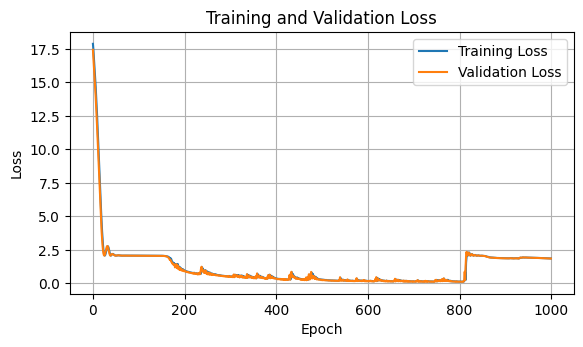

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.01
Epoch: 10, Train Loss: 8.7958, Val Loss: 7.5795, best model epoch: 10
Epoch: 20, Train Loss: 2.3149, Val Loss: 2.6392, best model epoch: 17
Epoch: 30, Train Loss: 2.0968, Val Loss: 2.1395, best model epoch: 28
Epoch: 40, Train Loss: 2.0732, Val Loss: 2.0786, best model epoch: 37
Epoch: 50, Train Loss: 2.0409, Val Loss: 2.0309, best model epoch: 50
Epoch: 60, Train Loss: 1.9664, Val Loss: 1.9632, best model epoch: 60
Epoch: 70, Train Loss: 1.9147, Val Loss: 1.9115, best model epoch: 70
Epoch: 80, Train Loss: 1.8893, Val Loss: 1.8849, best model epoch: 80
Epoch: 90, Train Loss: 1.8996, Val Loss: 1.8906, best model epoch: 87
Epoch: 100, Train Loss: 1.8745, Val Loss: 1.8651, best model epoch: 100
Epoch: 110, Train Loss: 1.8599, Val Loss: 1.8549, best model epoch: 110
Epoch: 120, Train Loss: 1.8508, Val Loss: 1.8450, best model epoch: 120
Epoch: 130, Train Loss: 1.8401, Val Loss: 1.8370, best model epoch: 130
Epoch: 140, Train Loss: 1.8326, Va

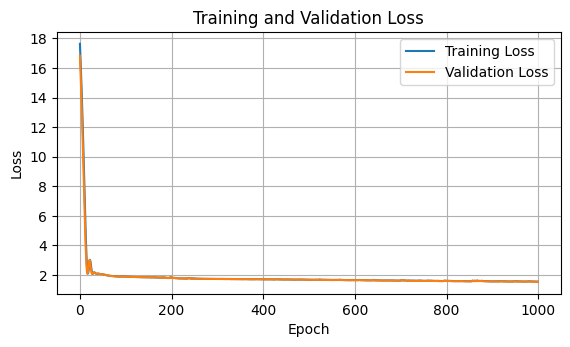

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.01
Epoch: 10, Train Loss: 9.2003, Val Loss: 7.8421, best model epoch: 10
Epoch: 20, Train Loss: 2.4332, Val Loss: 2.8329, best model epoch: 17
Epoch: 30, Train Loss: 2.1185, Val Loss: 2.1911, best model epoch: 28
Epoch: 40, Train Loss: 2.0757, Val Loss: 2.0950, best model epoch: 37
Epoch: 50, Train Loss: 2.0616, Val Loss: 2.0664, best model epoch: 48
Epoch: 60, Train Loss: 2.0585, Val Loss: 2.0600, best model epoch: 58
Epoch: 70, Train Loss: 2.0582, Val Loss: 2.0585, best model epoch: 69
Epoch: 80, Train Loss: 2.0582, Val Loss: 2.0583, best model epoch: 79
Epoch: 90, Train Loss: 2.0582, Val Loss: 2.0581, best model epoch: 89
Epoch: 100, Train Loss: 2.0581, Val Loss: 2.0581, best model epoch: 98
Epoch: 110, Train Loss: 2.0581, Val Loss: 2.0580, best model epoch: 108
Epoch: 120, Train Loss: 2.0580, Val Loss: 2.0580, best model epoch: 116
Epoch: 130, Train Loss: 2.0397, Val Loss: 2.0258, best model epoch: 130
Epoch: 140, Train Loss: 1.9164, Val

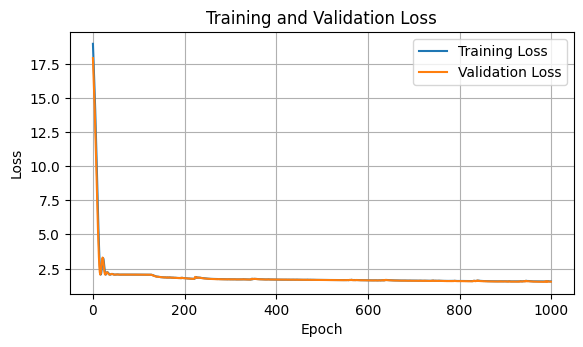

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 9.5143, Val Loss: 8.2654, best model epoch: 10
Epoch: 20, Train Loss: 2.1487, Val Loss: 2.4230, best model epoch: 18
Epoch: 30, Train Loss: 2.0718, Val Loss: 2.0649, best model epoch: 18
Epoch: 40, Train Loss: 2.0609, Val Loss: 2.0616, best model epoch: 18
Epoch: 50, Train Loss: 2.0581, Val Loss: 2.0568, best model epoch: 50
Epoch: 60, Train Loss: 2.0550, Val Loss: 2.0541, best model epoch: 60
Epoch: 70, Train Loss: 2.0366, Val Loss: 2.0329, best model epoch: 70
Epoch: 80, Train Loss: 1.9719, Val Loss: 1.9637, best model epoch: 80
Epoch: 90, Train Loss: 1.9109, Val Loss: 1.9049, best model epoch: 90
Epoch: 100, Train Loss: 1.8838, Val Loss: 1.8776, best model epoch: 100
Epoch: 110, Train Loss: 1.8757, Val Loss: 1.8786, best model epoch: 109
Epoch: 120, Train Loss: 1.8692, Val Loss: 1.8597, best model epoch: 120
Epoch: 130, Train Loss: 1.8515, Val Loss: 1.8469, best model epoch: 130
Epoch: 140, Train Loss: 1.8554, Va

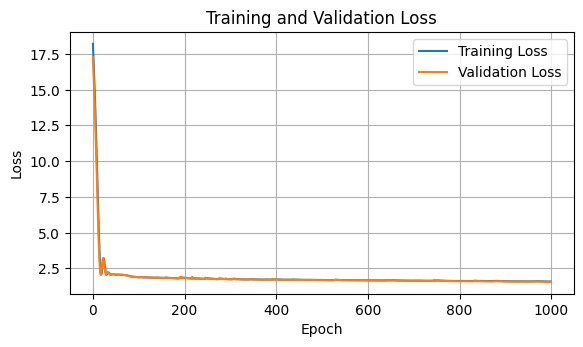

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.01
Epoch: 10, Train Loss: 6.8182, Val Loss: 5.3297, best model epoch: 10
Epoch: 20, Train Loss: 3.4696, Val Loss: 3.0856, best model epoch: 14
Epoch: 30, Train Loss: 2.0620, Val Loss: 2.0581, best model epoch: 30
Epoch: 40, Train Loss: 2.0576, Val Loss: 2.0588, best model epoch: 38
Epoch: 50, Train Loss: 2.0521, Val Loss: 2.0511, best model epoch: 50
Epoch: 60, Train Loss: 2.0051, Val Loss: 1.9834, best model epoch: 60
Epoch: 70, Train Loss: 1.7960, Val Loss: 1.9431, best model epoch: 68
Epoch: 80, Train Loss: 1.4898, Val Loss: 1.5725, best model epoch: 79
Epoch: 90, Train Loss: 1.3932, Val Loss: 1.2927, best model epoch: 90
Epoch: 100, Train Loss: 1.3862, Val Loss: 1.2815, best model epoch: 95
Epoch: 110, Train Loss: 1.3147, Val Loss: 1.0920, best model epoch: 110
Epoch: 120, Train Loss: 1.0526, Val Loss: 1.2098, best model epoch: 119
Epoch: 130, Train Loss: 1.0200, Val Loss: 1.0753, best model epoch: 129
Epoch: 140, Train Loss: 0.9796, Val

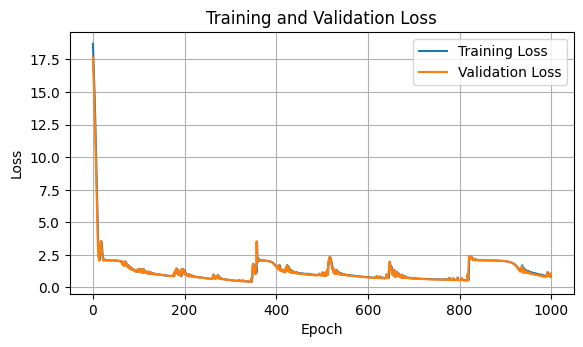

hidden_dim: 256 | dropout_prob: 0.3  | lr: 0.01
Epoch: 10, Train Loss: 6.1441, Val Loss: 4.7652, best model epoch: 10
Epoch: 20, Train Loss: 3.3225, Val Loss: 2.9503, best model epoch: 14
Epoch: 30, Train Loss: 2.2247, Val Loss: 2.1639, best model epoch: 14
Epoch: 40, Train Loss: 2.1062, Val Loss: 2.0872, best model epoch: 33
Epoch: 50, Train Loss: 2.0746, Val Loss: 2.0678, best model epoch: 33
Epoch: 60, Train Loss: 2.0635, Val Loss: 2.0610, best model epoch: 33
Epoch: 70, Train Loss: 2.0596, Val Loss: 2.0587, best model epoch: 33
Epoch: 80, Train Loss: 2.0584, Val Loss: 2.0582, best model epoch: 80
Epoch: 90, Train Loss: 2.0582, Val Loss: 2.0582, best model epoch: 89
Epoch: 100, Train Loss: 2.0582, Val Loss: 2.0582, best model epoch: 98
Epoch: 110, Train Loss: 2.0582, Val Loss: 2.0582, best model epoch: 106
Epoch: 120, Train Loss: 2.0581, Val Loss: 2.0581, best model epoch: 120
Epoch: 130, Train Loss: 2.0581, Val Loss: 2.0581, best model epoch: 130
Epoch: 140, Train Loss: 2.0581, Val

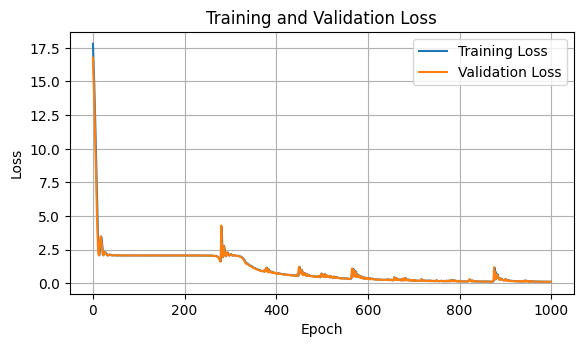

hidden_dim: 256 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 6.6441, Val Loss: 5.1116, best model epoch: 10
Epoch: 20, Train Loss: 3.5629, Val Loss: 3.1616, best model epoch: 14
Epoch: 30, Train Loss: 2.1105, Val Loss: 2.0917, best model epoch: 14
Epoch: 40, Train Loss: 2.0574, Val Loss: 2.0582, best model epoch: 33
Epoch: 50, Train Loss: 2.0564, Val Loss: 2.0556, best model epoch: 50
Epoch: 60, Train Loss: 2.0498, Val Loss: 2.0477, best model epoch: 60
Epoch: 70, Train Loss: 1.9920, Val Loss: 1.9664, best model epoch: 70
Epoch: 80, Train Loss: 2.0420, Val Loss: 1.5880, best model epoch: 80
Epoch: 90, Train Loss: 1.3448, Val Loss: 1.2247, best model epoch: 90
Epoch: 100, Train Loss: 1.2010, Val Loss: 0.9601, best model epoch: 100
Epoch: 110, Train Loss: 1.1515, Val Loss: 0.9356, best model epoch: 110
Epoch: 120, Train Loss: 0.9424, Val Loss: 0.8783, best model epoch: 120
Epoch: 130, Train Loss: 0.8403, Val Loss: 0.8063, best model epoch: 130
Epoch: 140, Train Loss: 0.7711, Va

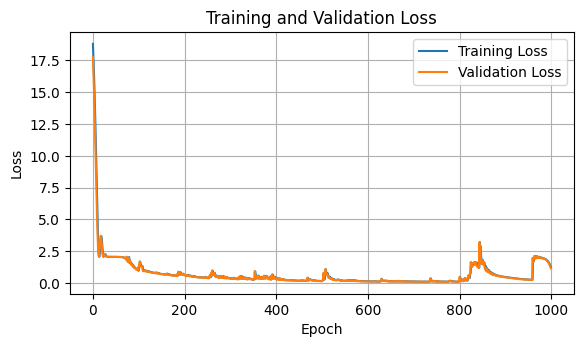

In [21]:
# GAT grid search
GAT_results_part2 = []
for indx, row in GAT_grid_params_part2.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GAT_results_part2.append(run_GAT_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs))
pd.DataFrame(GAT_results_part2).to_excel('GAT_p2_results.xlsx')

GAT_results_part3 = []
for indx, row in GAT_grid_params_part3.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GAT_results_part3.append(run_GAT_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs))
pd.DataFrame(GAT_results_part3).to_excel('GAT_p3_results.xlsx')


Fine tuning GATv2

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.9470, Val Loss: 17.8657, best model epoch: 10
Epoch: 20, Train Loss: 17.3279, Val Loss: 17.2313, best model epoch: 20
Epoch: 30, Train Loss: 16.7104, Val Loss: 16.6031, best model epoch: 30
Epoch: 40, Train Loss: 16.0888, Val Loss: 15.9706, best model epoch: 40
Epoch: 50, Train Loss: 15.4368, Val Loss: 15.3104, best model epoch: 50
Epoch: 60, Train Loss: 14.7320, Val Loss: 14.5968, best model epoch: 60
Epoch: 70, Train Loss: 13.9533, Val Loss: 13.8142, best model epoch: 70
Epoch: 80, Train Loss: 13.0972, Val Loss: 12.9448, best model epoch: 80
Epoch: 90, Train Loss: 12.1511, Val Loss: 11.9877, best model epoch: 90
Epoch: 100, Train Loss: 11.1563, Val Loss: 10.9765, best model epoch: 100
Epoch: 110, Train Loss: 10.1251, Val Loss: 9.9399, best model epoch: 110
Epoch: 120, Train Loss: 9.0915, Val Loss: 8.9086, best model epoch: 120
Epoch: 130, Train Loss: 8.0961, Val Loss: 7.9214, best model epoch: 130
Epoch: 140, T

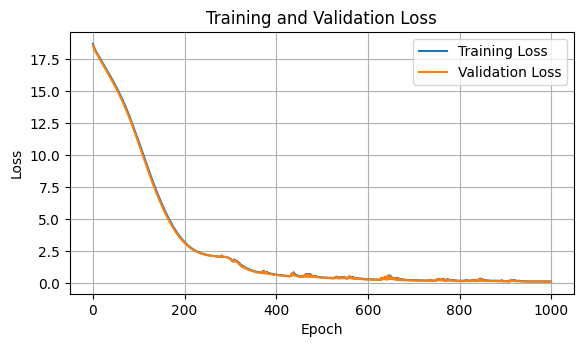

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 19.3847, Val Loss: 19.2876, best model epoch: 10
Epoch: 20, Train Loss: 18.8447, Val Loss: 18.7604, best model epoch: 20
Epoch: 30, Train Loss: 18.3267, Val Loss: 18.2534, best model epoch: 30
Epoch: 40, Train Loss: 17.8131, Val Loss: 17.7309, best model epoch: 40
Epoch: 50, Train Loss: 17.2497, Val Loss: 17.1532, best model epoch: 50
Epoch: 60, Train Loss: 16.6172, Val Loss: 16.5144, best model epoch: 60
Epoch: 70, Train Loss: 15.9222, Val Loss: 15.8115, best model epoch: 70
Epoch: 80, Train Loss: 15.1572, Val Loss: 15.0414, best model epoch: 80
Epoch: 90, Train Loss: 14.3374, Val Loss: 14.2174, best model epoch: 90
Epoch: 100, Train Loss: 13.4685, Val Loss: 13.3466, best model epoch: 100
Epoch: 110, Train Loss: 12.5623, Val Loss: 12.4397, best model epoch: 110
Epoch: 120, Train Loss: 11.6275, Val Loss: 11.5074, best model epoch: 120
Epoch: 130, Train Loss: 10.6824, Val Loss: 10.5638, best model epoch: 130
Epoch: 1

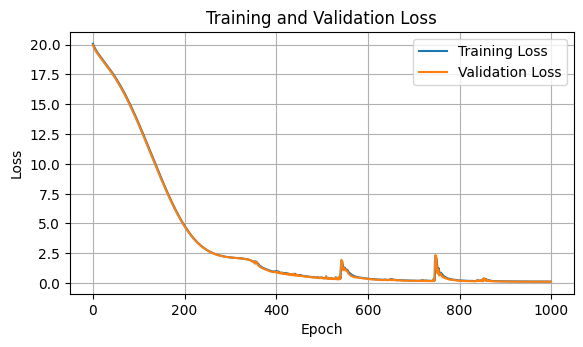

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 18.5609, Val Loss: 18.5495, best model epoch: 10
Epoch: 20, Train Loss: 18.4917, Val Loss: 18.4810, best model epoch: 20
Epoch: 30, Train Loss: 18.4304, Val Loss: 18.4195, best model epoch: 30
Epoch: 40, Train Loss: 18.3751, Val Loss: 18.3638, best model epoch: 40
Epoch: 50, Train Loss: 18.3236, Val Loss: 18.3119, best model epoch: 50
Epoch: 60, Train Loss: 18.2742, Val Loss: 18.2623, best model epoch: 60
Epoch: 70, Train Loss: 18.2276, Val Loss: 18.2144, best model epoch: 70
Epoch: 80, Train Loss: 18.1819, Val Loss: 18.1682, best model epoch: 80
Epoch: 90, Train Loss: 18.1378, Val Loss: 18.1240, best model epoch: 90
Epoch: 100, Train Loss: 18.0959, Val Loss: 18.0818, best model epoch: 100
Epoch: 110, Train Loss: 18.0551, Val Loss: 18.0401, best model epoch: 110
Epoch: 120, Train Loss: 18.0111, Val Loss: 17.9940, best model epoch: 120
Epoch: 130, Train Loss: 17.9635, Val Loss: 17.9454, best model epoch: 130
Epoch: 

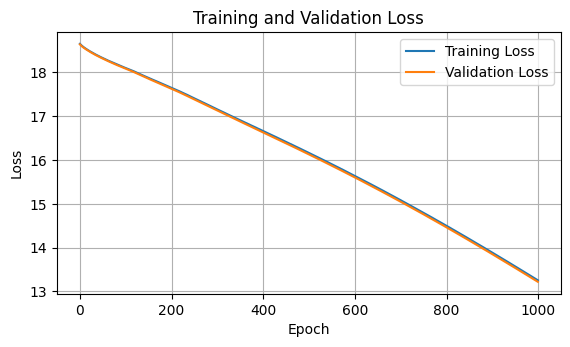

hidden_dim: 32 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.6097, Val Loss: 17.5849, best model epoch: 10
Epoch: 20, Train Loss: 17.5149, Val Loss: 17.4905, best model epoch: 20
Epoch: 30, Train Loss: 17.4347, Val Loss: 17.4099, best model epoch: 30
Epoch: 40, Train Loss: 17.3646, Val Loss: 17.3358, best model epoch: 40
Epoch: 50, Train Loss: 17.2923, Val Loss: 17.2647, best model epoch: 50
Epoch: 60, Train Loss: 17.2335, Val Loss: 17.2142, best model epoch: 60
Epoch: 70, Train Loss: 17.1802, Val Loss: 17.1620, best model epoch: 70
Epoch: 80, Train Loss: 17.1317, Val Loss: 17.1121, best model epoch: 80
Epoch: 90, Train Loss: 17.0842, Val Loss: 17.0646, best model epoch: 90
Epoch: 100, Train Loss: 17.0387, Val Loss: 17.0181, best model epoch: 100
Epoch: 110, Train Loss: 16.9917, Val Loss: 16.9706, best model epoch: 110
Epoch: 120, Train Loss: 16.9444, Val Loss: 16.9230, best model epoch: 120
Epoch: 130, Train Loss: 16.8966, Val Loss: 16.8757, best model epoch: 130
Epoch: 

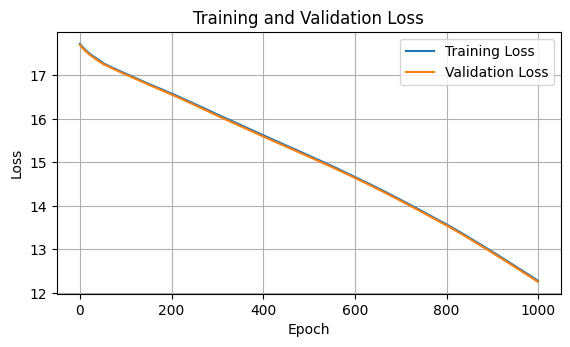

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 18.4158, Val Loss: 18.3071, best model epoch: 10
Epoch: 20, Train Loss: 17.9564, Val Loss: 17.8463, best model epoch: 20
Epoch: 30, Train Loss: 17.4748, Val Loss: 17.3414, best model epoch: 30
Epoch: 40, Train Loss: 16.9335, Val Loss: 16.7812, best model epoch: 40
Epoch: 50, Train Loss: 16.2709, Val Loss: 16.1130, best model epoch: 50
Epoch: 60, Train Loss: 15.5610, Val Loss: 15.3908, best model epoch: 60
Epoch: 70, Train Loss: 14.7896, Val Loss: 14.6102, best model epoch: 70
Epoch: 80, Train Loss: 13.9515, Val Loss: 13.7440, best model epoch: 80
Epoch: 90, Train Loss: 13.0355, Val Loss: 12.8131, best model epoch: 90
Epoch: 100, Train Loss: 12.0981, Val Loss: 11.8724, best model epoch: 100
Epoch: 110, Train Loss: 11.1570, Val Loss: 10.9358, best model epoch: 110
Epoch: 120, Train Loss: 10.2102, Val Loss: 10.0012, best model epoch: 120
Epoch: 130, Train Loss: 9.2908, Val Loss: 9.0792, best model epoch: 130
Epoch: 140

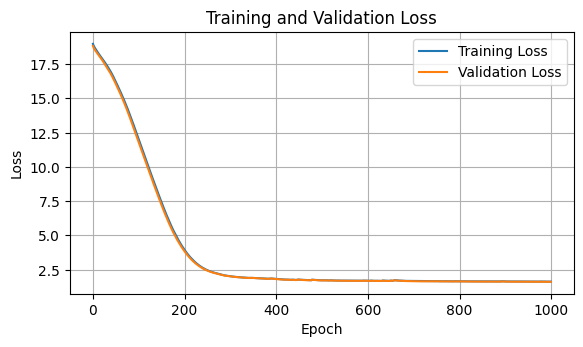

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 15.9952, Val Loss: 15.9030, best model epoch: 10
Epoch: 20, Train Loss: 15.4970, Val Loss: 15.3878, best model epoch: 20
Epoch: 30, Train Loss: 15.0205, Val Loss: 14.8979, best model epoch: 30
Epoch: 40, Train Loss: 14.5248, Val Loss: 14.3789, best model epoch: 40
Epoch: 50, Train Loss: 13.9937, Val Loss: 13.8273, best model epoch: 50
Epoch: 60, Train Loss: 13.4240, Val Loss: 13.2503, best model epoch: 60
Epoch: 70, Train Loss: 12.8374, Val Loss: 12.6719, best model epoch: 70
Epoch: 80, Train Loss: 12.2360, Val Loss: 12.0815, best model epoch: 80
Epoch: 90, Train Loss: 11.6120, Val Loss: 11.4675, best model epoch: 90
Epoch: 100, Train Loss: 10.9576, Val Loss: 10.8236, best model epoch: 100
Epoch: 110, Train Loss: 10.2614, Val Loss: 10.1334, best model epoch: 110
Epoch: 120, Train Loss: 9.4987, Val Loss: 9.3683, best model epoch: 120
Epoch: 130, Train Loss: 8.7070, Val Loss: 8.5983, best model epoch: 130
Epoch: 140, 

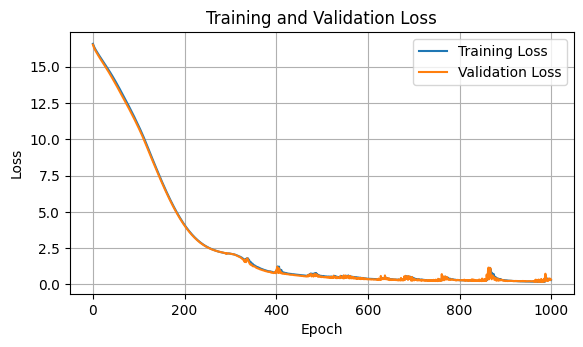

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 16.7735, Val Loss: 16.7424, best model epoch: 10
Epoch: 20, Train Loss: 16.7021, Val Loss: 16.6584, best model epoch: 20
Epoch: 30, Train Loss: 16.6317, Val Loss: 16.5777, best model epoch: 30
Epoch: 40, Train Loss: 16.5630, Val Loss: 16.4989, best model epoch: 40
Epoch: 50, Train Loss: 16.4919, Val Loss: 16.4198, best model epoch: 50
Epoch: 60, Train Loss: 16.4218, Val Loss: 16.3428, best model epoch: 60
Epoch: 70, Train Loss: 16.3513, Val Loss: 16.2690, best model epoch: 70
Epoch: 80, Train Loss: 16.2843, Val Loss: 16.1976, best model epoch: 80
Epoch: 90, Train Loss: 16.2156, Val Loss: 16.1278, best model epoch: 90
Epoch: 100, Train Loss: 16.1500, Val Loss: 16.0599, best model epoch: 100
Epoch: 110, Train Loss: 16.0863, Val Loss: 15.9935, best model epoch: 110
Epoch: 120, Train Loss: 16.0229, Val Loss: 15.9280, best model epoch: 120
Epoch: 130, Train Loss: 15.9624, Val Loss: 15.8629, best model epoch: 130
Epoch: 

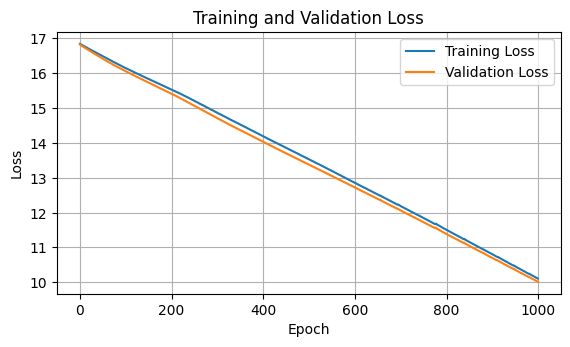

hidden_dim: 32 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 17.6761, Val Loss: 17.6881, best model epoch: 10
Epoch: 20, Train Loss: 17.6139, Val Loss: 17.6072, best model epoch: 20
Epoch: 30, Train Loss: 17.5533, Val Loss: 17.5311, best model epoch: 30
Epoch: 40, Train Loss: 17.4942, Val Loss: 17.4384, best model epoch: 40
Epoch: 50, Train Loss: 17.4172, Val Loss: 17.3517, best model epoch: 50
Epoch: 60, Train Loss: 17.3396, Val Loss: 17.2741, best model epoch: 60
Epoch: 70, Train Loss: 17.2672, Val Loss: 17.1897, best model epoch: 70
Epoch: 80, Train Loss: 17.1966, Val Loss: 17.1063, best model epoch: 80
Epoch: 90, Train Loss: 17.1281, Val Loss: 17.0254, best model epoch: 90
Epoch: 100, Train Loss: 17.0597, Val Loss: 16.9456, best model epoch: 100
Epoch: 110, Train Loss: 16.9950, Val Loss: 16.8756, best model epoch: 110
Epoch: 120, Train Loss: 16.9285, Val Loss: 16.8070, best model epoch: 120
Epoch: 130, Train Loss: 16.8551, Val Loss: 16.7423, best model epoch: 130
Epoch: 

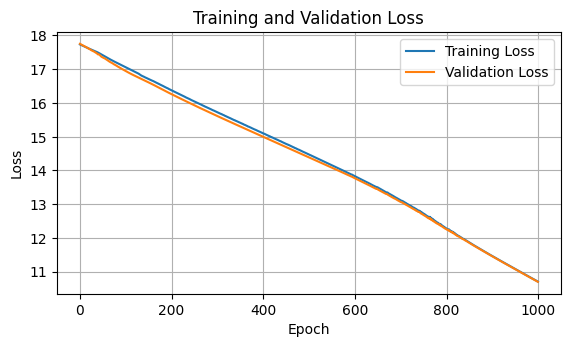

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.0350, Val Loss: 16.9289, best model epoch: 10
Epoch: 20, Train Loss: 16.1276, Val Loss: 15.9840, best model epoch: 20
Epoch: 30, Train Loss: 15.1177, Val Loss: 14.9505, best model epoch: 30
Epoch: 40, Train Loss: 13.9972, Val Loss: 13.8153, best model epoch: 40
Epoch: 50, Train Loss: 12.7338, Val Loss: 12.5348, best model epoch: 50
Epoch: 60, Train Loss: 11.3413, Val Loss: 11.1301, best model epoch: 60
Epoch: 70, Train Loss: 9.8644, Val Loss: 9.6490, best model epoch: 70
Epoch: 80, Train Loss: 8.3648, Val Loss: 8.1534, best model epoch: 80
Epoch: 90, Train Loss: 6.9130, Val Loss: 6.7153, best model epoch: 90
Epoch: 100, Train Loss: 5.5841, Val Loss: 5.4096, best model epoch: 100
Epoch: 110, Train Loss: 4.4487, Val Loss: 4.3018, best model epoch: 110
Epoch: 120, Train Loss: 3.5448, Val Loss: 3.4339, best model epoch: 120
Epoch: 130, Train Loss: 2.8938, Val Loss: 2.8163, best model epoch: 130
Epoch: 140, Train Los

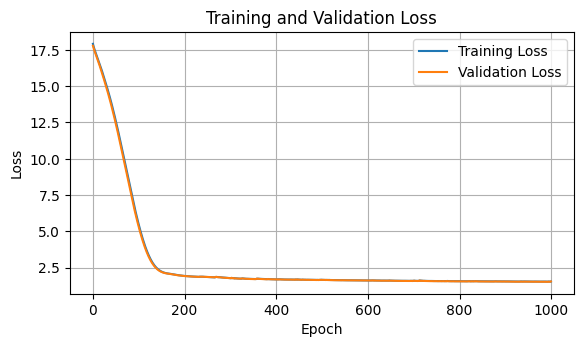

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.1370, Val Loss: 17.0543, best model epoch: 10
Epoch: 20, Train Loss: 16.4121, Val Loss: 16.3203, best model epoch: 20
Epoch: 30, Train Loss: 15.6094, Val Loss: 15.5044, best model epoch: 30
Epoch: 40, Train Loss: 14.6530, Val Loss: 14.5218, best model epoch: 40
Epoch: 50, Train Loss: 13.5006, Val Loss: 13.3410, best model epoch: 50
Epoch: 60, Train Loss: 12.1552, Val Loss: 11.9745, best model epoch: 60
Epoch: 70, Train Loss: 10.6595, Val Loss: 10.4605, best model epoch: 70
Epoch: 80, Train Loss: 9.0650, Val Loss: 8.8551, best model epoch: 80
Epoch: 90, Train Loss: 7.4515, Val Loss: 7.2517, best model epoch: 90
Epoch: 100, Train Loss: 5.9690, Val Loss: 5.7993, best model epoch: 100
Epoch: 110, Train Loss: 4.6916, Val Loss: 4.5564, best model epoch: 110
Epoch: 120, Train Loss: 3.6812, Val Loss: 3.5793, best model epoch: 120
Epoch: 130, Train Loss: 2.9533, Val Loss: 2.8853, best model epoch: 130
Epoch: 140, Train L

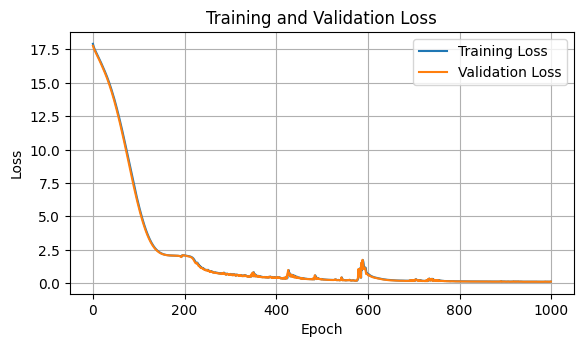

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.8544, Val Loss: 17.8398, best model epoch: 10
Epoch: 20, Train Loss: 17.7345, Val Loss: 17.7176, best model epoch: 20
Epoch: 30, Train Loss: 17.6177, Val Loss: 17.6004, best model epoch: 30
Epoch: 40, Train Loss: 17.5034, Val Loss: 17.4841, best model epoch: 40
Epoch: 50, Train Loss: 17.3879, Val Loss: 17.3658, best model epoch: 50
Epoch: 60, Train Loss: 17.2662, Val Loss: 17.2407, best model epoch: 60
Epoch: 70, Train Loss: 17.1390, Val Loss: 17.1107, best model epoch: 70
Epoch: 80, Train Loss: 17.0089, Val Loss: 16.9780, best model epoch: 80
Epoch: 90, Train Loss: 16.8779, Val Loss: 16.8438, best model epoch: 90
Epoch: 100, Train Loss: 16.7454, Val Loss: 16.7092, best model epoch: 100
Epoch: 110, Train Loss: 16.6122, Val Loss: 16.5742, best model epoch: 110
Epoch: 120, Train Loss: 16.4774, Val Loss: 16.4381, best model epoch: 120
Epoch: 130, Train Loss: 16.3398, Val Loss: 16.2969, best model epoch: 130
Epoch:

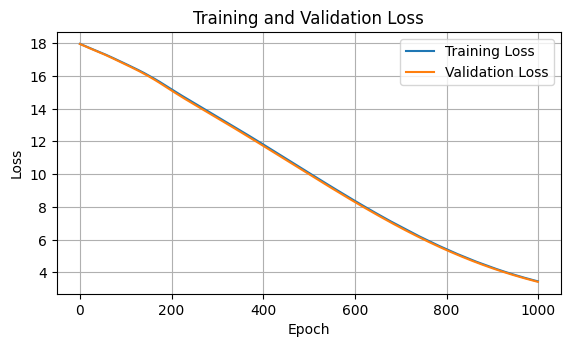

hidden_dim: 128 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.3705, Val Loss: 17.3552, best model epoch: 10
Epoch: 20, Train Loss: 17.2773, Val Loss: 17.2577, best model epoch: 20
Epoch: 30, Train Loss: 17.1816, Val Loss: 17.1591, best model epoch: 30
Epoch: 40, Train Loss: 17.0872, Val Loss: 17.0621, best model epoch: 40
Epoch: 50, Train Loss: 16.9942, Val Loss: 16.9663, best model epoch: 50
Epoch: 60, Train Loss: 16.9034, Val Loss: 16.8741, best model epoch: 60
Epoch: 70, Train Loss: 16.8157, Val Loss: 16.7855, best model epoch: 70
Epoch: 80, Train Loss: 16.7286, Val Loss: 16.6982, best model epoch: 80
Epoch: 90, Train Loss: 16.6411, Val Loss: 16.6102, best model epoch: 90
Epoch: 100, Train Loss: 16.5530, Val Loss: 16.5224, best model epoch: 100
Epoch: 110, Train Loss: 16.4641, Val Loss: 16.4327, best model epoch: 110
Epoch: 120, Train Loss: 16.3719, Val Loss: 16.3391, best model epoch: 120
Epoch: 130, Train Loss: 16.2751, Val Loss: 16.2418, best model epoch: 130
Epoch:

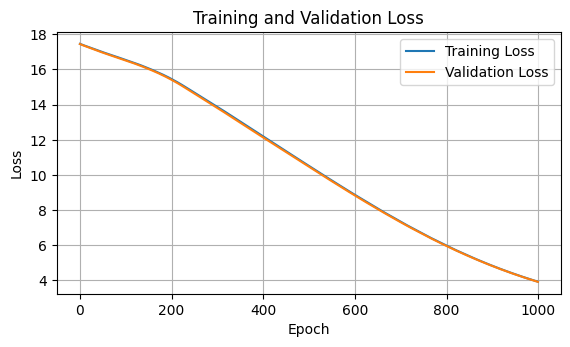

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 16.8230, Val Loss: 16.6754, best model epoch: 10
Epoch: 20, Train Loss: 16.0288, Val Loss: 15.8359, best model epoch: 20
Epoch: 30, Train Loss: 15.1408, Val Loss: 14.9144, best model epoch: 30
Epoch: 40, Train Loss: 14.1162, Val Loss: 13.8605, best model epoch: 40
Epoch: 50, Train Loss: 12.9351, Val Loss: 12.6601, best model epoch: 50
Epoch: 60, Train Loss: 11.5905, Val Loss: 11.3052, best model epoch: 60
Epoch: 70, Train Loss: 10.1213, Val Loss: 9.8393, best model epoch: 70
Epoch: 80, Train Loss: 8.5972, Val Loss: 8.3357, best model epoch: 80
Epoch: 90, Train Loss: 7.0925, Val Loss: 6.8585, best model epoch: 90
Epoch: 100, Train Loss: 5.6717, Val Loss: 5.4723, best model epoch: 100
Epoch: 110, Train Loss: 4.4203, Val Loss: 4.2624, best model epoch: 110
Epoch: 120, Train Loss: 3.4117, Val Loss: 3.2957, best model epoch: 120
Epoch: 130, Train Loss: 2.6891, Val Loss: 2.6151, best model epoch: 130
Epoch: 140, Train Lo

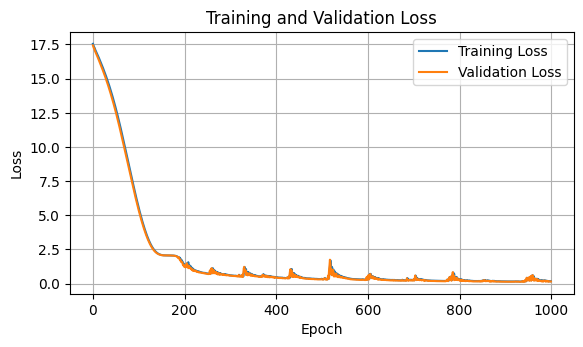

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 17.1417, Val Loss: 17.0283, best model epoch: 10
Epoch: 20, Train Loss: 16.3053, Val Loss: 16.1863, best model epoch: 20
Epoch: 30, Train Loss: 15.3620, Val Loss: 15.2210, best model epoch: 30
Epoch: 40, Train Loss: 14.2261, Val Loss: 14.0536, best model epoch: 40
Epoch: 50, Train Loss: 12.8622, Val Loss: 12.6546, best model epoch: 50
Epoch: 60, Train Loss: 11.2838, Val Loss: 11.0380, best model epoch: 60
Epoch: 70, Train Loss: 9.5643, Val Loss: 9.3070, best model epoch: 70
Epoch: 80, Train Loss: 7.7819, Val Loss: 7.5399, best model epoch: 80
Epoch: 90, Train Loss: 6.0787, Val Loss: 5.8721, best model epoch: 90
Epoch: 100, Train Loss: 4.6120, Val Loss: 4.4599, best model epoch: 100
Epoch: 110, Train Loss: 3.4855, Val Loss: 3.3826, best model epoch: 110
Epoch: 120, Train Loss: 2.7300, Val Loss: 2.6690, best model epoch: 120
Epoch: 130, Train Loss: 2.3064, Val Loss: 2.2770, best model epoch: 130
Epoch: 140, Train Los

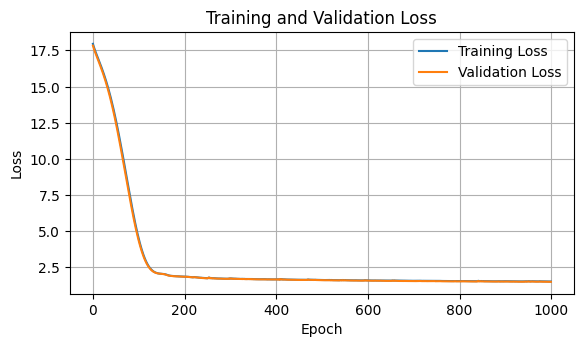

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.0232, Val Loss: 18.0019, best model epoch: 10
Epoch: 20, Train Loss: 17.9350, Val Loss: 17.9032, best model epoch: 20
Epoch: 30, Train Loss: 17.8489, Val Loss: 17.8066, best model epoch: 30
Epoch: 40, Train Loss: 17.7632, Val Loss: 17.7113, best model epoch: 40
Epoch: 50, Train Loss: 17.6779, Val Loss: 17.6170, best model epoch: 50
Epoch: 60, Train Loss: 17.5912, Val Loss: 17.5211, best model epoch: 60
Epoch: 70, Train Loss: 17.5020, Val Loss: 17.4278, best model epoch: 70
Epoch: 80, Train Loss: 17.4138, Val Loss: 17.3354, best model epoch: 80
Epoch: 90, Train Loss: 17.3254, Val Loss: 17.2409, best model epoch: 90
Epoch: 100, Train Loss: 17.2353, Val Loss: 17.1444, best model epoch: 100
Epoch: 110, Train Loss: 17.1422, Val Loss: 17.0470, best model epoch: 110
Epoch: 120, Train Loss: 17.0472, Val Loss: 16.9469, best model epoch: 120
Epoch: 130, Train Loss: 16.9501, Val Loss: 16.8456, best model epoch: 130
Epoch:

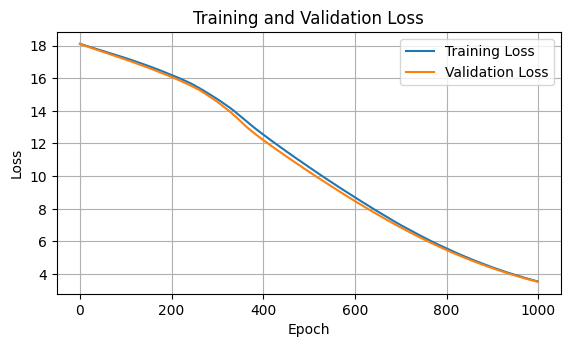

hidden_dim: 128 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 17.9160, Val Loss: 17.8904, best model epoch: 10
Epoch: 20, Train Loss: 17.8084, Val Loss: 17.7725, best model epoch: 20
Epoch: 30, Train Loss: 17.7035, Val Loss: 17.6534, best model epoch: 30
Epoch: 40, Train Loss: 17.5960, Val Loss: 17.5323, best model epoch: 40
Epoch: 50, Train Loss: 17.4865, Val Loss: 17.4115, best model epoch: 50
Epoch: 60, Train Loss: 17.3729, Val Loss: 17.2907, best model epoch: 60
Epoch: 70, Train Loss: 17.2591, Val Loss: 17.1715, best model epoch: 70
Epoch: 80, Train Loss: 17.1456, Val Loss: 17.0550, best model epoch: 80
Epoch: 90, Train Loss: 17.0298, Val Loss: 16.9367, best model epoch: 90
Epoch: 100, Train Loss: 16.9129, Val Loss: 16.8172, best model epoch: 100
Epoch: 110, Train Loss: 16.7946, Val Loss: 16.6979, best model epoch: 110
Epoch: 120, Train Loss: 16.6739, Val Loss: 16.5745, best model epoch: 120
Epoch: 130, Train Loss: 16.5528, Val Loss: 16.4491, best model epoch: 130
Epoch:

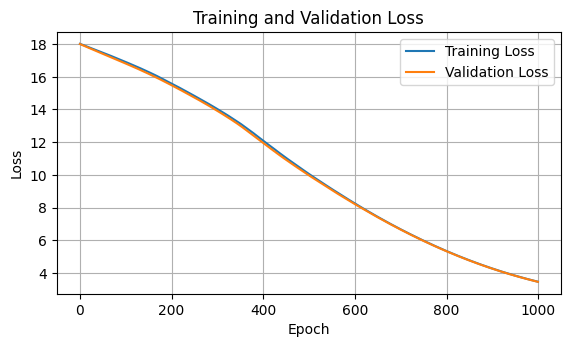

In [ ]:
# GATv2 grid search
GATv2_results_part1 = []
for indx, row in GATv2_grid_params_part1.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part1.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))

In [ ]:
pd.DataFrame(GATv2_results_part1).to_excel('GATv2_p1_results.xlsx')
pd.DataFrame(GATv2_results_part1)

hidden_dim  dropout_prob      lr  heads  best test loss  \
0           32           0.1  0.0010      1        0.123584   
1           32           0.1  0.0010      2        0.105962   
2           32           0.1  0.0001      1       13.219307   
3           32           0.1  0.0001      2       12.249327   
4           32           0.3  0.0010      1        1.621723   
5           32           0.3  0.0010      2        0.180334   
6           32           0.3  0.0001      1       10.014080   
7           32           0.3  0.0001      2       10.696685   
8          128           0.1  0.0010      1        1.518719   
9          128           0.1  0.0010      2        0.097507   
10         128           0.1  0.0001      1        3.430251   
11         128           0.1  0.0001      2        3.898951   
12         128           0.3  0.0010      1        0.125057   
13         128           0.3  0.0010      2        1.509817   
14         128           0.3  0.0001      1        3.519437   
15         128           0.3  0.0001      2        3.456611   

    best test loss epoch  corr_train_loss  
0                    999         0.143453  
1                   1000         0.122150  
2                   1000        13.253599  
3                   1000        12.274336  
4                    998         1.636597  
5                    984         0.185582  
6                   1000        10.106217  
7                   1000        10.704357  
8                    991         1.534519  
9                    995         0.106050  
10                  1000         3.459512  
11                  1000         3.907683  
12                   933         0.143927  
13                   999         1.532267  
14                  1000         3.540048  
15                  1000         3.463802

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 16.4859, Val Loss: 16.3777, best model epoch: 10
Epoch: 20, Train Loss: 15.7278, Val Loss: 15.5994, best model epoch: 20
Epoch: 30, Train Loss: 14.8912, Val Loss: 14.7464, best model epoch: 30
Epoch: 40, Train Loss: 13.9344, Val Loss: 13.7764, best model epoch: 40
Epoch: 50, Train Loss: 12.8481, Val Loss: 12.6714, best model epoch: 50
Epoch: 60, Train Loss: 11.6528, Val Loss: 11.4639, best model epoch: 60
Epoch: 70, Train Loss: 10.3638, Val Loss: 10.1645, best model epoch: 70
Epoch: 80, Train Loss: 9.0188, Val Loss: 8.8137, best model epoch: 80
Epoch: 90, Train Loss: 7.6828, Val Loss: 7.4882, best model epoch: 90
Epoch: 100, Train Loss: 6.4305, Val Loss: 6.2571, best model epoch: 100
Epoch: 110, Train Loss: 5.3045, Val Loss: 5.1535, best model epoch: 110
Epoch: 120, Train Loss: 4.3375, Val Loss: 4.2085, best model epoch: 120
Epoch: 130, Train Loss: 3.5461, Val Loss: 3.4409, best model epoch: 130
Epoch: 140, Train Lo

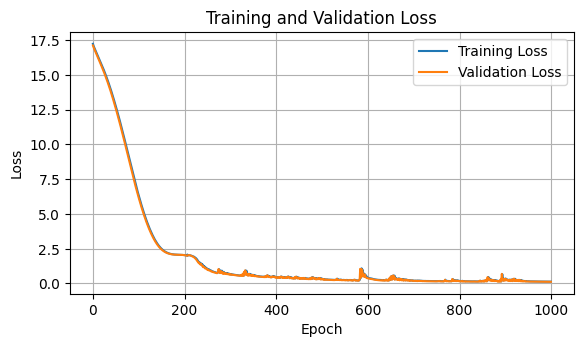

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 18.3315, Val Loss: 18.2578, best model epoch: 10
Epoch: 20, Train Loss: 17.7708, Val Loss: 17.6886, best model epoch: 20
Epoch: 30, Train Loss: 17.1497, Val Loss: 17.0591, best model epoch: 30
Epoch: 40, Train Loss: 16.3978, Val Loss: 16.2814, best model epoch: 40
Epoch: 50, Train Loss: 15.4408, Val Loss: 15.2861, best model epoch: 50
Epoch: 60, Train Loss: 14.3169, Val Loss: 14.1475, best model epoch: 60
Epoch: 70, Train Loss: 13.1101, Val Loss: 12.9324, best model epoch: 70
Epoch: 80, Train Loss: 11.8262, Val Loss: 11.6477, best model epoch: 80
Epoch: 90, Train Loss: 10.5055, Val Loss: 10.3349, best model epoch: 90
Epoch: 100, Train Loss: 9.1978, Val Loss: 9.0340, best model epoch: 100
Epoch: 110, Train Loss: 7.9321, Val Loss: 7.7830, best model epoch: 110
Epoch: 120, Train Loss: 6.7514, Val Loss: 6.6184, best model epoch: 120
Epoch: 130, Train Loss: 5.6884, Val Loss: 5.5721, best model epoch: 130
Epoch: 140, Trai

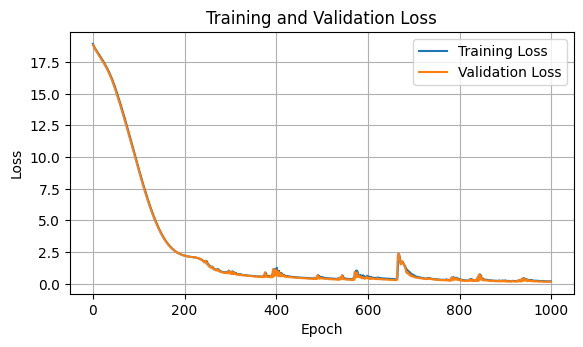

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.0916, Val Loss: 17.0749, best model epoch: 10
Epoch: 20, Train Loss: 16.9956, Val Loss: 16.9758, best model epoch: 20
Epoch: 30, Train Loss: 16.8950, Val Loss: 16.8685, best model epoch: 30
Epoch: 40, Train Loss: 16.7860, Val Loss: 16.7523, best model epoch: 40
Epoch: 50, Train Loss: 16.6794, Val Loss: 16.6409, best model epoch: 50
Epoch: 60, Train Loss: 16.5778, Val Loss: 16.5359, best model epoch: 60
Epoch: 70, Train Loss: 16.4799, Val Loss: 16.4343, best model epoch: 70
Epoch: 80, Train Loss: 16.3812, Val Loss: 16.3317, best model epoch: 80
Epoch: 90, Train Loss: 16.2837, Val Loss: 16.2309, best model epoch: 90
Epoch: 100, Train Loss: 16.1864, Val Loss: 16.1307, best model epoch: 100
Epoch: 110, Train Loss: 16.0885, Val Loss: 16.0305, best model epoch: 110
Epoch: 120, Train Loss: 15.9892, Val Loss: 15.9259, best model epoch: 120
Epoch: 130, Train Loss: 15.8881, Val Loss: 15.8214, best model epoch: 130
Epoch: 

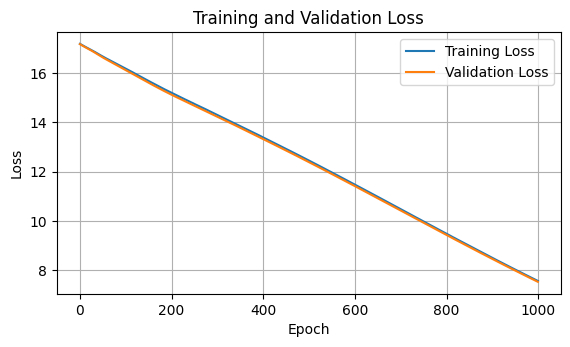

hidden_dim: 64 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 17.8424, Val Loss: 17.8237, best model epoch: 10
Epoch: 20, Train Loss: 17.7497, Val Loss: 17.7301, best model epoch: 20
Epoch: 30, Train Loss: 17.6586, Val Loss: 17.6355, best model epoch: 30
Epoch: 40, Train Loss: 17.5657, Val Loss: 17.5385, best model epoch: 40
Epoch: 50, Train Loss: 17.4708, Val Loss: 17.4417, best model epoch: 50
Epoch: 60, Train Loss: 17.3722, Val Loss: 17.3399, best model epoch: 60
Epoch: 70, Train Loss: 17.2662, Val Loss: 17.2290, best model epoch: 70
Epoch: 80, Train Loss: 17.1528, Val Loss: 17.1100, best model epoch: 80
Epoch: 90, Train Loss: 17.0315, Val Loss: 16.9850, best model epoch: 90
Epoch: 100, Train Loss: 16.9071, Val Loss: 16.8560, best model epoch: 100
Epoch: 110, Train Loss: 16.7815, Val Loss: 16.7265, best model epoch: 110
Epoch: 120, Train Loss: 16.6529, Val Loss: 16.5955, best model epoch: 120
Epoch: 130, Train Loss: 16.5310, Val Loss: 16.4737, best model epoch: 130
Epoch: 

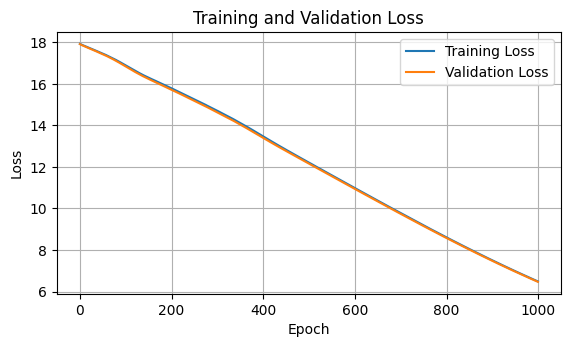

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 18.6095, Val Loss: 18.4779, best model epoch: 10
Epoch: 20, Train Loss: 18.0979, Val Loss: 17.9680, best model epoch: 20
Epoch: 30, Train Loss: 17.6034, Val Loss: 17.4622, best model epoch: 30
Epoch: 40, Train Loss: 17.0662, Val Loss: 16.9167, best model epoch: 40
Epoch: 50, Train Loss: 16.4592, Val Loss: 16.2933, best model epoch: 50
Epoch: 60, Train Loss: 15.7588, Val Loss: 15.5648, best model epoch: 60
Epoch: 70, Train Loss: 14.9260, Val Loss: 14.7024, best model epoch: 70
Epoch: 80, Train Loss: 13.9507, Val Loss: 13.7014, best model epoch: 80
Epoch: 90, Train Loss: 12.8472, Val Loss: 12.5888, best model epoch: 90
Epoch: 100, Train Loss: 11.6668, Val Loss: 11.4161, best model epoch: 100
Epoch: 110, Train Loss: 10.4517, Val Loss: 10.2229, best model epoch: 110
Epoch: 120, Train Loss: 9.2494, Val Loss: 9.0424, best model epoch: 120
Epoch: 130, Train Loss: 8.0823, Val Loss: 7.9035, best model epoch: 130
Epoch: 140, 

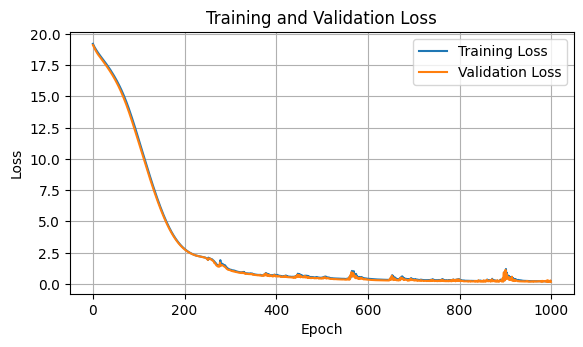

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 16.6457, Val Loss: 16.5299, best model epoch: 10
Epoch: 20, Train Loss: 15.9130, Val Loss: 15.7643, best model epoch: 20
Epoch: 30, Train Loss: 15.0656, Val Loss: 14.8928, best model epoch: 30
Epoch: 40, Train Loss: 14.1273, Val Loss: 13.9307, best model epoch: 40
Epoch: 50, Train Loss: 13.0886, Val Loss: 12.8786, best model epoch: 50
Epoch: 60, Train Loss: 11.9421, Val Loss: 11.7211, best model epoch: 60
Epoch: 70, Train Loss: 10.7057, Val Loss: 10.4912, best model epoch: 70
Epoch: 80, Train Loss: 9.4141, Val Loss: 9.2067, best model epoch: 80
Epoch: 90, Train Loss: 8.1011, Val Loss: 7.8963, best model epoch: 90
Epoch: 100, Train Loss: 6.7672, Val Loss: 6.5673, best model epoch: 100
Epoch: 110, Train Loss: 5.4478, Val Loss: 5.2721, best model epoch: 110
Epoch: 120, Train Loss: 4.3047, Val Loss: 4.1736, best model epoch: 120
Epoch: 130, Train Loss: 3.4132, Val Loss: 3.3224, best model epoch: 130
Epoch: 140, Train Lo

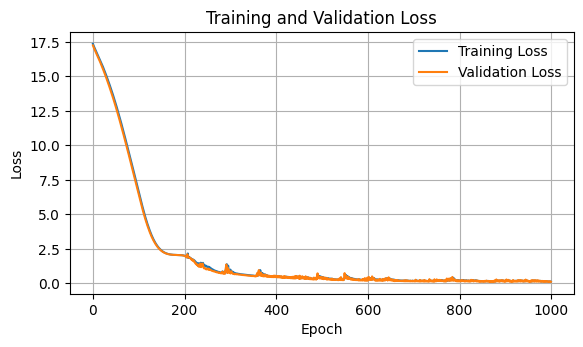

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 19.0696, Val Loss: 19.0391, best model epoch: 10
Epoch: 20, Train Loss: 18.9704, Val Loss: 18.9218, best model epoch: 20
Epoch: 30, Train Loss: 18.8733, Val Loss: 18.8157, best model epoch: 30
Epoch: 40, Train Loss: 18.7816, Val Loss: 18.7128, best model epoch: 40
Epoch: 50, Train Loss: 18.6881, Val Loss: 18.6096, best model epoch: 50
Epoch: 60, Train Loss: 18.5910, Val Loss: 18.5070, best model epoch: 60
Epoch: 70, Train Loss: 18.4961, Val Loss: 18.4062, best model epoch: 70
Epoch: 80, Train Loss: 18.4032, Val Loss: 18.3081, best model epoch: 80
Epoch: 90, Train Loss: 18.3111, Val Loss: 18.2126, best model epoch: 90
Epoch: 100, Train Loss: 18.2242, Val Loss: 18.1216, best model epoch: 100
Epoch: 110, Train Loss: 18.1407, Val Loss: 18.0336, best model epoch: 110
Epoch: 120, Train Loss: 18.0548, Val Loss: 17.9446, best model epoch: 120
Epoch: 130, Train Loss: 17.9694, Val Loss: 17.8565, best model epoch: 130
Epoch: 

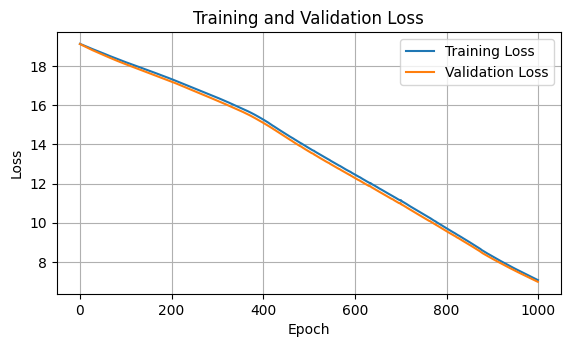

hidden_dim: 64 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.3330, Val Loss: 18.3116, best model epoch: 10
Epoch: 20, Train Loss: 18.2345, Val Loss: 18.2072, best model epoch: 20
Epoch: 30, Train Loss: 18.1475, Val Loss: 18.1165, best model epoch: 30
Epoch: 40, Train Loss: 18.0671, Val Loss: 18.0334, best model epoch: 40
Epoch: 50, Train Loss: 17.9866, Val Loss: 17.9455, best model epoch: 50
Epoch: 60, Train Loss: 17.9007, Val Loss: 17.8510, best model epoch: 60
Epoch: 70, Train Loss: 17.8097, Val Loss: 17.7504, best model epoch: 70
Epoch: 80, Train Loss: 17.7135, Val Loss: 17.6473, best model epoch: 80
Epoch: 90, Train Loss: 17.6161, Val Loss: 17.5415, best model epoch: 90
Epoch: 100, Train Loss: 17.5143, Val Loss: 17.4330, best model epoch: 100
Epoch: 110, Train Loss: 17.4090, Val Loss: 17.3180, best model epoch: 110
Epoch: 120, Train Loss: 17.2980, Val Loss: 17.2011, best model epoch: 120
Epoch: 130, Train Loss: 17.1862, Val Loss: 17.0840, best model epoch: 130
Epoch: 

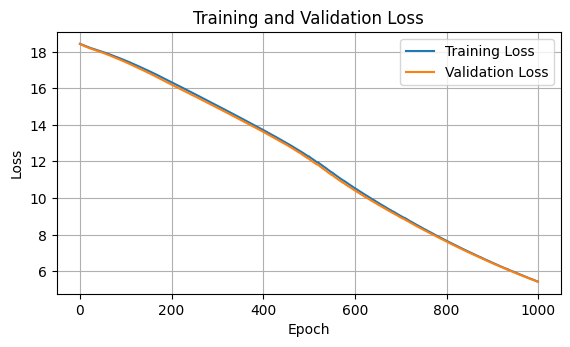

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.2062, Val Loss: 17.0838, best model epoch: 10
Epoch: 20, Train Loss: 15.9793, Val Loss: 15.8309, best model epoch: 20
Epoch: 30, Train Loss: 14.5212, Val Loss: 14.3398, best model epoch: 30
Epoch: 40, Train Loss: 12.7365, Val Loss: 12.5187, best model epoch: 40
Epoch: 50, Train Loss: 10.6673, Val Loss: 10.4250, best model epoch: 50
Epoch: 60, Train Loss: 8.4644, Val Loss: 8.2179, best model epoch: 60
Epoch: 70, Train Loss: 6.3397, Val Loss: 6.1153, best model epoch: 70
Epoch: 80, Train Loss: 4.5138, Val Loss: 4.3354, best model epoch: 80
Epoch: 90, Train Loss: 3.1717, Val Loss: 3.0547, best model epoch: 90
Epoch: 100, Train Loss: 2.3925, Val Loss: 2.3358, best model epoch: 100
Epoch: 110, Train Loss: 2.0955, Val Loss: 2.0817, best model epoch: 110
Epoch: 120, Train Loss: 2.0574, Val Loss: 2.0585, best model epoch: 117
Epoch: 130, Train Loss: 2.0341, Val Loss: 2.0267, best model epoch: 130
Epoch: 140, Train Loss:

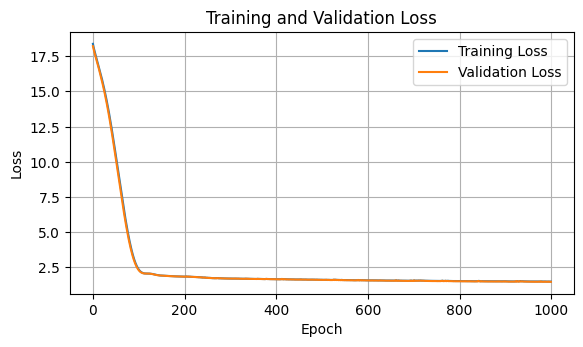

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.001


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.08 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.52 GiB is free. Process 5191 has 13.22 GiB memory in use. Of the allocated memory 12.46 GiB is allocated by PyTorch, and 643.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# GATv2 grid search
GATv2_results_part2 = []
for indx, row in GATv2_grid_params_part2.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part2.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))

In [ ]:
pd.DataFrame(GATv2_results_part2).to_excel('GATv2_p2_results.xlsx')
pd.DataFrame(GATv2_results_part2)

hidden_dim  dropout_prob      lr  heads  best test loss  \
0          64           0.1  0.0010      1        0.116233   
1          64           0.1  0.0010      2        0.148713   
2          64           0.1  0.0001      1        7.519832   
3          64           0.1  0.0001      2        6.467010   
4          64           0.3  0.0010      1        0.161886   
5          64           0.3  0.0010      2        0.120189   
6          64           0.3  0.0001      1        6.964373   
7          64           0.3  0.0001      2        5.419080   
8         256           0.1  0.0010      1        1.469547   

   best test loss epoch  corr_train_loss  
0                   998         0.129493  
1                   998         0.189197  
2                  1000         7.555917  
3                  1000         6.487539  
4                  1000         0.202414  
5                   997         0.135979  
6                  1000         7.052182  
7                  1000         5.432681  
8                  1000         1.485121

In [ ]:
# GATv2 grid search
GATv2_results_part3 = []
for indx, row in GATv2_grid_params_part3.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part3.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))

hidden_dim: 256 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.0326, Val Loss: 16.8952, best model epoch: 10
Epoch: 20, Train Loss: 15.8180, Val Loss: 15.6518, best model epoch: 20
Epoch: 30, Train Loss: 14.3211, Val Loss: 14.1153, best model epoch: 30
Epoch: 40, Train Loss: 12.4961, Val Loss: 12.2544, best model epoch: 40
Epoch: 50, Train Loss: 10.3924, Val Loss: 10.1246, best model epoch: 50
Epoch: 60, Train Loss: 8.1277, Val Loss: 7.8538, best model epoch: 60
Epoch: 70, Train Loss: 5.9372, Val Loss: 5.6916, best model epoch: 70
Epoch: 80, Train Loss: 4.1133, Val Loss: 3.9254, best model epoch: 80
Epoch: 90, Train Loss: 2.8652, Val Loss: 2.7562, best model epoch: 90
Epoch: 100, Train Loss: 2.2395, Val Loss: 2.1956, best model epoch: 100
Epoch: 110, Train Loss: 2.0641, Val Loss: 2.0595, best model epoch: 110
Epoch: 120, Train Loss: 2.0237, Val Loss: 2.0014, best model epoch: 120
Epoch: 130, Train Loss: 1.9225, Val Loss: 1.9172, best model epoch: 129
Epoch: 140, Train Loss:

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.04 GiB. GPU 0 has a total capacity of 14.74 GiB of which 1.02 GiB is free. Process 18357 has 13.72 GiB memory in use. Of the allocated memory 11.26 GiB is allocated by PyTorch, and 2.33 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 16.8799, Val Loss: 16.8380, best model epoch: 10
Epoch: 20, Train Loss: 16.5384, Val Loss: 16.4908, best model epoch: 20
Epoch: 30, Train Loss: 16.2105, Val Loss: 16.1553, best model epoch: 30
Epoch: 40, Train Loss: 15.8714, Val Loss: 15.8122, best model epoch: 40
Epoch: 50, Train Loss: 15.5007, Val Loss: 15.4300, best model epoch: 50
Epoch: 60, Train Loss: 15.0889, Val Loss: 15.0021, best model epoch: 60
Epoch: 70, Train Loss: 14.6349, Val Loss: 14.5342, best model epoch: 70
Epoch: 80, Train Loss: 14.1330, Val Loss: 14.0261, best model epoch: 80
Epoch: 90, Train Loss: 13.5789, Val Loss: 13.4643, best model epoch: 90
Epoch: 100, Train Loss: 12.9678, Val Loss: 12.8524, best model epoch: 100
Epoch: 110, Train Loss: 12.3137, Val Loss: 12.1890, best model epoch: 110
Epoch: 120, Train Loss: 11.6157, Val Loss: 11.4812, best model epoch: 120
Epoch: 130, Train Loss: 10.8823, Val Loss: 10.7388, best model epoch: 130
Epoch: 1

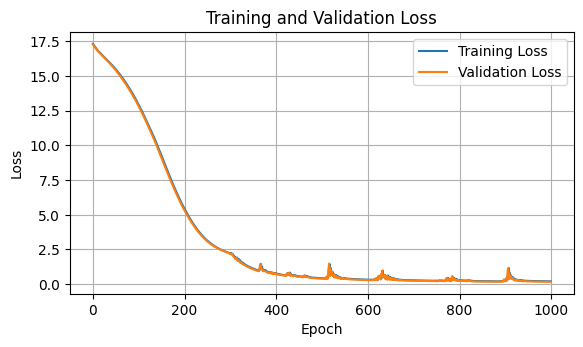

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.001
Epoch: 10, Train Loss: 17.3807, Val Loss: 17.3364, best model epoch: 10
Epoch: 20, Train Loss: 17.0380, Val Loss: 17.0000, best model epoch: 20
Epoch: 30, Train Loss: 16.7566, Val Loss: 16.7073, best model epoch: 30
Epoch: 40, Train Loss: 16.4597, Val Loss: 16.4067, best model epoch: 40
Epoch: 50, Train Loss: 16.1529, Val Loss: 16.0972, best model epoch: 50
Epoch: 60, Train Loss: 15.8338, Val Loss: 15.7785, best model epoch: 60
Epoch: 70, Train Loss: 15.5117, Val Loss: 15.4502, best model epoch: 70
Epoch: 80, Train Loss: 15.1628, Val Loss: 15.0984, best model epoch: 80
Epoch: 90, Train Loss: 14.7867, Val Loss: 14.7210, best model epoch: 90
Epoch: 100, Train Loss: 14.3848, Val Loss: 14.3142, best model epoch: 100
Epoch: 110, Train Loss: 13.9492, Val Loss: 13.8735, best model epoch: 110
Epoch: 120, Train Loss: 13.4762, Val Loss: 13.3986, best model epoch: 120
Epoch: 130, Train Loss: 12.9718, Val Loss: 12.8950, best model epoch: 130
Epoch: 1

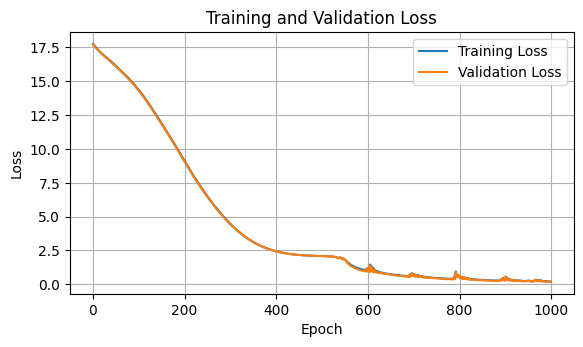

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 16.6363, Val Loss: 16.6415, best model epoch: 10
Epoch: 20, Train Loss: 16.5537, Val Loss: 16.5540, best model epoch: 20
Epoch: 30, Train Loss: 16.4770, Val Loss: 16.4730, best model epoch: 30
Epoch: 40, Train Loss: 16.4088, Val Loss: 16.4009, best model epoch: 40
Epoch: 50, Train Loss: 16.3476, Val Loss: 16.3348, best model epoch: 50
Epoch: 60, Train Loss: 16.2873, Val Loss: 16.2703, best model epoch: 60
Epoch: 70, Train Loss: 16.2273, Val Loss: 16.2070, best model epoch: 70
Epoch: 80, Train Loss: 16.1683, Val Loss: 16.1449, best model epoch: 80
Epoch: 90, Train Loss: 16.1084, Val Loss: 16.0828, best model epoch: 90
Epoch: 100, Train Loss: 16.0474, Val Loss: 16.0197, best model epoch: 100
Epoch: 110, Train Loss: 15.9863, Val Loss: 15.9564, best model epoch: 110
Epoch: 120, Train Loss: 15.9256, Val Loss: 15.8934, best model epoch: 120
Epoch: 130, Train Loss: 15.8637, Val Loss: 15.8301, best model epoch: 130
Epoch: 

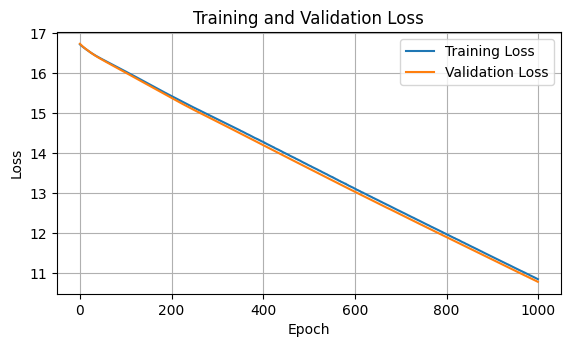

hidden_dim: 16 | dropout_prob: 0.1  | lr: 0.0001
Epoch: 10, Train Loss: 19.4534, Val Loss: 19.3751, best model epoch: 10
Epoch: 20, Train Loss: 19.3624, Val Loss: 19.2650, best model epoch: 20
Epoch: 30, Train Loss: 19.2634, Val Loss: 19.1441, best model epoch: 30
Epoch: 40, Train Loss: 19.1659, Val Loss: 19.0268, best model epoch: 40
Epoch: 50, Train Loss: 19.0681, Val Loss: 18.9186, best model epoch: 50
Epoch: 60, Train Loss: 18.9760, Val Loss: 18.8296, best model epoch: 60
Epoch: 70, Train Loss: 18.8864, Val Loss: 18.7488, best model epoch: 70
Epoch: 80, Train Loss: 18.8064, Val Loss: 18.6702, best model epoch: 80
Epoch: 90, Train Loss: 18.7283, Val Loss: 18.5916, best model epoch: 90
Epoch: 100, Train Loss: 18.6524, Val Loss: 18.5132, best model epoch: 100
Epoch: 110, Train Loss: 18.5782, Val Loss: 18.4362, best model epoch: 110
Epoch: 120, Train Loss: 18.5023, Val Loss: 18.3589, best model epoch: 120
Epoch: 130, Train Loss: 18.4194, Val Loss: 18.2761, best model epoch: 130
Epoch: 

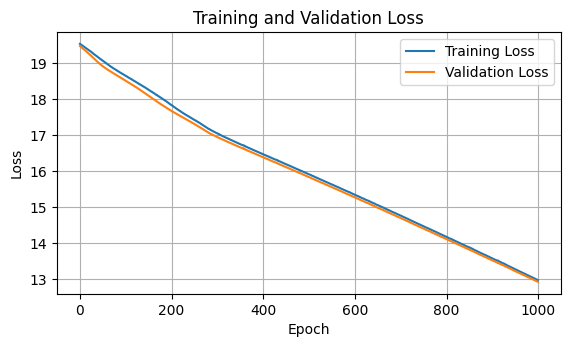

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 16.1722, Val Loss: 16.0739, best model epoch: 10
Epoch: 20, Train Loss: 15.7612, Val Loss: 15.6646, best model epoch: 20
Epoch: 30, Train Loss: 15.3941, Val Loss: 15.2768, best model epoch: 30
Epoch: 40, Train Loss: 15.0165, Val Loss: 14.8863, best model epoch: 40
Epoch: 50, Train Loss: 14.6147, Val Loss: 14.4743, best model epoch: 50
Epoch: 60, Train Loss: 14.1753, Val Loss: 14.0374, best model epoch: 60
Epoch: 70, Train Loss: 13.7236, Val Loss: 13.5844, best model epoch: 70
Epoch: 80, Train Loss: 13.2413, Val Loss: 13.0891, best model epoch: 80
Epoch: 90, Train Loss: 12.7037, Val Loss: 12.5426, best model epoch: 90
Epoch: 100, Train Loss: 12.1274, Val Loss: 11.9454, best model epoch: 100
Epoch: 110, Train Loss: 11.5019, Val Loss: 11.3045, best model epoch: 110
Epoch: 120, Train Loss: 10.8279, Val Loss: 10.6326, best model epoch: 120
Epoch: 130, Train Loss: 10.1314, Val Loss: 9.9314, best model epoch: 130
Epoch: 14

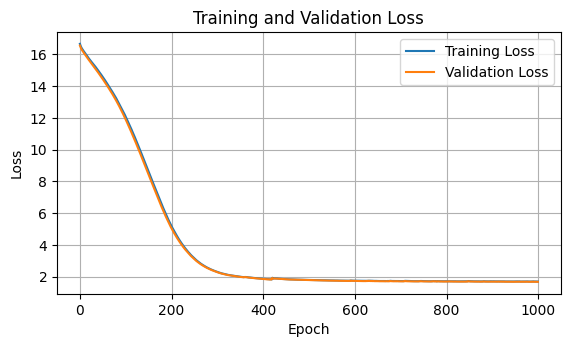

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.001
Epoch: 10, Train Loss: 16.2779, Val Loss: 16.2615, best model epoch: 10
Epoch: 20, Train Loss: 16.1039, Val Loss: 16.0706, best model epoch: 20
Epoch: 30, Train Loss: 15.8812, Val Loss: 15.8264, best model epoch: 30
Epoch: 40, Train Loss: 15.6784, Val Loss: 15.6187, best model epoch: 40
Epoch: 50, Train Loss: 15.4951, Val Loss: 15.4389, best model epoch: 50
Epoch: 60, Train Loss: 15.3116, Val Loss: 15.2583, best model epoch: 60
Epoch: 70, Train Loss: 15.1301, Val Loss: 15.0813, best model epoch: 70
Epoch: 80, Train Loss: 14.9415, Val Loss: 14.8929, best model epoch: 80
Epoch: 90, Train Loss: 14.7480, Val Loss: 14.6985, best model epoch: 90
Epoch: 100, Train Loss: 14.5273, Val Loss: 14.4787, best model epoch: 100
Epoch: 110, Train Loss: 14.2915, Val Loss: 14.2398, best model epoch: 110
Epoch: 120, Train Loss: 14.0113, Val Loss: 13.9636, best model epoch: 120
Epoch: 130, Train Loss: 13.7060, Val Loss: 13.6504, best model epoch: 130
Epoch: 1

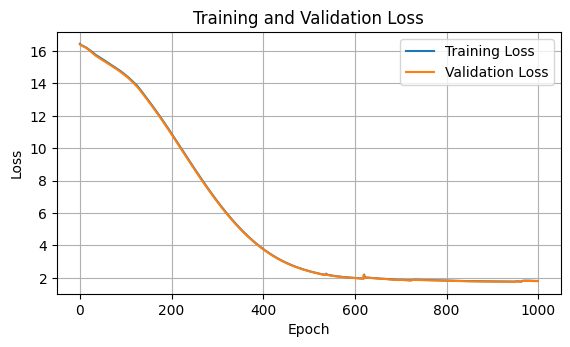

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.9038, Val Loss: 18.8754, best model epoch: 10
Epoch: 20, Train Loss: 18.8600, Val Loss: 18.8154, best model epoch: 20
Epoch: 30, Train Loss: 18.8209, Val Loss: 18.7727, best model epoch: 30
Epoch: 40, Train Loss: 18.7876, Val Loss: 18.7312, best model epoch: 40
Epoch: 50, Train Loss: 18.7463, Val Loss: 18.6828, best model epoch: 50
Epoch: 60, Train Loss: 18.6921, Val Loss: 18.6244, best model epoch: 60
Epoch: 70, Train Loss: 18.5884, Val Loss: 18.5494, best model epoch: 70
Epoch: 80, Train Loss: 18.5289, Val Loss: 18.4844, best model epoch: 80
Epoch: 90, Train Loss: 18.4707, Val Loss: 18.4190, best model epoch: 90
Epoch: 100, Train Loss: 18.4107, Val Loss: 18.3476, best model epoch: 100
Epoch: 110, Train Loss: 18.3513, Val Loss: 18.2790, best model epoch: 110
Epoch: 120, Train Loss: 18.2950, Val Loss: 18.2155, best model epoch: 120
Epoch: 130, Train Loss: 18.2455, Val Loss: 18.1509, best model epoch: 130
Epoch: 

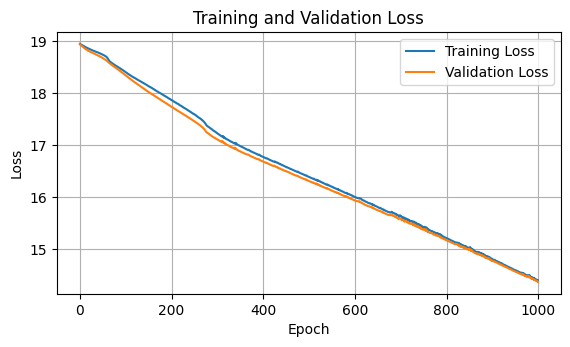

hidden_dim: 16 | dropout_prob: 0.3  | lr: 0.0001
Epoch: 10, Train Loss: 18.7914, Val Loss: 18.7249, best model epoch: 10
Epoch: 20, Train Loss: 18.6393, Val Loss: 18.5504, best model epoch: 20
Epoch: 30, Train Loss: 18.4977, Val Loss: 18.3952, best model epoch: 30
Epoch: 40, Train Loss: 18.3745, Val Loss: 18.2633, best model epoch: 40
Epoch: 50, Train Loss: 18.2755, Val Loss: 18.1517, best model epoch: 50
Epoch: 60, Train Loss: 18.1817, Val Loss: 18.0197, best model epoch: 60
Epoch: 70, Train Loss: 18.0900, Val Loss: 17.9000, best model epoch: 70
Epoch: 80, Train Loss: 18.0095, Val Loss: 17.8037, best model epoch: 80
Epoch: 90, Train Loss: 17.9284, Val Loss: 17.7244, best model epoch: 90
Epoch: 100, Train Loss: 17.8562, Val Loss: 17.6499, best model epoch: 100
Epoch: 110, Train Loss: 17.7805, Val Loss: 17.5763, best model epoch: 110
Epoch: 120, Train Loss: 17.7042, Val Loss: 17.5022, best model epoch: 120
Epoch: 130, Train Loss: 17.6248, Val Loss: 17.4272, best model epoch: 130
Epoch: 

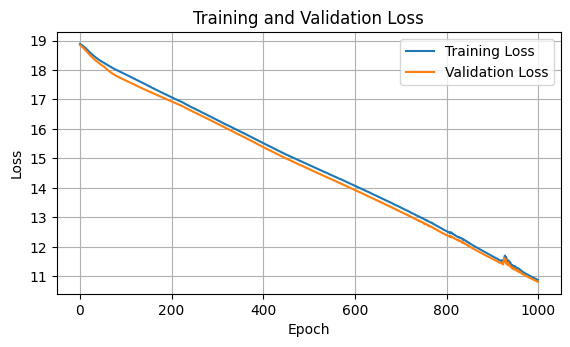

In [ ]:
# GATv2 grid search
GATv2_results_part4 = []
for indx, row in GATv2_grid_params_part4.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part4.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))

In [ ]:
pd.DataFrame(GATv2_results_part4).to_excel('GATv2_p4_results.xlsx')
pd.DataFrame(GATv2_results_part4)

hidden_dim  dropout_prob      lr  heads  best test loss  \
0          16           0.1  0.0010      1        0.166986   
1          16           0.1  0.0010      2        0.183417   
2          16           0.1  0.0001      1       10.777419   
3          16           0.1  0.0001      2       12.935457   
4          16           0.3  0.0010      1        1.666577   
5          16           0.3  0.0010      2        1.750290   
6          16           0.3  0.0001      1       14.363562   
7          16           0.3  0.0001      2       10.806293   

   best test loss epoch  corr_train_loss  
0                   999         0.201361  
1                   996         0.214316  
2                  1000        10.843814  
3                  1000        12.983275  
4                  1000         1.683124  
5                   949         1.762765  
6                  1000        14.393480  
7                  1000        10.869763

Can't run more hidden_dim >= 256 without crashing from lack of memory

More params added to be tested

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 13.8266, Val Loss: 12.9792, best model epoch: 10
Epoch: 20, Train Loss: 6.8660, Val Loss: 6.0078, best model epoch: 20
Epoch: 30, Train Loss: 2.1561, Val Loss: 2.0684, best model epoch: 30
Epoch: 40, Train Loss: 2.5734, Val Loss: 2.5529, best model epoch: 31
Epoch: 50, Train Loss: 2.0954, Val Loss: 2.0979, best model epoch: 47
Epoch: 60, Train Loss: 2.0669, Val Loss: 2.0587, best model epoch: 60
Epoch: 70, Train Loss: 2.0686, Val Loss: 2.0721, best model epoch: 61
Epoch: 80, Train Loss: 2.0593, Val Loss: 2.0582, best model epoch: 61
Epoch: 90, Train Loss: 2.0594, Val Loss: 2.0582, best model epoch: 89
Epoch: 100, Train Loss: 2.0592, Val Loss: 2.0599, best model epoch: 89
Epoch: 110, Train Loss: 2.0584, Val Loss: 2.0584, best model epoch: 89
Epoch: 120, Train Loss: 2.0587, Val Loss: 2.0584, best model epoch: 89
Epoch: 130, Train Loss: 2.0584, Val Loss: 2.0587, best model epoch: 89
Epoch: 140, Train Loss: 2.0581, Val L

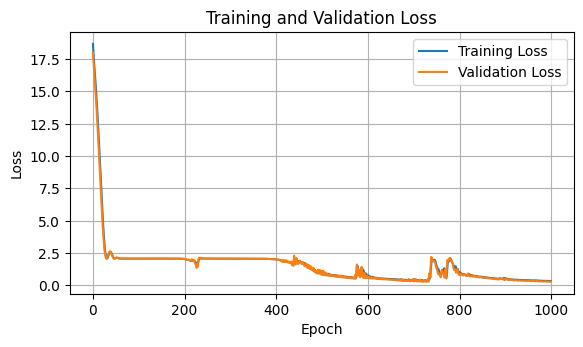

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 15.6808, Val Loss: 15.0171, best model epoch: 10
Epoch: 20, Train Loss: 9.1526, Val Loss: 8.3718, best model epoch: 20
Epoch: 30, Train Loss: 3.0451, Val Loss: 2.6905, best model epoch: 30
Epoch: 40, Train Loss: 2.3877, Val Loss: 2.4759, best model epoch: 34
Epoch: 50, Train Loss: 2.0870, Val Loss: 2.1021, best model epoch: 48
Epoch: 60, Train Loss: 2.0616, Val Loss: 2.0687, best model epoch: 48
Epoch: 70, Train Loss: 2.0607, Val Loss: 2.0610, best model epoch: 48
Epoch: 80, Train Loss: 2.0620, Val Loss: 2.0584, best model epoch: 48
Epoch: 90, Train Loss: 2.0601, Val Loss: 2.0623, best model epoch: 48
Epoch: 100, Train Loss: 2.0591, Val Loss: 2.0584, best model epoch: 48
Epoch: 110, Train Loss: 2.0590, Val Loss: 2.0590, best model epoch: 48
Epoch: 120, Train Loss: 2.0580, Val Loss: 2.0585, best model epoch: 48
Epoch: 130, Train Loss: 2.0582, Val Loss: 2.0583, best model epoch: 48
Epoch: 140, Train Loss: 2.0586, Val L

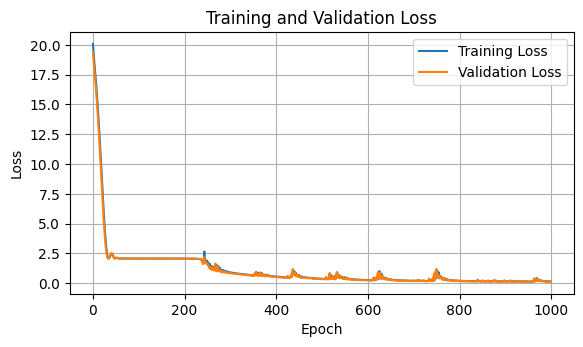

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 18.3993, Val Loss: 18.3274, best model epoch: 10
Epoch: 20, Train Loss: 18.1935, Val Loss: 18.1167, best model epoch: 20
Epoch: 30, Train Loss: 18.0132, Val Loss: 17.9274, best model epoch: 30
Epoch: 40, Train Loss: 17.8346, Val Loss: 17.7452, best model epoch: 40
Epoch: 50, Train Loss: 17.6416, Val Loss: 17.5390, best model epoch: 50
Epoch: 60, Train Loss: 17.4338, Val Loss: 17.3234, best model epoch: 60
Epoch: 70, Train Loss: 17.2147, Val Loss: 17.1041, best model epoch: 70
Epoch: 80, Train Loss: 16.9947, Val Loss: 16.8761, best model epoch: 80
Epoch: 90, Train Loss: 16.7600, Val Loss: 16.6329, best model epoch: 90
Epoch: 100, Train Loss: 16.5104, Val Loss: 16.3793, best model epoch: 100
Epoch: 110, Train Loss: 16.2499, Val Loss: 16.1115, best model epoch: 110
Epoch: 120, Train Loss: 15.9790, Val Loss: 15.8364, best model epoch: 120
Epoch: 130, Train Loss: 15.6932, Val Loss: 15.5444, best model epoch: 130
Epoch: 

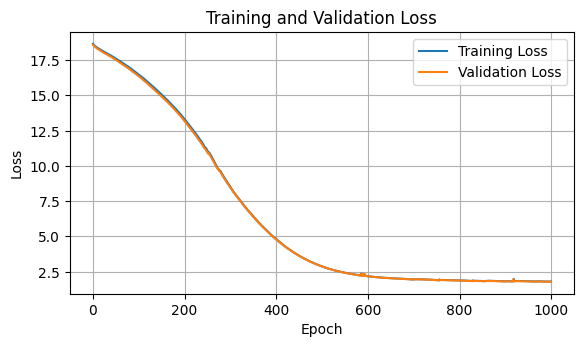

hidden_dim: 32 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.4405, Val Loss: 17.3148, best model epoch: 10
Epoch: 20, Train Loss: 17.1670, Val Loss: 17.0629, best model epoch: 20
Epoch: 30, Train Loss: 16.9484, Val Loss: 16.8525, best model epoch: 30
Epoch: 40, Train Loss: 16.7503, Val Loss: 16.6631, best model epoch: 40
Epoch: 50, Train Loss: 16.5598, Val Loss: 16.4797, best model epoch: 50
Epoch: 60, Train Loss: 16.3467, Val Loss: 16.2530, best model epoch: 60
Epoch: 70, Train Loss: 16.1109, Val Loss: 16.0064, best model epoch: 70
Epoch: 80, Train Loss: 15.8582, Val Loss: 15.7461, best model epoch: 80
Epoch: 90, Train Loss: 15.5849, Val Loss: 15.4683, best model epoch: 90
Epoch: 100, Train Loss: 15.2931, Val Loss: 15.2141, best model epoch: 99
Epoch: 110, Train Loss: 15.0304, Val Loss: 14.8972, best model epoch: 110
Epoch: 120, Train Loss: 14.7296, Val Loss: 14.5891, best model epoch: 120
Epoch: 130, Train Loss: 14.4192, Val Loss: 14.2895, best model epoch: 130
Epoch: 1

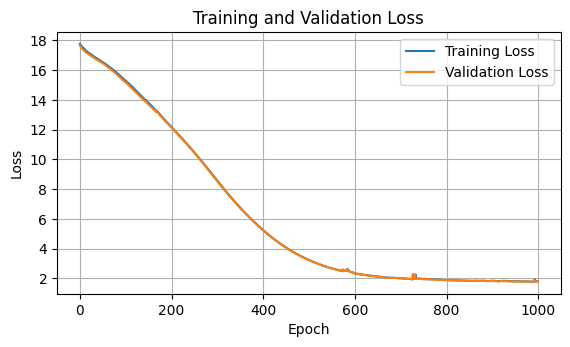

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 14.6791, Val Loss: 14.0206, best model epoch: 10
Epoch: 20, Train Loss: 8.3548, Val Loss: 7.6115, best model epoch: 20
Epoch: 30, Train Loss: 2.9287, Val Loss: 2.6059, best model epoch: 30
Epoch: 40, Train Loss: 2.3132, Val Loss: 2.4035, best model epoch: 34
Epoch: 50, Train Loss: 2.0737, Val Loss: 2.0577, best model epoch: 50
Epoch: 60, Train Loss: 2.0797, Val Loss: 2.0662, best model epoch: 50
Epoch: 70, Train Loss: 2.0715, Val Loss: 2.0727, best model epoch: 62
Epoch: 80, Train Loss: 2.0598, Val Loss: 2.0595, best model epoch: 62
Epoch: 90, Train Loss: 2.0584, Val Loss: 2.0578, best model epoch: 62
Epoch: 100, Train Loss: 2.0581, Val Loss: 2.0582, best model epoch: 62
Epoch: 110, Train Loss: 2.0578, Val Loss: 2.0574, best model epoch: 105
Epoch: 120, Train Loss: 2.0571, Val Loss: 2.0574, best model epoch: 114
Epoch: 130, Train Loss: 2.0568, Val Loss: 2.0571, best model epoch: 130
Epoch: 140, Train Loss: 2.0566, Va

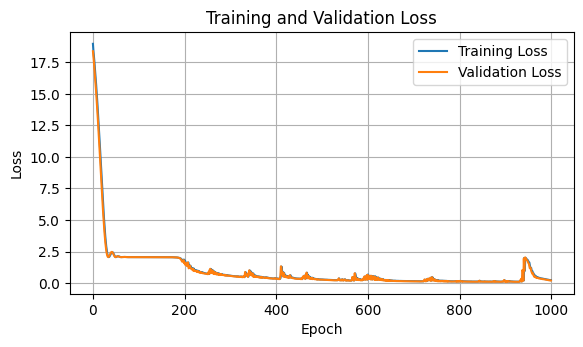

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 12.3645, Val Loss: 11.8009, best model epoch: 10
Epoch: 20, Train Loss: 6.9323, Val Loss: 6.3553, best model epoch: 20
Epoch: 30, Train Loss: 2.6350, Val Loss: 2.4199, best model epoch: 30
Epoch: 40, Train Loss: 2.2720, Val Loss: 2.3226, best model epoch: 34
Epoch: 50, Train Loss: 2.0586, Val Loss: 2.0726, best model epoch: 49
Epoch: 60, Train Loss: 2.0583, Val Loss: 2.0579, best model epoch: 60
Epoch: 70, Train Loss: 2.0632, Val Loss: 2.0615, best model epoch: 60
Epoch: 80, Train Loss: 2.0611, Val Loss: 2.0597, best model epoch: 73
Epoch: 90, Train Loss: 2.0578, Val Loss: 2.0582, best model epoch: 73
Epoch: 100, Train Loss: 2.0569, Val Loss: 2.0567, best model epoch: 100
Epoch: 110, Train Loss: 2.0560, Val Loss: 2.0556, best model epoch: 110
Epoch: 120, Train Loss: 2.0532, Val Loss: 2.0528, best model epoch: 120
Epoch: 130, Train Loss: 2.0435, Val Loss: 2.0414, best model epoch: 130
Epoch: 140, Train Loss: 1.9838, V

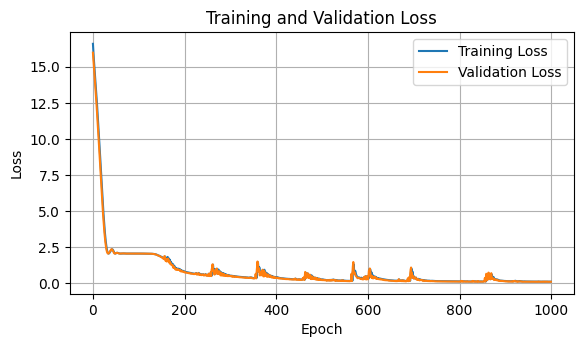

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 16.5251, Val Loss: 16.4565, best model epoch: 10
Epoch: 20, Train Loss: 16.2252, Val Loss: 16.1464, best model epoch: 20
Epoch: 30, Train Loss: 15.9386, Val Loss: 15.8571, best model epoch: 30
Epoch: 40, Train Loss: 15.6656, Val Loss: 15.5710, best model epoch: 40
Epoch: 50, Train Loss: 15.3849, Val Loss: 15.2782, best model epoch: 50
Epoch: 60, Train Loss: 15.0925, Val Loss: 14.9747, best model epoch: 60
Epoch: 70, Train Loss: 14.7830, Val Loss: 14.6486, best model epoch: 70
Epoch: 80, Train Loss: 14.4612, Val Loss: 14.3227, best model epoch: 80
Epoch: 90, Train Loss: 14.1357, Val Loss: 13.9914, best model epoch: 90
Epoch: 100, Train Loss: 13.8068, Val Loss: 13.6637, best model epoch: 100
Epoch: 110, Train Loss: 13.4830, Val Loss: 13.3370, best model epoch: 110
Epoch: 120, Train Loss: 13.1514, Val Loss: 13.0090, best model epoch: 120
Epoch: 130, Train Loss: 12.8204, Val Loss: 12.6789, best model epoch: 130
Epoch: 

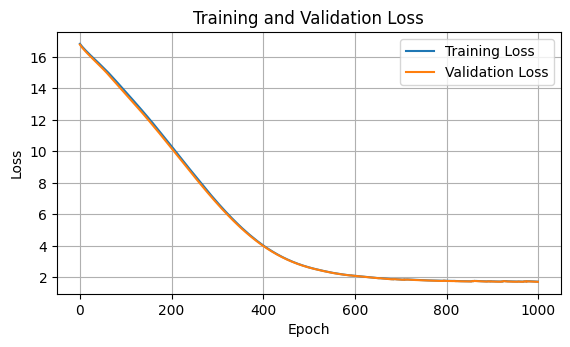

hidden_dim: 32 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 17.4717, Val Loss: 17.3991, best model epoch: 10
Epoch: 20, Train Loss: 17.1863, Val Loss: 17.1222, best model epoch: 20
Epoch: 30, Train Loss: 16.8975, Val Loss: 16.8079, best model epoch: 30
Epoch: 40, Train Loss: 16.6067, Val Loss: 16.5080, best model epoch: 40
Epoch: 50, Train Loss: 16.3051, Val Loss: 16.2135, best model epoch: 50
Epoch: 60, Train Loss: 16.0035, Val Loss: 15.9130, best model epoch: 60
Epoch: 70, Train Loss: 15.6943, Val Loss: 15.5983, best model epoch: 70
Epoch: 80, Train Loss: 15.3823, Val Loss: 15.2818, best model epoch: 80
Epoch: 90, Train Loss: 15.0621, Val Loss: 14.9571, best model epoch: 90
Epoch: 100, Train Loss: 14.7395, Val Loss: 14.6347, best model epoch: 100
Epoch: 110, Train Loss: 14.4139, Val Loss: 14.3109, best model epoch: 110
Epoch: 120, Train Loss: 14.0844, Val Loss: 13.9815, best model epoch: 120
Epoch: 130, Train Loss: 13.7506, Val Loss: 13.6478, best model epoch: 130
Epoch: 

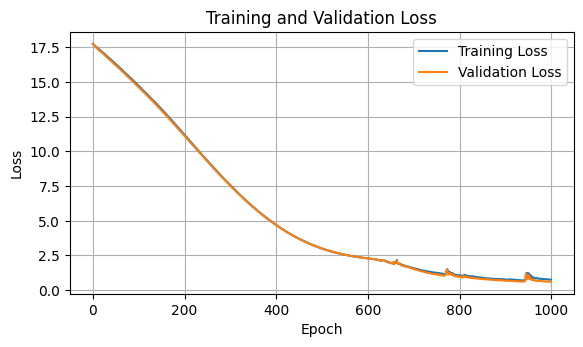

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 9.9182, Val Loss: 8.6600, best model epoch: 10
Epoch: 20, Train Loss: 2.0647, Val Loss: 2.2252, best model epoch: 19
Epoch: 30, Train Loss: 2.1050, Val Loss: 2.0567, best model epoch: 30
Epoch: 40, Train Loss: 2.0604, Val Loss: 2.0660, best model epoch: 30
Epoch: 50, Train Loss: 2.0508, Val Loss: 2.0502, best model epoch: 49
Epoch: 60, Train Loss: 2.0138, Val Loss: 2.0056, best model epoch: 60
Epoch: 70, Train Loss: 1.9602, Val Loss: 1.9464, best model epoch: 70
Epoch: 80, Train Loss: 1.9141, Val Loss: 1.9044, best model epoch: 80
Epoch: 90, Train Loss: 1.8937, Val Loss: 1.8877, best model epoch: 89
Epoch: 100, Train Loss: 1.8831, Val Loss: 1.8802, best model epoch: 98
Epoch: 110, Train Loss: 1.8780, Val Loss: 1.8721, best model epoch: 109
Epoch: 120, Train Loss: 1.8812, Val Loss: 1.8698, best model epoch: 118
Epoch: 130, Train Loss: 1.8767, Val Loss: 1.8657, best model epoch: 123
Epoch: 140, Train Loss: 1.8659, Val

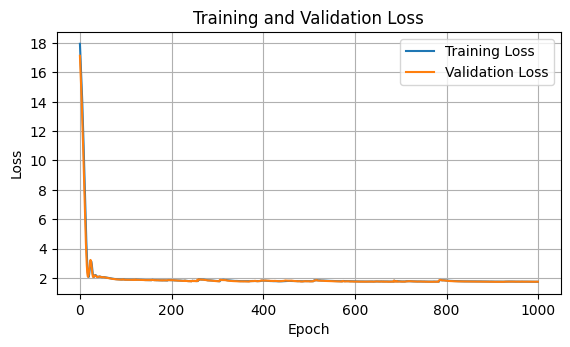

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 10.3442, Val Loss: 9.2037, best model epoch: 10
Epoch: 20, Train Loss: 2.0810, Val Loss: 2.0868, best model epoch: 19
Epoch: 30, Train Loss: 2.4830, Val Loss: 2.2612, best model epoch: 19
Epoch: 40, Train Loss: 2.1272, Val Loss: 2.0845, best model epoch: 32
Epoch: 50, Train Loss: 2.0746, Val Loss: 2.0706, best model epoch: 42
Epoch: 60, Train Loss: 2.0659, Val Loss: 2.0633, best model epoch: 42
Epoch: 70, Train Loss: 2.0598, Val Loss: 2.0608, best model epoch: 42
Epoch: 80, Train Loss: 2.0580, Val Loss: 2.0577, best model epoch: 42
Epoch: 90, Train Loss: 2.0576, Val Loss: 2.0575, best model epoch: 89
Epoch: 100, Train Loss: 2.0572, Val Loss: 2.0569, best model epoch: 100
Epoch: 110, Train Loss: 2.0565, Val Loss: 2.0561, best model epoch: 108
Epoch: 120, Train Loss: 2.0557, Val Loss: 2.0559, best model epoch: 112
Epoch: 130, Train Loss: 2.0549, Val Loss: 2.0549, best model epoch: 130
Epoch: 140, Train Loss: 2.0542, V

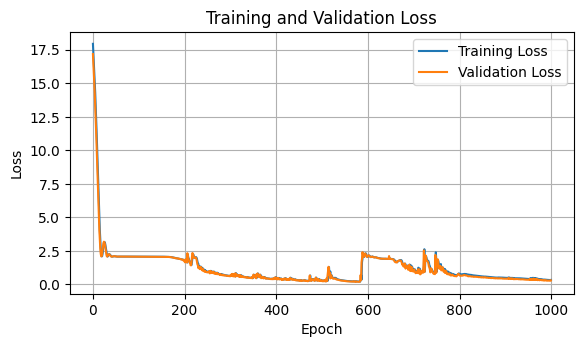

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.5274, Val Loss: 17.4273, best model epoch: 10
Epoch: 20, Train Loss: 17.0641, Val Loss: 16.9357, best model epoch: 20
Epoch: 30, Train Loss: 16.5683, Val Loss: 16.4248, best model epoch: 30
Epoch: 40, Train Loss: 16.0289, Val Loss: 15.8765, best model epoch: 40
Epoch: 50, Train Loss: 15.4327, Val Loss: 15.2650, best model epoch: 50
Epoch: 60, Train Loss: 14.7714, Val Loss: 14.6007, best model epoch: 60
Epoch: 70, Train Loss: 14.0579, Val Loss: 13.8765, best model epoch: 70
Epoch: 80, Train Loss: 13.2809, Val Loss: 13.0892, best model epoch: 80
Epoch: 90, Train Loss: 12.4493, Val Loss: 12.2521, best model epoch: 90
Epoch: 100, Train Loss: 11.5683, Val Loss: 11.3619, best model epoch: 100
Epoch: 110, Train Loss: 10.6426, Val Loss: 10.4225, best model epoch: 110
Epoch: 120, Train Loss: 9.6719, Val Loss: 9.4462, best model epoch: 120
Epoch: 130, Train Loss: 8.6885, Val Loss: 8.4651, best model epoch: 130
Epoch: 140

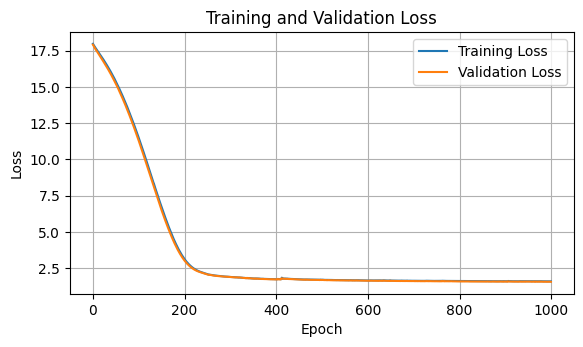

hidden_dim: 128 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.1445, Val Loss: 17.0422, best model epoch: 10
Epoch: 20, Train Loss: 16.7694, Val Loss: 16.6651, best model epoch: 20
Epoch: 30, Train Loss: 16.3646, Val Loss: 16.2534, best model epoch: 30
Epoch: 40, Train Loss: 15.9092, Val Loss: 15.7845, best model epoch: 40
Epoch: 50, Train Loss: 15.3975, Val Loss: 15.2578, best model epoch: 50
Epoch: 60, Train Loss: 14.8263, Val Loss: 14.6727, best model epoch: 60
Epoch: 70, Train Loss: 14.1944, Val Loss: 14.0183, best model epoch: 70
Epoch: 80, Train Loss: 13.4838, Val Loss: 13.2840, best model epoch: 80
Epoch: 90, Train Loss: 12.6990, Val Loss: 12.4860, best model epoch: 90
Epoch: 100, Train Loss: 11.8587, Val Loss: 11.6473, best model epoch: 100
Epoch: 110, Train Loss: 10.9809, Val Loss: 10.7803, best model epoch: 110
Epoch: 120, Train Loss: 10.0825, Val Loss: 9.8910, best model epoch: 120
Epoch: 130, Train Loss: 9.1609, Val Loss: 8.9863, best model epoch: 130
Epoch: 14

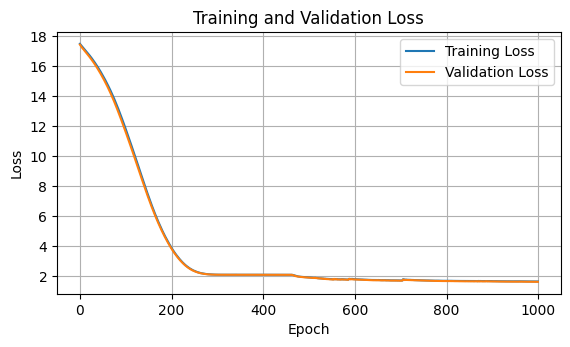

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 9.6569, Val Loss: 8.5033, best model epoch: 10
Epoch: 20, Train Loss: 2.0620, Val Loss: 2.1883, best model epoch: 19
Epoch: 30, Train Loss: 2.0598, Val Loss: 2.0835, best model epoch: 29
Epoch: 40, Train Loss: 2.0665, Val Loss: 2.0780, best model epoch: 37
Epoch: 50, Train Loss: 2.0552, Val Loss: 2.0557, best model epoch: 47
Epoch: 60, Train Loss: 2.0286, Val Loss: 2.0299, best model epoch: 60
Epoch: 70, Train Loss: 2.0078, Val Loss: 2.0074, best model epoch: 70
Epoch: 80, Train Loss: 1.9844, Val Loss: 1.9845, best model epoch: 80
Epoch: 90, Train Loss: 1.9485, Val Loss: 1.9472, best model epoch: 90
Epoch: 100, Train Loss: 1.9223, Val Loss: 1.9203, best model epoch: 100
Epoch: 110, Train Loss: 1.9019, Val Loss: 1.9028, best model epoch: 110
Epoch: 120, Train Loss: 1.8893, Val Loss: 1.8817, best model epoch: 120
Epoch: 130, Train Loss: 1.8815, Val Loss: 1.8802, best model epoch: 130
Epoch: 140, Train Loss: 1.8955, Va

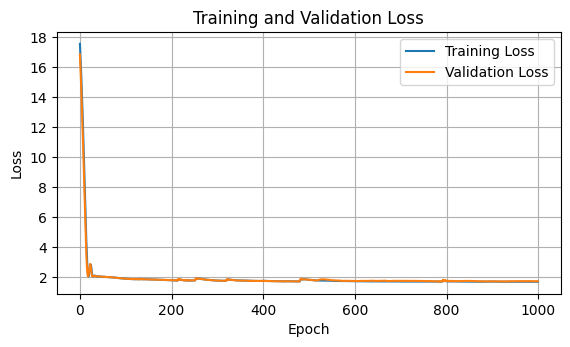

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 9.5192, Val Loss: 8.3188, best model epoch: 10
Epoch: 20, Train Loss: 2.1326, Val Loss: 2.3843, best model epoch: 18
Epoch: 30, Train Loss: 2.0692, Val Loss: 2.1172, best model epoch: 18
Epoch: 40, Train Loss: 2.0821, Val Loss: 2.0894, best model epoch: 37
Epoch: 50, Train Loss: 2.0634, Val Loss: 2.0637, best model epoch: 46
Epoch: 60, Train Loss: 2.0601, Val Loss: 2.0598, best model epoch: 55
Epoch: 70, Train Loss: 2.0588, Val Loss: 2.0586, best model epoch: 64
Epoch: 80, Train Loss: 2.0582, Val Loss: 2.0582, best model epoch: 74
Epoch: 90, Train Loss: 2.0579, Val Loss: 2.0579, best model epoch: 90
Epoch: 100, Train Loss: 2.0578, Val Loss: 2.0578, best model epoch: 100
Epoch: 110, Train Loss: 2.0576, Val Loss: 2.0575, best model epoch: 110
Epoch: 120, Train Loss: 2.0568, Val Loss: 2.0567, best model epoch: 120
Epoch: 130, Train Loss: 2.0541, Val Loss: 2.0537, best model epoch: 130
Epoch: 140, Train Loss: 2.0362, Va

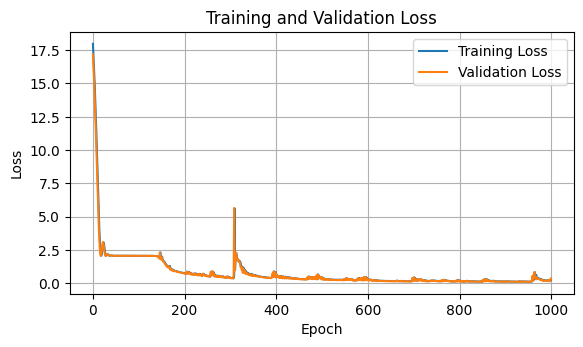

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 17.7177, Val Loss: 17.6495, best model epoch: 10
Epoch: 20, Train Loss: 17.3288, Val Loss: 17.2464, best model epoch: 20
Epoch: 30, Train Loss: 16.9215, Val Loss: 16.8249, best model epoch: 30
Epoch: 40, Train Loss: 16.4790, Val Loss: 16.3656, best model epoch: 40
Epoch: 50, Train Loss: 15.9850, Val Loss: 15.8568, best model epoch: 50
Epoch: 60, Train Loss: 15.4339, Val Loss: 15.2888, best model epoch: 60
Epoch: 70, Train Loss: 14.8124, Val Loss: 14.6391, best model epoch: 70
Epoch: 80, Train Loss: 14.0953, Val Loss: 13.8843, best model epoch: 80
Epoch: 90, Train Loss: 13.2798, Val Loss: 13.0277, best model epoch: 90
Epoch: 100, Train Loss: 12.3852, Val Loss: 12.0823, best model epoch: 100
Epoch: 110, Train Loss: 11.3776, Val Loss: 11.0294, best model epoch: 110
Epoch: 120, Train Loss: 10.3186, Val Loss: 9.9723, best model epoch: 120
Epoch: 130, Train Loss: 9.2574, Val Loss: 8.9532, best model epoch: 130
Epoch: 14

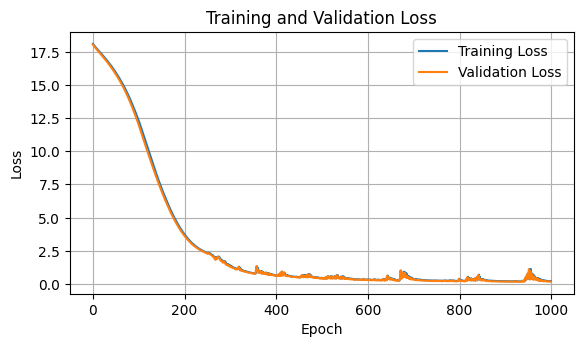

hidden_dim: 128 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 17.5517, Val Loss: 17.4681, best model epoch: 10
Epoch: 20, Train Loss: 17.0859, Val Loss: 16.9962, best model epoch: 20
Epoch: 30, Train Loss: 16.6072, Val Loss: 16.5081, best model epoch: 30
Epoch: 40, Train Loss: 16.0837, Val Loss: 15.9706, best model epoch: 40
Epoch: 50, Train Loss: 15.4992, Val Loss: 15.3708, best model epoch: 50
Epoch: 60, Train Loss: 14.8513, Val Loss: 14.7126, best model epoch: 60
Epoch: 70, Train Loss: 14.1446, Val Loss: 13.9937, best model epoch: 70
Epoch: 80, Train Loss: 13.3514, Val Loss: 13.1938, best model epoch: 80
Epoch: 90, Train Loss: 12.5082, Val Loss: 12.3554, best model epoch: 90
Epoch: 100, Train Loss: 11.6416, Val Loss: 11.4929, best model epoch: 100
Epoch: 110, Train Loss: 10.7525, Val Loss: 10.6048, best model epoch: 110
Epoch: 120, Train Loss: 9.8386, Val Loss: 9.6897, best model epoch: 120
Epoch: 130, Train Loss: 8.9105, Val Loss: 8.7571, best model epoch: 130
Epoch: 140

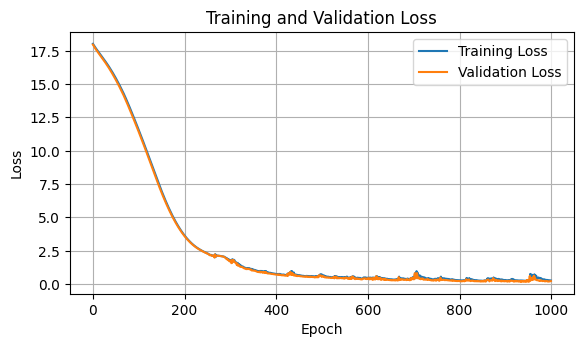

In [19]:
# GATv2 grid search
GATv2_results_part5 = []
for indx, row in GATv2_grid_params_part5.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part5.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))

pd.DataFrame(GATv2_results_part5).to_excel('GATv2_p5_results.xlsx')


hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 9.9442, Val Loss: 8.7385, best model epoch: 10
Epoch: 20, Train Loss: 2.1245, Val Loss: 2.0618, best model epoch: 20
Epoch: 30, Train Loss: 2.6910, Val Loss: 2.5089, best model epoch: 20
Epoch: 40, Train Loss: 2.2233, Val Loss: 2.2023, best model epoch: 34
Epoch: 50, Train Loss: 2.0653, Val Loss: 2.0781, best model epoch: 47
Epoch: 60, Train Loss: 2.0626, Val Loss: 2.0614, best model epoch: 47
Epoch: 70, Train Loss: 2.0617, Val Loss: 2.0582, best model epoch: 69
Epoch: 80, Train Loss: 2.0598, Val Loss: 2.0614, best model epoch: 69
Epoch: 90, Train Loss: 2.0585, Val Loss: 2.0583, best model epoch: 69
Epoch: 100, Train Loss: 2.0584, Val Loss: 2.0588, best model epoch: 69
Epoch: 110, Train Loss: 2.0585, Val Loss: 2.0587, best model epoch: 69
Epoch: 120, Train Loss: 2.0582, Val Loss: 2.0585, best model epoch: 69
Epoch: 130, Train Loss: 2.0583, Val Loss: 2.0586, best model epoch: 69
Epoch: 140, Train Loss: 2.0579, Val Los

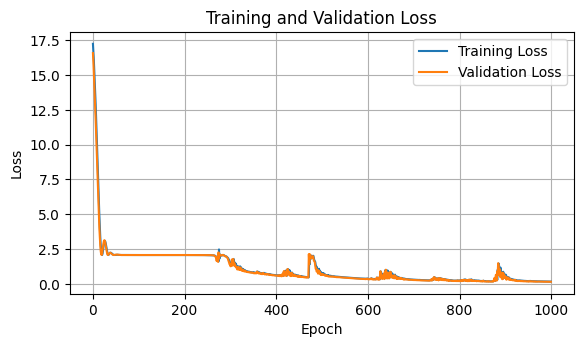

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 13.0775, Val Loss: 12.1158, best model epoch: 10
Epoch: 20, Train Loss: 4.0920, Val Loss: 3.4165, best model epoch: 20
Epoch: 30, Train Loss: 2.7031, Val Loss: 2.8302, best model epoch: 25
Epoch: 40, Train Loss: 2.1303, Val Loss: 2.1461, best model epoch: 37
Epoch: 50, Train Loss: 2.0708, Val Loss: 2.0797, best model epoch: 37
Epoch: 60, Train Loss: 2.0621, Val Loss: 2.0583, best model epoch: 55
Epoch: 70, Train Loss: 2.0578, Val Loss: 2.0567, best model epoch: 70
Epoch: 80, Train Loss: 2.0550, Val Loss: 2.0556, best model epoch: 80
Epoch: 90, Train Loss: 2.0472, Val Loss: 2.0477, best model epoch: 90
Epoch: 100, Train Loss: 1.9696, Val Loss: 1.9483, best model epoch: 100
Epoch: 110, Train Loss: 1.6071, Val Loss: 1.5391, best model epoch: 109
Epoch: 120, Train Loss: 1.2070, Val Loss: 1.2133, best model epoch: 119
Epoch: 130, Train Loss: 1.1148, Val Loss: 0.9977, best model epoch: 128
Epoch: 140, Train Loss: 0.9089, V

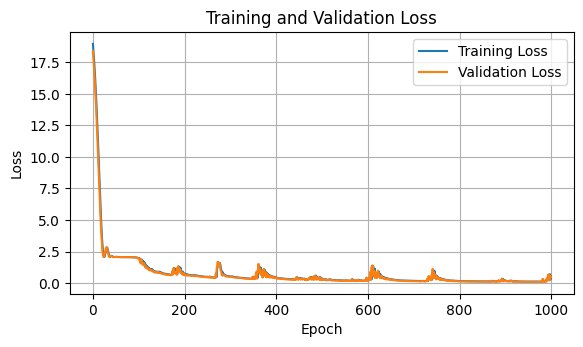

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 16.8749, Val Loss: 16.7204, best model epoch: 10
Epoch: 20, Train Loss: 16.5106, Val Loss: 16.3003, best model epoch: 20
Epoch: 30, Train Loss: 16.1448, Val Loss: 15.9050, best model epoch: 30
Epoch: 40, Train Loss: 15.7471, Val Loss: 15.4868, best model epoch: 40
Epoch: 50, Train Loss: 15.3208, Val Loss: 15.0496, best model epoch: 50
Epoch: 60, Train Loss: 14.8722, Val Loss: 14.5839, best model epoch: 60
Epoch: 70, Train Loss: 14.3916, Val Loss: 14.0969, best model epoch: 70
Epoch: 80, Train Loss: 13.8873, Val Loss: 13.5865, best model epoch: 80
Epoch: 90, Train Loss: 13.3546, Val Loss: 13.0499, best model epoch: 90
Epoch: 100, Train Loss: 12.7977, Val Loss: 12.5090, best model epoch: 100
Epoch: 110, Train Loss: 12.2424, Val Loss: 11.9495, best model epoch: 110
Epoch: 120, Train Loss: 11.6690, Val Loss: 11.3774, best model epoch: 120
Epoch: 130, Train Loss: 11.0985, Val Loss: 10.8091, best model epoch: 130
Epoch: 

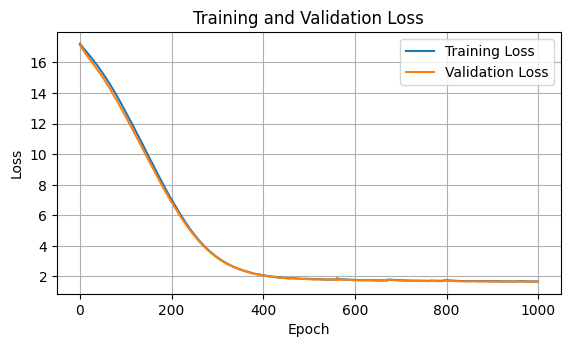

hidden_dim: 64 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 17.5746, Val Loss: 17.4702, best model epoch: 10
Epoch: 20, Train Loss: 17.1876, Val Loss: 17.0248, best model epoch: 20
Epoch: 30, Train Loss: 16.7706, Val Loss: 16.5727, best model epoch: 30
Epoch: 40, Train Loss: 16.3207, Val Loss: 16.1015, best model epoch: 40
Epoch: 50, Train Loss: 15.8473, Val Loss: 15.6257, best model epoch: 50
Epoch: 60, Train Loss: 15.3450, Val Loss: 15.1182, best model epoch: 60
Epoch: 70, Train Loss: 14.8052, Val Loss: 14.5791, best model epoch: 70
Epoch: 80, Train Loss: 14.2284, Val Loss: 14.0072, best model epoch: 80
Epoch: 90, Train Loss: 13.6153, Val Loss: 13.4048, best model epoch: 90
Epoch: 100, Train Loss: 12.9705, Val Loss: 12.7773, best model epoch: 100
Epoch: 110, Train Loss: 12.3042, Val Loss: 12.1185, best model epoch: 110
Epoch: 120, Train Loss: 11.6116, Val Loss: 11.4395, best model epoch: 120
Epoch: 130, Train Loss: 10.9041, Val Loss: 10.7465, best model epoch: 130
Epoch: 

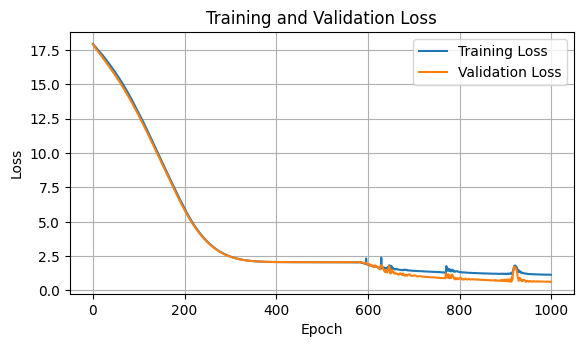

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 14.8045, Val Loss: 14.1505, best model epoch: 10
Epoch: 20, Train Loss: 7.5720, Val Loss: 6.7719, best model epoch: 20
Epoch: 30, Train Loss: 2.1912, Val Loss: 2.0795, best model epoch: 30
Epoch: 40, Train Loss: 2.5987, Val Loss: 2.5130, best model epoch: 31
Epoch: 50, Train Loss: 2.1790, Val Loss: 2.1739, best model epoch: 45
Epoch: 60, Train Loss: 2.0712, Val Loss: 2.0763, best model epoch: 56
Epoch: 70, Train Loss: 2.0586, Val Loss: 2.0581, best model epoch: 70
Epoch: 80, Train Loss: 2.0609, Val Loss: 2.0594, best model epoch: 70
Epoch: 90, Train Loss: 2.0595, Val Loss: 2.0593, best model epoch: 83
Epoch: 100, Train Loss: 2.0582, Val Loss: 2.0578, best model epoch: 98
Epoch: 110, Train Loss: 2.0576, Val Loss: 2.0575, best model epoch: 110
Epoch: 120, Train Loss: 2.0573, Val Loss: 2.0570, best model epoch: 120
Epoch: 130, Train Loss: 2.0564, Val Loss: 2.0562, best model epoch: 130
Epoch: 140, Train Loss: 2.0550, Va

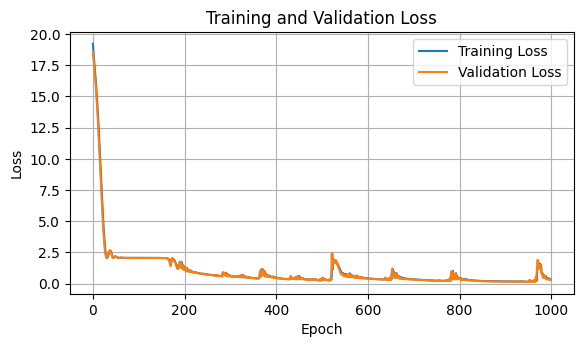

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 10.1280, Val Loss: 9.1039, best model epoch: 10
Epoch: 20, Train Loss: 2.2827, Val Loss: 2.0920, best model epoch: 20
Epoch: 30, Train Loss: 2.5310, Val Loss: 2.3268, best model epoch: 21
Epoch: 40, Train Loss: 2.1388, Val Loss: 2.1048, best model epoch: 33
Epoch: 50, Train Loss: 2.0895, Val Loss: 2.0859, best model epoch: 43
Epoch: 60, Train Loss: 2.0665, Val Loss: 2.0670, best model epoch: 43
Epoch: 70, Train Loss: 2.0594, Val Loss: 2.0604, best model epoch: 43
Epoch: 80, Train Loss: 2.0582, Val Loss: 2.0583, best model epoch: 43
Epoch: 90, Train Loss: 2.0581, Val Loss: 2.0580, best model epoch: 89
Epoch: 100, Train Loss: 2.0579, Val Loss: 2.0579, best model epoch: 100
Epoch: 110, Train Loss: 2.0577, Val Loss: 2.0576, best model epoch: 110
Epoch: 120, Train Loss: 2.0575, Val Loss: 2.0574, best model epoch: 120
Epoch: 130, Train Loss: 2.0572, Val Loss: 2.0570, best model epoch: 130
Epoch: 140, Train Loss: 2.0581, Va

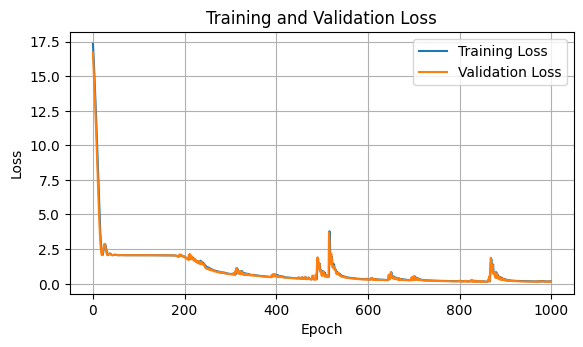

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 18.7265, Val Loss: 18.6412, best model epoch: 10
Epoch: 20, Train Loss: 18.3156, Val Loss: 18.2216, best model epoch: 20
Epoch: 30, Train Loss: 17.9197, Val Loss: 17.8144, best model epoch: 30
Epoch: 40, Train Loss: 17.5242, Val Loss: 17.4089, best model epoch: 40
Epoch: 50, Train Loss: 17.1128, Val Loss: 16.9867, best model epoch: 50
Epoch: 60, Train Loss: 16.6723, Val Loss: 16.5352, best model epoch: 60
Epoch: 70, Train Loss: 16.2054, Val Loss: 16.0600, best model epoch: 70
Epoch: 80, Train Loss: 15.7153, Val Loss: 15.5659, best model epoch: 80
Epoch: 90, Train Loss: 15.1966, Val Loss: 15.0341, best model epoch: 90
Epoch: 100, Train Loss: 14.6255, Val Loss: 14.4552, best model epoch: 100
Epoch: 110, Train Loss: 14.0100, Val Loss: 13.8348, best model epoch: 110
Epoch: 120, Train Loss: 13.3712, Val Loss: 13.1853, best model epoch: 120
Epoch: 130, Train Loss: 12.7092, Val Loss: 12.5170, best model epoch: 130
Epoch: 

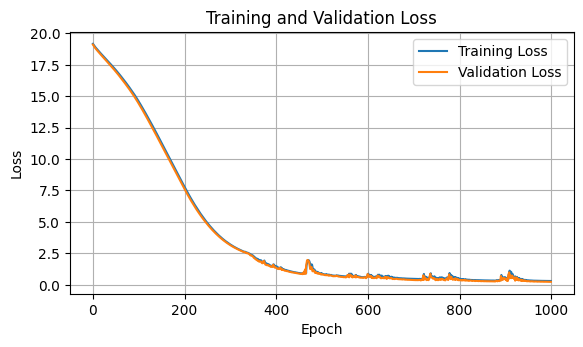

hidden_dim: 64 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 18.0211, Val Loss: 17.9659, best model epoch: 10
Epoch: 20, Train Loss: 17.6242, Val Loss: 17.5506, best model epoch: 20
Epoch: 30, Train Loss: 17.2120, Val Loss: 17.1295, best model epoch: 30
Epoch: 40, Train Loss: 16.7559, Val Loss: 16.6520, best model epoch: 40
Epoch: 50, Train Loss: 16.2339, Val Loss: 16.1104, best model epoch: 50
Epoch: 60, Train Loss: 15.6674, Val Loss: 15.5339, best model epoch: 60
Epoch: 70, Train Loss: 15.0798, Val Loss: 14.9408, best model epoch: 70
Epoch: 80, Train Loss: 14.4627, Val Loss: 14.3230, best model epoch: 80
Epoch: 90, Train Loss: 13.8169, Val Loss: 13.6752, best model epoch: 90
Epoch: 100, Train Loss: 13.1479, Val Loss: 13.0069, best model epoch: 100
Epoch: 110, Train Loss: 12.4626, Val Loss: 12.3225, best model epoch: 110
Epoch: 120, Train Loss: 11.7632, Val Loss: 11.6275, best model epoch: 120
Epoch: 130, Train Loss: 11.0426, Val Loss: 10.9102, best model epoch: 130
Epoch: 

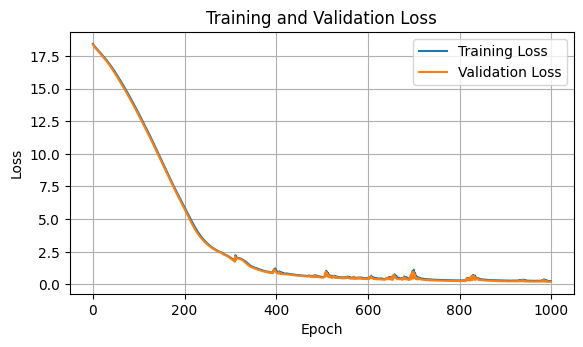

In [18]:
# GATv2 grid search
GATv2_results_part6 = []
for indx, row in GATv2_grid_params_part6.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part6.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))
pd.DataFrame(GATv2_results_part6).to_excel('GATv2_p6_results.xlsx')


hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 14.5155, Val Loss: 14.0323, best model epoch: 10
Epoch: 20, Train Loss: 10.1818, Val Loss: 9.5101, best model epoch: 20
Epoch: 30, Train Loss: 5.0118, Val Loss: 4.4365, best model epoch: 30
Epoch: 40, Train Loss: 2.0992, Val Loss: 2.0594, best model epoch: 40
Epoch: 50, Train Loss: 2.0571, Val Loss: 2.0197, best model epoch: 49
Epoch: 60, Train Loss: 1.9900, Val Loss: 1.9651, best model epoch: 60
Epoch: 70, Train Loss: 1.9439, Val Loss: 1.9251, best model epoch: 70
Epoch: 80, Train Loss: 1.9097, Val Loss: 1.9028, best model epoch: 79
Epoch: 90, Train Loss: 1.8917, Val Loss: 1.8834, best model epoch: 89
Epoch: 100, Train Loss: 1.8815, Val Loss: 1.8759, best model epoch: 98
Epoch: 110, Train Loss: 1.8731, Val Loss: 1.8626, best model epoch: 110
Epoch: 120, Train Loss: 1.8628, Val Loss: 1.8545, best model epoch: 119
Epoch: 130, Train Loss: 1.8555, Val Loss: 1.8466, best model epoch: 130
Epoch: 140, Train Loss: 1.9251, V

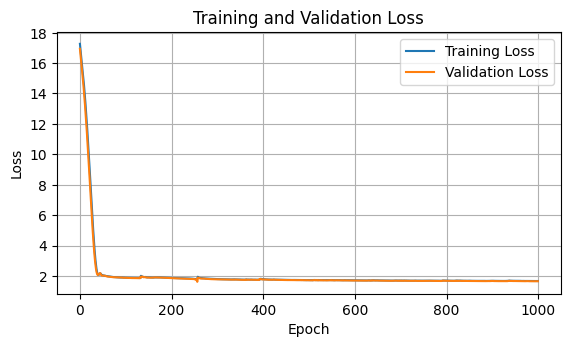

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.01
Epoch: 10, Train Loss: 15.2826, Val Loss: 14.9330, best model epoch: 10
Epoch: 20, Train Loss: 11.8469, Val Loss: 11.3465, best model epoch: 20
Epoch: 30, Train Loss: 7.6793, Val Loss: 7.1966, best model epoch: 30
Epoch: 40, Train Loss: 3.9609, Val Loss: 3.6629, best model epoch: 40
Epoch: 50, Train Loss: 2.1684, Val Loss: 2.1120, best model epoch: 50
Epoch: 60, Train Loss: 2.1611, Val Loss: 2.1864, best model epoch: 53
Epoch: 70, Train Loss: 2.0882, Val Loss: 2.0791, best model epoch: 53
Epoch: 80, Train Loss: 2.0738, Val Loss: 2.0702, best model epoch: 53
Epoch: 90, Train Loss: 2.0617, Val Loss: 2.0591, best model epoch: 85
Epoch: 100, Train Loss: 2.0582, Val Loss: 2.0575, best model epoch: 98
Epoch: 110, Train Loss: 2.0588, Val Loss: 2.0582, best model epoch: 98
Epoch: 120, Train Loss: 2.0583, Val Loss: 2.0572, best model epoch: 120
Epoch: 130, Train Loss: 2.0584, Val Loss: 2.0572, best model epoch: 125
Epoch: 140, Train Loss: 2.0582, V

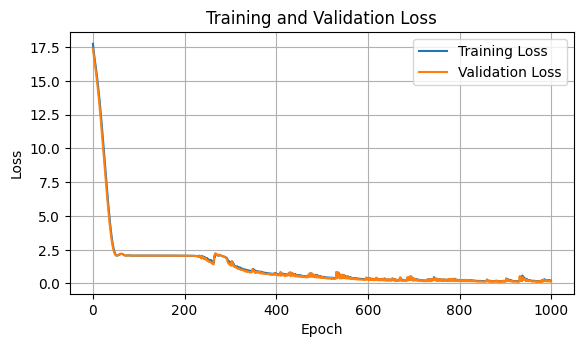

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 16.4272, Val Loss: 16.3546, best model epoch: 10
Epoch: 20, Train Loss: 16.1818, Val Loss: 16.0744, best model epoch: 20
Epoch: 30, Train Loss: 15.9366, Val Loss: 15.8160, best model epoch: 30
Epoch: 40, Train Loss: 15.6987, Val Loss: 15.5540, best model epoch: 40
Epoch: 50, Train Loss: 15.4766, Val Loss: 15.3148, best model epoch: 50
Epoch: 60, Train Loss: 15.2488, Val Loss: 15.0781, best model epoch: 60
Epoch: 70, Train Loss: 15.0158, Val Loss: 14.8361, best model epoch: 70
Epoch: 80, Train Loss: 14.7784, Val Loss: 14.5827, best model epoch: 80
Epoch: 90, Train Loss: 14.5253, Val Loss: 14.3241, best model epoch: 90
Epoch: 100, Train Loss: 14.2695, Val Loss: 14.0538, best model epoch: 100
Epoch: 110, Train Loss: 14.0054, Val Loss: 13.7784, best model epoch: 110
Epoch: 120, Train Loss: 13.7382, Val Loss: 13.4932, best model epoch: 120
Epoch: 130, Train Loss: 13.4537, Val Loss: 13.1997, best model epoch: 130
Epoch: 

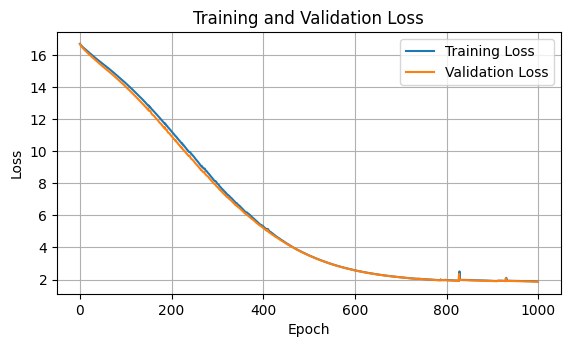

hidden_dim: 16 | dropout_prob: 0.5  | lr: 0.0005
Epoch: 10, Train Loss: 19.3548, Val Loss: 19.0300, best model epoch: 10
Epoch: 20, Train Loss: 19.1059, Val Loss: 18.7370, best model epoch: 20
Epoch: 30, Train Loss: 18.7951, Val Loss: 18.4534, best model epoch: 30
Epoch: 40, Train Loss: 18.4994, Val Loss: 18.2320, best model epoch: 40
Epoch: 50, Train Loss: 18.2383, Val Loss: 17.9353, best model epoch: 50
Epoch: 60, Train Loss: 17.9628, Val Loss: 17.6276, best model epoch: 60
Epoch: 70, Train Loss: 17.6782, Val Loss: 17.3158, best model epoch: 70
Epoch: 80, Train Loss: 17.3721, Val Loss: 17.0218, best model epoch: 80
Epoch: 90, Train Loss: 17.0553, Val Loss: 16.6981, best model epoch: 90
Epoch: 100, Train Loss: 16.7267, Val Loss: 16.3275, best model epoch: 100
Epoch: 110, Train Loss: 16.3583, Val Loss: 16.0083, best model epoch: 110
Epoch: 120, Train Loss: 15.9544, Val Loss: 15.5997, best model epoch: 120
Epoch: 130, Train Loss: 15.5497, Val Loss: 15.2194, best model epoch: 130
Epoch: 

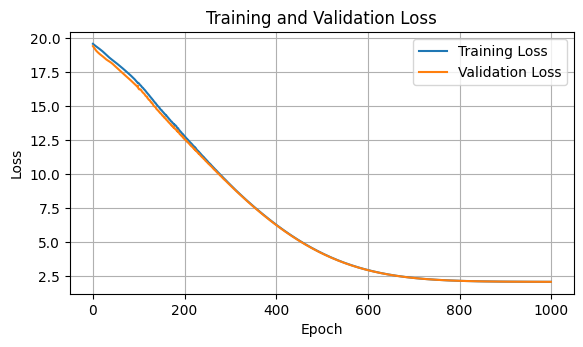

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 13.3061, Val Loss: 12.8549, best model epoch: 10
Epoch: 20, Train Loss: 8.7732, Val Loss: 8.1739, best model epoch: 20
Epoch: 30, Train Loss: 4.1638, Val Loss: 3.7462, best model epoch: 30
Epoch: 40, Train Loss: 2.0822, Val Loss: 2.0586, best model epoch: 40
Epoch: 50, Train Loss: 2.3015, Val Loss: 2.3178, best model epoch: 40
Epoch: 60, Train Loss: 2.0598, Val Loss: 2.0537, best model epoch: 60
Epoch: 70, Train Loss: 2.0688, Val Loss: 2.0543, best model epoch: 60
Epoch: 80, Train Loss: 2.0501, Val Loss: 2.0503, best model epoch: 73
Epoch: 90, Train Loss: 2.0240, Val Loss: 2.0171, best model epoch: 90
Epoch: 100, Train Loss: 1.9771, Val Loss: 1.9648, best model epoch: 100
Epoch: 110, Train Loss: 1.9422, Val Loss: 1.9328, best model epoch: 110
Epoch: 120, Train Loss: 1.9141, Val Loss: 1.9080, best model epoch: 120
Epoch: 130, Train Loss: 1.8961, Val Loss: 1.8929, best model epoch: 130
Epoch: 140, Train Loss: 1.8773, V

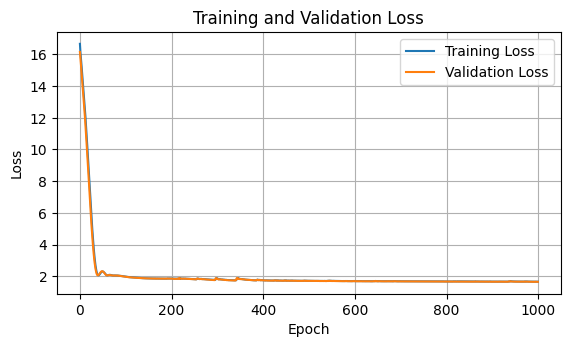

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.01
Epoch: 10, Train Loss: 15.0813, Val Loss: 14.8937, best model epoch: 10
Epoch: 20, Train Loss: 13.0722, Val Loss: 12.7982, best model epoch: 20
Epoch: 30, Train Loss: 10.1816, Val Loss: 9.8288, best model epoch: 30
Epoch: 40, Train Loss: 6.5006, Val Loss: 6.0991, best model epoch: 40
Epoch: 50, Train Loss: 3.2513, Val Loss: 3.0104, best model epoch: 50
Epoch: 60, Train Loss: 2.0606, Val Loss: 2.0596, best model epoch: 60
Epoch: 70, Train Loss: 2.1686, Val Loss: 2.1479, best model epoch: 60
Epoch: 80, Train Loss: 2.0336, Val Loss: 2.0237, best model epoch: 80
Epoch: 90, Train Loss: 1.9761, Val Loss: 1.9653, best model epoch: 90
Epoch: 100, Train Loss: 1.9358, Val Loss: 1.9285, best model epoch: 100
Epoch: 110, Train Loss: 1.9088, Val Loss: 1.9078, best model epoch: 110
Epoch: 120, Train Loss: 1.8935, Val Loss: 1.8920, best model epoch: 118
Epoch: 130, Train Loss: 1.8812, Val Loss: 1.8740, best model epoch: 130
Epoch: 140, Train Loss: 1.8718

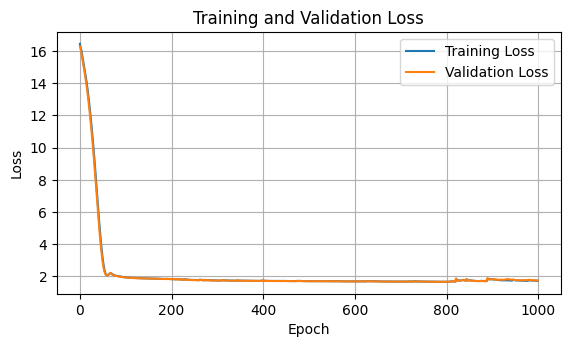

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 18.7600, Val Loss: 18.7243, best model epoch: 10
Epoch: 20, Train Loss: 18.6238, Val Loss: 18.5718, best model epoch: 20
Epoch: 30, Train Loss: 18.3931, Val Loss: 18.3437, best model epoch: 30
Epoch: 40, Train Loss: 18.1957, Val Loss: 18.1325, best model epoch: 40
Epoch: 50, Train Loss: 17.9565, Val Loss: 17.8786, best model epoch: 50
Epoch: 60, Train Loss: 17.7341, Val Loss: 17.6353, best model epoch: 60
Epoch: 70, Train Loss: 17.5012, Val Loss: 17.3924, best model epoch: 70
Epoch: 80, Train Loss: 17.2617, Val Loss: 17.1530, best model epoch: 80
Epoch: 90, Train Loss: 17.0139, Val Loss: 16.9029, best model epoch: 90
Epoch: 100, Train Loss: 16.7575, Val Loss: 16.6468, best model epoch: 100
Epoch: 110, Train Loss: 16.5310, Val Loss: 16.4282, best model epoch: 110
Epoch: 120, Train Loss: 16.3230, Val Loss: 16.2195, best model epoch: 120
Epoch: 130, Train Loss: 16.1166, Val Loss: 16.0103, best model epoch: 130
Epoch: 

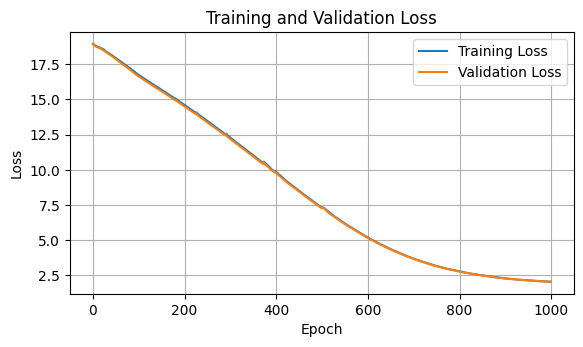

hidden_dim: 16 | dropout_prob: 0.2  | lr: 0.0005
Epoch: 10, Train Loss: 18.2864, Val Loss: 18.1604, best model epoch: 10
Epoch: 20, Train Loss: 17.9175, Val Loss: 17.7392, best model epoch: 20
Epoch: 30, Train Loss: 17.5890, Val Loss: 17.4096, best model epoch: 30
Epoch: 40, Train Loss: 17.2519, Val Loss: 17.0824, best model epoch: 40
Epoch: 50, Train Loss: 16.9065, Val Loss: 16.7579, best model epoch: 50
Epoch: 60, Train Loss: 16.5740, Val Loss: 16.4416, best model epoch: 60
Epoch: 70, Train Loss: 16.2405, Val Loss: 16.1125, best model epoch: 70
Epoch: 80, Train Loss: 15.9011, Val Loss: 15.7696, best model epoch: 80
Epoch: 90, Train Loss: 15.5468, Val Loss: 15.4195, best model epoch: 90
Epoch: 100, Train Loss: 15.1888, Val Loss: 15.0594, best model epoch: 100
Epoch: 110, Train Loss: 14.8241, Val Loss: 14.6894, best model epoch: 110
Epoch: 120, Train Loss: 14.4533, Val Loss: 14.3142, best model epoch: 120
Epoch: 130, Train Loss: 14.0771, Val Loss: 13.9374, best model epoch: 130
Epoch: 

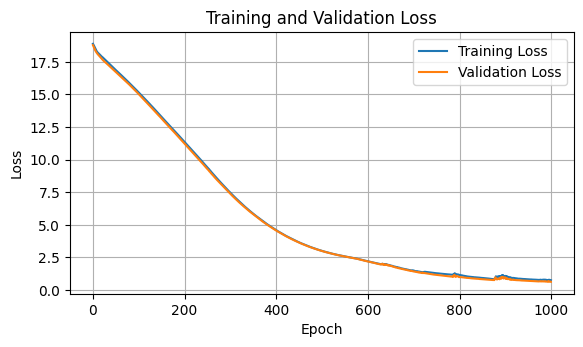

In [18]:
# GATv2 grid search
GATv2_results_part7 = []
for indx, row in GATv2_grid_params_part7.iterrows():
  hidden_dim = int(row['hidden_dim'])
  dropout_prob = float(row['dropout_prob'])
  lr = float(row['lr'])
  heads = int(row['heads'])
  num_epochs=1000
  print('hidden_dim:', hidden_dim, '| dropout_prob:', dropout_prob, ' | lr:', lr)
  GATv2_results_part7.append(run_GATv2_model(hidden_dim=hidden_dim, dropout_prob=dropout_prob, lr=lr, num_epochs = num_epochs, heads=heads))
pd.DataFrame(GATv2_results_part7).to_excel('GATv2_p7_results.xlsx')

## Analysis of params

In [76]:
GAT_results_1 = pd.read_excel('GAT_results.xlsx')
GAT_results_2 = pd.read_excel('GAT_p2_results.xlsx')
GAT_results_3 = pd.read_excel('GAT_p3_results.xlsx')
GAT_results = pd.concat([GAT_results_1, GAT_results_2, GAT_results_3])

GATv2_results_1 = pd.read_excel('GATv2_p1_results.xlsx')
GATv2_results_2 = pd.read_excel('GATv2_p2_results.xlsx')
# part 3 failed as hidden dim >= 256 runs out of memory
GATv2_results_4 = pd.read_excel('GATv2_p4_results.xlsx')
GATv2_results_5 = pd.read_excel('GATv2_p5_results.xlsx')
GATv2_results_6 = pd.read_excel('GATv2_p6_results.xlsx')
GATv2_results_7 = pd.read_excel('GATv2_p7_results.xlsx')
GATv2_results = pd.concat([GATv2_results_1, GATv2_results_2, GATv2_results_4,GATv2_results_5,GATv2_results_6,GATv2_results_7])

results = pd.concat([GAT_results, GATv2_results])

In [79]:
GATv2_results.to_excel('all_GATv2_results.xlsx',index = False)
GAT_results.to_excel('all_GAT_results.xlsx',index = False)

In [128]:
import pandas as pd

GAT_results = pd.read_excel('all_GAT_results.xlsx')
GATv2_results = pd.read_excel('all_GATv2_results.xlsx')

# remove unnamed col
GAT_results = GAT_results.loc[:, ~GAT_results.columns.str.contains('^Unnamed')]
GATv2_results = GATv2_results.loc[:, ~GATv2_results.columns.str.contains('^Unnamed')]

In [123]:
print('best test loss in original GAT:', min(GAT_results['best test loss']))
print('best test loss in GATv2:',min(GATv2_results['best test loss']))
# GATv2 achieved a lower RMSE score

best test loss in original GAT: 0.09515344351530075
best test loss in GATv2: 0.0975070670247078


In [124]:
print('Best params for GAT:')
best_param = GAT_results[GAT_results['best test loss'] == min(GAT_results['best test loss'])].reset_index(drop=True)
best_param_dict = best_param.to_dict(orient='records')[0]
best_param

Best params for GAT:


hidden_dim  dropout_prob    lr  best test loss  best test loss epoch  \
0          64           0.1  0.01        0.095153                  1999   

   corr_train_loss  
0         0.099447

### GAT

    hidden_dim  dropout_prob    lr  best test loss  best test loss epoch  \
60          16           0.1  0.01        0.102098                  1975   
63          32           0.1  0.01        1.573236                  1999   
67          64           0.1  0.01        0.095153                  1999   
71         128           0.1  0.01        1.519706                  1999   
74         256           0.1  0.01        0.412460                  1343   

    corr_train_loss  
60         0.114140  
63         1.583292  
67         0.099447  
71         1.532068  
74         0.416334  


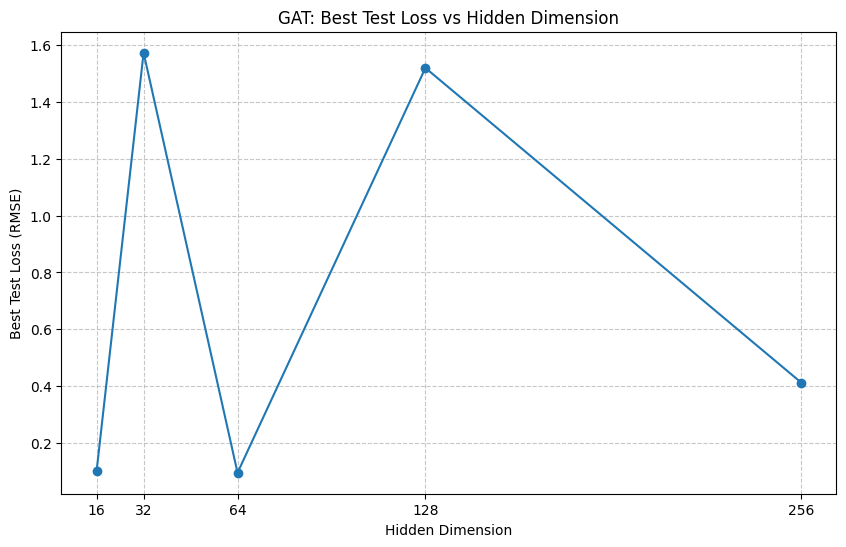

In [129]:
import matplotlib.pyplot as plt

gat_filtered_data = GAT_results[
    (GAT_results['dropout_prob'] == best_param_dict['dropout_prob']) &
    (GAT_results['lr'] == best_param_dict['lr'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('hidden_dim', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['hidden_dim'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title(f'GAT: Best Test Loss vs Hidden Dimension')
plt.xlabel('Hidden Dimension')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['hidden_dim'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

    hidden_dim  dropout_prob    lr  best test loss  best test loss epoch  \
67          64           0.1  0.01        0.095153                  1999   
68          64           0.2  0.01        0.098184                  2000   
69          64           0.3  0.01        0.099806                  1957   
70          64           0.5  0.01        0.101829                  1807   

    corr_train_loss  
67         0.099447  
68         0.104180  
69         0.110370  
70         0.115784  


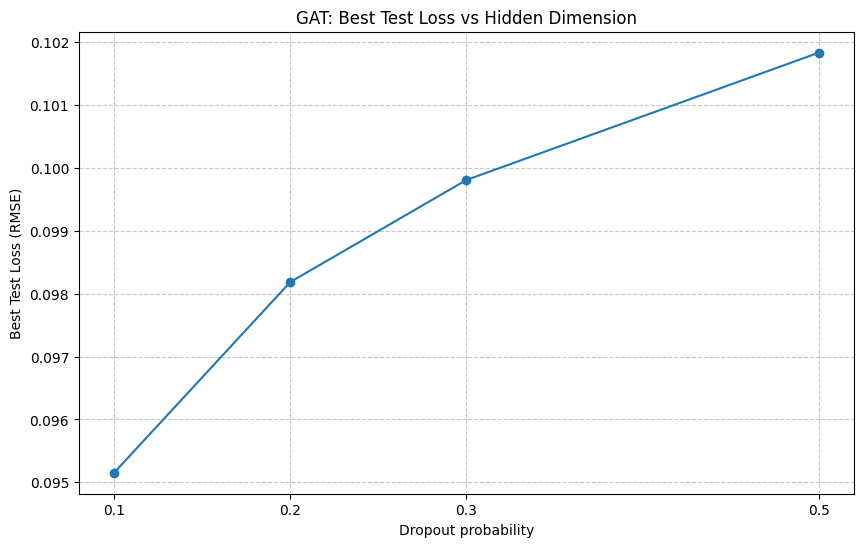

In [130]:
import matplotlib.pyplot as plt

gat_filtered_data = GAT_results[
    (GAT_results['hidden_dim'] == best_param_dict['hidden_dim']) &
    (GAT_results['lr'] == best_param_dict['lr'])
].copy()
print(gat_filtered_data)

gat_filtered_data.sort_values('dropout_prob', inplace=True)

# plot
plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['dropout_prob'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GAT: Best Test Loss vs Hidden Dimension')
plt.xlabel('Dropout probability')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['dropout_prob'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

    hidden_dim  dropout_prob      lr  best test loss  best test loss epoch  \
19          64           0.1  0.0005        1.626772                  1983   
20          64           0.1  0.0001        6.268209                  2000   
24          64           0.1  0.0010        0.165190                  2000   
67          64           0.1  0.0100        0.095153                  1999   

    corr_train_loss  
19         1.634022  
20         6.329899  
24         0.181993  
67         0.099447  


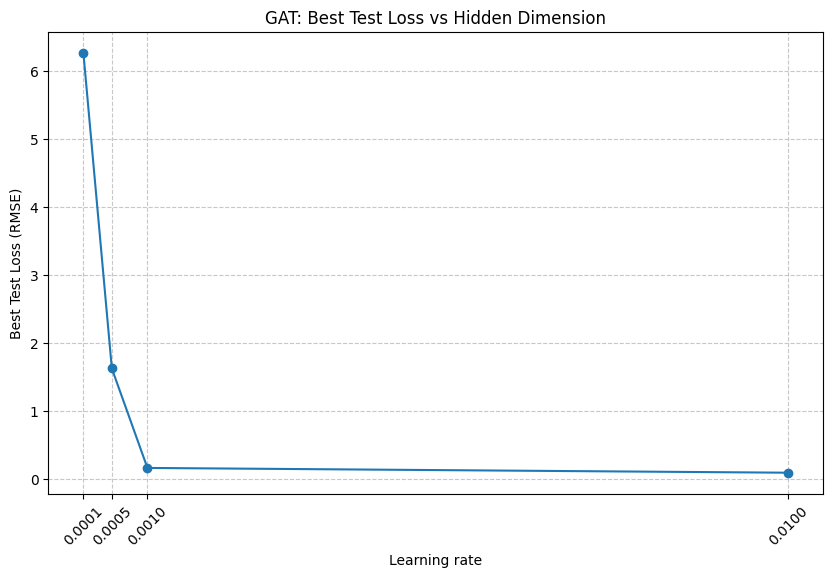

In [131]:
import matplotlib.pyplot as plt

gat_filtered_data = GAT_results[
    (GAT_results['hidden_dim'] == best_param_dict['hidden_dim']) &
    (GAT_results['dropout_prob'] == best_param_dict['dropout_prob'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('lr', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['lr'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GAT: Best Test Loss vs Hidden Dimension')
plt.xlabel('Learning rate')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['lr'].unique(), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

GATv2

In [132]:
GATv2_results[GATv2_results['best test loss'] == min(GATv2_results['best test loss'])]
print('Best params for GATv2:')
best_param_GATv2 = GATv2_results[GATv2_results['best test loss'] == min(GATv2_results['best test loss'])].reset_index(drop=True)
best_param_GATv2_dict = best_param_GATv2.to_dict(orient='records')[0]
best_param_GATv2

Best params for GATv2:


hidden_dim  dropout_prob     lr  heads  best test loss  \
0         128           0.1  0.001      2        0.097507   

   best test loss epoch  corr_train_loss  
0                  1995          0.10605

    hidden_dim  dropout_prob     lr  heads  best test loss  \
1           32           0.1  0.001      2        0.105962   
9           64           0.1  0.001      2        0.148713   
15         128           0.1  0.001      2        0.097507   
27          16           0.1  0.001      2        0.183417   

    best test loss epoch  corr_train_loss  
1                   2000         0.122150  
9                   1998         0.189197  
15                  1995         0.106050  
27                  1996         0.214316  


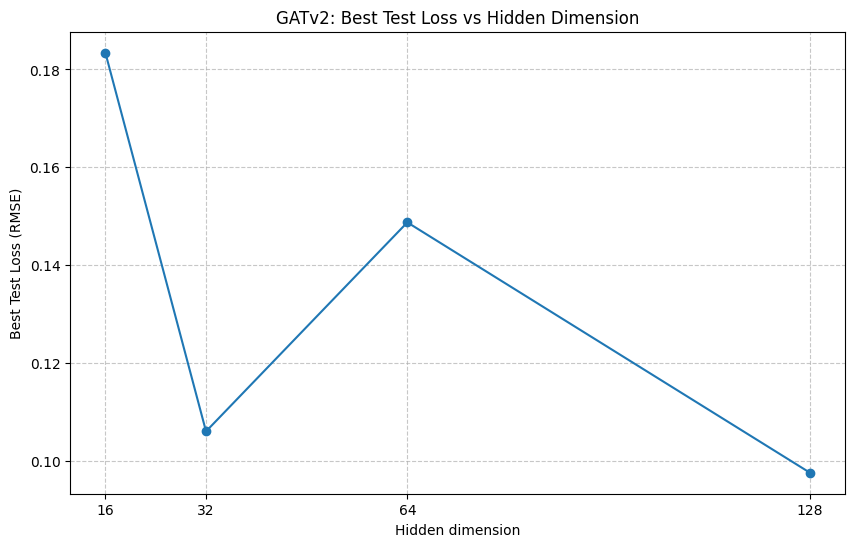

In [133]:
import matplotlib.pyplot as plt

gat_filtered_data = GATv2_results[
    (GATv2_results['dropout_prob'] == best_param_GATv2_dict['dropout_prob']) &
    (GATv2_results['lr'] == best_param_GATv2_dict['lr']) &
    (GATv2_results['heads'] == best_param_GATv2_dict['heads'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('hidden_dim', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['hidden_dim'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GATv2: Best Test Loss vs Hidden Dimension')
plt.xlabel('Hidden dimension')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['hidden_dim'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

    hidden_dim  dropout_prob      lr  heads  best test loss  \
13         128           0.1  0.0001      2        3.898951   
14         128           0.1  0.0005      2        2.757461   
15         128           0.1  0.0010      2        0.097507   
17         128           0.1  0.0100      2        0.133594   

    best test loss epoch  corr_train_loss  
13                  2000         3.907683  
14                  2000              NaN  
15                  1995         0.106050  
17                  2000         0.144394  


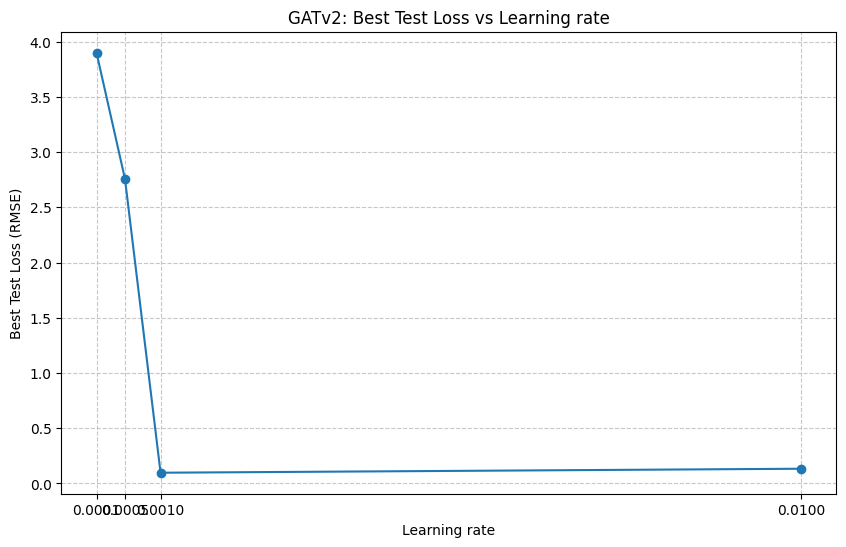

In [134]:
import matplotlib.pyplot as plt

gat_filtered_data = GATv2_results[
    (GATv2_results['hidden_dim'] == best_param_GATv2_dict['hidden_dim']) &
    (GATv2_results['dropout_prob'] == best_param_GATv2_dict['dropout_prob']) &
    (GATv2_results['heads'] == best_param_GATv2_dict['heads'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('lr', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['lr'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GATv2: Best Test Loss vs Learning rate')
plt.xlabel('Learning rate')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['lr'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

    hidden_dim  dropout_prob     lr  heads  best test loss  \
15         128           0.1  0.001      2        0.097507   
47         128           0.2  0.001      2        1.218847   
48         128           0.3  0.001      2        1.509817   
49         128           0.5  0.001      2        1.813854   

    best test loss epoch  corr_train_loss  
15                  1995         0.106050  
47                  1993         1.362887  
48                  1999         1.532267  
49                  1998         1.992158  


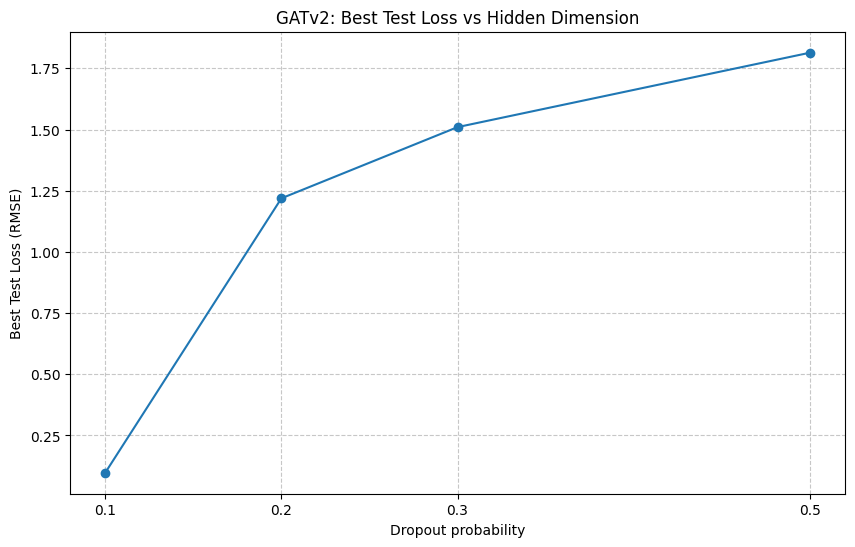

In [135]:
import matplotlib.pyplot as plt

gat_filtered_data = GATv2_results[
    (GATv2_results['hidden_dim'] == best_param_GATv2_dict['hidden_dim']) &
    (GATv2_results['heads'] == best_param_GATv2_dict['heads']) &
    (GATv2_results['lr'] == best_param_GATv2_dict['lr'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('dropout_prob', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['dropout_prob'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GATv2: Best Test Loss vs Hidden Dimension')
plt.xlabel('Dropout probability')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['dropout_prob'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

    hidden_dim  dropout_prob     lr  heads  best test loss  \
8          128           0.1  0.001      1        1.518719   
15         128           0.1  0.001      2        0.097507   

    best test loss epoch  corr_train_loss  
8                   1991         1.534519  
15                  1995         0.106050  


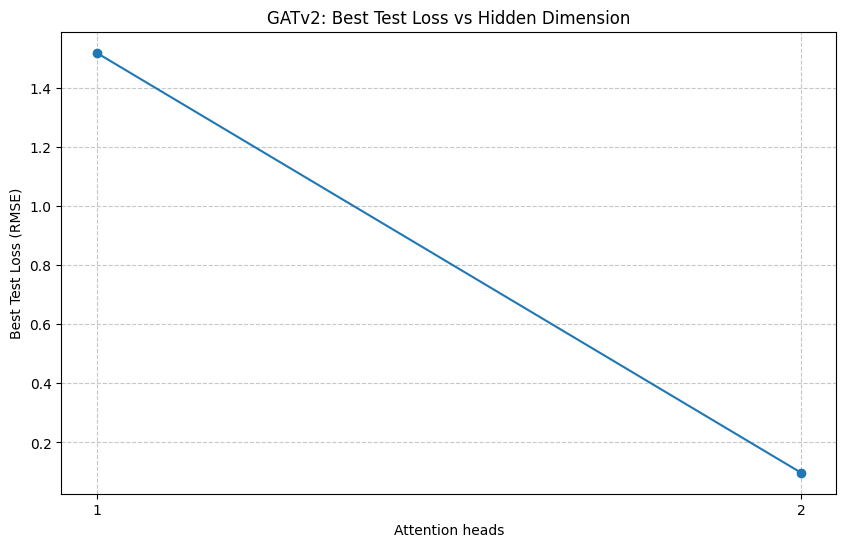

In [136]:
import matplotlib.pyplot as plt

gat_filtered_data = GATv2_results[
    (GATv2_results['hidden_dim'] == best_param_GATv2_dict['hidden_dim']) &
    (GATv2_results['dropout_prob'] == best_param_GATv2_dict['dropout_prob']) &
    (GATv2_results['lr'] == best_param_GATv2_dict['lr'])
].copy()
print(gat_filtered_data)
gat_filtered_data.sort_values('heads', inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(gat_filtered_data['heads'], gat_filtered_data['best test loss'], marker='o', linestyle='-')
plt.title('GATv2: Best Test Loss vs Hidden Dimension')
plt.xlabel('Attention heads')
plt.ylabel('Best Test Loss (RMSE)')
plt.xticks(gat_filtered_data['heads'].unique())
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Final model performance

This is simply to load the best model during training and to print that loss  
Has no other purpose

In [156]:
model = GAT_model(num_users, num_products, user_feature_dim, product_feature_dim, hidden_dim=best_param_dict['hidden_dim'], dropout_prob=best_param_dict['dropout_prob'])

# move the model
model.to(device)

train_loss, test_loss, best_model = train_model(model, train_edge_index, train_edge_weights, test_edge_index, test_edge_weights,
                                                user_nodes, product_nodes, num_epochs=2000, lr=best_param_dict['lr'], print_progress=True, print_freq=10)

Epoch: 10, Train Loss: 12.7450, Val Loss: 11.8957, best model epoch: 10
Epoch: 20, Train Loss: 4.3520, Val Loss: 3.6713, best model epoch: 20
Epoch: 30, Train Loss: 2.4892, Val Loss: 2.6325, best model epoch: 25
Epoch: 40, Train Loss: 2.1044, Val Loss: 2.1321, best model epoch: 37
Epoch: 50, Train Loss: 2.0620, Val Loss: 2.0694, best model epoch: 37
Epoch: 60, Train Loss: 2.0595, Val Loss: 2.0582, best model epoch: 60
Epoch: 70, Train Loss: 2.0611, Val Loss: 2.0595, best model epoch: 60
Epoch: 80, Train Loss: 2.0598, Val Loss: 2.0595, best model epoch: 72
Epoch: 90, Train Loss: 2.0585, Val Loss: 2.0583, best model epoch: 85
Epoch: 100, Train Loss: 2.0577, Val Loss: 2.0577, best model epoch: 96
Epoch: 110, Train Loss: 2.0569, Val Loss: 2.0567, best model epoch: 110
Epoch: 120, Train Loss: 2.0551, Val Loss: 2.0547, best model epoch: 120
Epoch: 130, Train Loss: 2.0492, Val Loss: 2.0480, best model epoch: 130
Epoch: 140, Train Loss: 2.0221, Val Loss: 2.0156, best model epoch: 140
Epoch: 15

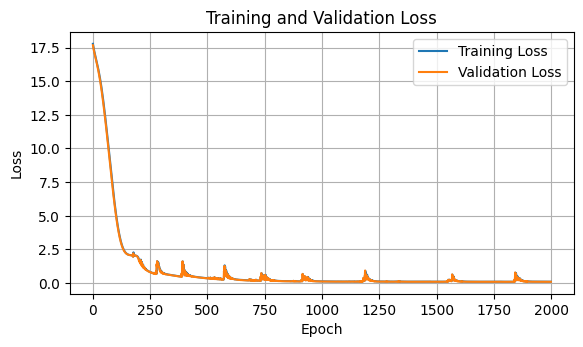

In [ ]:
plot_train_val_loss(train_loss, test_loss)

In [142]:
model.load_state_dict(best_model)
final_evaluation(model, test_edge_index, test_edge_weights, user_nodes, product_nodes, device)

Test loss: 0.1336


In [178]:
import torch.nn as nn
user_features=user_nodes
product_features=product_nodes
best_state=best_state

model.eval()
with torch.no_grad():
    test_predictions = model(test_edge_index, user_nodes, product_nodes)
    test_loss = nn.functional.mse_loss(test_predictions, test_edge_weights)
    metric_dict = {"Test loss": test_loss.item()}

if best_state is not None:
    temp_state = model.state_dict()
    model.load_state_dict(best_state)
    best_test_predictions = model(test_edge_index, user_nodes, product_nodes)
    best_test_loss = nn.functional.mse_loss(best_test_predictions, test_edge_weights)
    model.load_state_dict(temp_state)
    metric_dict["Best possible loss"] = best_test_loss.item()

In [180]:
import seaborn as sns

sns.kdeplot(test_predictions, color='blue', fill=True, label="Predicted")
sns.kdeplot(test_edge_weights, color="orange", fill=True, label="Actual")

# Add labels and title
plt.title("Density Plot of Predicted and Actual Ratings")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

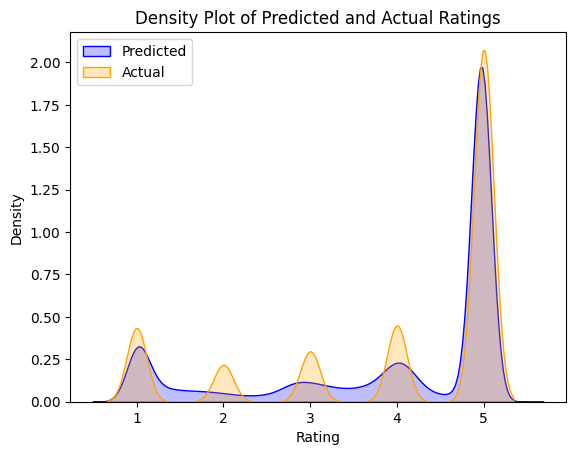

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Move the tensor to CPU and convert to NumPy array
test_predictions_np = test_predictions.cpu().numpy()
test_edge_weights_np = test_edge_weights.cpu().numpy()

sns.kdeplot(test_predictions_np, color='blue', fill=True, label="Predicted")
sns.kdeplot(test_edge_weights_np, color="orange", fill=True, label="Actual")

# Add labels and title
plt.title("Density Plot of Predicted and Actual Ratings")
plt.xlabel("Rating")
plt.ylabel("Density")
plt.legend()

# Show the plot
plt.show()

# Metrics

We have two kinds
1. Recall at 10
2. NDCG at 10

Recall is slow, 5 min  
NDCG is a work in progress so TBC

In [145]:
product_idx_tensor = torch.tensor(list(prod_id_to_idx.values()), dtype=torch.long, device = device)
test_edges_grp = test_user_edges.groupby("user_idx").prod_idx.apply(list).reset_index()
test_edges_users = test_edges_grp.user_idx.to_list()

In [146]:
predictions = get_top_k_preds(model, test_edges_users, 10, 32, user_nodes, product_nodes, product_idx_tensor, device) # about 5 min to run
test_edges_grp["prediction"] = list(torch.vstack(predictions).cpu().numpy())
test_edges_grp["match_count"] = test_edges_grp.apply(lambda x: len(set(x.prod_idx).intersection(set(x.prediction))), axis = 1)

In [147]:
# Overall recall
(test_edges_grp["match_count"] / test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

In [148]:
# Only those with prior history
existing_test_edges_grp = test_edges_grp[test_edges_grp.user_idx.isin(train_user_df.user_id.apply(lambda x: user_id_to_idx[x]))]
(existing_test_edges_grp["match_count"] / existing_test_edges_grp.prod_idx.apply(len)).mean()

np.float64(0.0)

# Show recomendations

This is just to sample and see what kind of results we get   
I am going to do three kinds of sampling
1. Pure random of the test set
2. Select test set that have some existance in the training set
3. Take the test set that dont have existance in the training set but use their user node information


But first we need to create a reverse mapping that does the offset
Also need to load up a df to map ids to titles

In [149]:
title_mapping = pd.read_parquet(f"{data_dir}/{product_dir}/product_df.parquet", columns = ["parent_asin", "title"])
prod_idx_to_id = {idx - offset: asin for asin, idx in prod_id_to_idx.items()}

In [150]:
# The pure random
user_id = test_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes,
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: 50 Pieces False Eyelash Packaging Box Empty Eyelash Box Plastic Eyelash Storage Case with Glitter Paper and Clear Tray for Women Girls Eyelash (Holographic)
Product 2: Stain Bonnet For Baby Bonnet Silk Sleep Cap For Toddler Child Shower Cap Teens Kids
Product 3: Precision Plunger Bars for Cartridge Grips – 93mm – Bag of 10 Plungers
Product 4: Lurrose 100Pcs Full Cover Fake Toenails Artificial Transparent Nail Tips Nail Art for DIY
Product 5: Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Biloba Leaf Extract, 5 fl. oz.
Product 6: Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)
Product 7: Eye Patch Black Adult with Tie Band (6 Per Pack)
Product 8: Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4D Imitation Eyebrow Tattoos, 4D Hair-like Authentic Eyebrows Waterproof Long Lasting for Woman & Man Makeup Tool
Product 9: Gold extatic Musk EDT 90ml
Product 10: 4 Pieces Satin Bonnet Adjustable Sleep Cap Double Layer 

In [151]:
# The user with some data
existing_test_users = test_user_df[test_user_df.user_id.isin(train_user_df.user_id)].copy()[["user_id"]]

In [152]:
user_id = existing_test_users.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes,
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: 50 Pieces False Eyelash Packaging Box Empty Eyelash Box Plastic Eyelash Storage Case with Glitter Paper and Clear Tray for Women Girls Eyelash (Holographic)
Product 2: Stain Bonnet For Baby Bonnet Silk Sleep Cap For Toddler Child Shower Cap Teens Kids
Product 3: Precision Plunger Bars for Cartridge Grips – 93mm – Bag of 10 Plungers
Product 4: Lurrose 100Pcs Full Cover Fake Toenails Artificial Transparent Nail Tips Nail Art for DIY
Product 5: Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Biloba Leaf Extract, 5 fl. oz.
Product 6: Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)
Product 7: Eye Patch Black Adult with Tie Band (6 Per Pack)
Product 8: Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4D Imitation Eyebrow Tattoos, 4D Hair-like Authentic Eyebrows Waterproof Long Lasting for Woman & Man Makeup Tool
Product 9: Gold extatic Musk EDT 90ml
Product 10: 4 Pieces Satin Bonnet Adjustable Sleep Cap Double Layer 

In [153]:
# The boosted way
# This is just to see if existing data (a bit of data leak) can help improve performance
boosted_additional_test_users = test_user_df[~test_user_df.user_id.isin(train_user_df.user_id)].copy()
boosted_user_df = pd.concat([train_user_df, boosted_additional_test_users])
boosted_user_embed = torch.tensor(np.vstack(boosted_user_df["embedding"].values))
boosted_user_info = torch.tensor(boosted_user_df.drop(["user_id", "embedding"], axis = 1).to_numpy())
boosted_user_nodes = torch.cat([boosted_user_embed, boosted_user_info], dim = 1)

In [154]:
user_id = boosted_user_df.user_id.sample(1).item()
recommended_products, predictions = recommend_products(model, user_id, user_id_to_idx, prod_id_to_idx, user_nodes, product_nodes,
                                                       prod_idx_to_id, top_k=10, device = device)
pretty_print_recomendations(recommended_products, title_mapping, "title")

Product 1: 50 Pieces False Eyelash Packaging Box Empty Eyelash Box Plastic Eyelash Storage Case with Glitter Paper and Clear Tray for Women Girls Eyelash (Holographic)
Product 2: Stain Bonnet For Baby Bonnet Silk Sleep Cap For Toddler Child Shower Cap Teens Kids
Product 3: Precision Plunger Bars for Cartridge Grips – 93mm – Bag of 10 Plungers
Product 4: Lurrose 100Pcs Full Cover Fake Toenails Artificial Transparent Nail Tips Nail Art for DIY
Product 5: Yes to Tomatoes Detoxifying Charcoal Cleanser (Pack of 2) with Charcoal Powder, Tomato Fruit Extract, and Gingko Biloba Leaf Extract, 5 fl. oz.
Product 6: Howard LC0008 Leather Conditioner, 8-Ounce (4-Pack)
Product 7: Eye Patch Black Adult with Tie Band (6 Per Pack)
Product 8: Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4D Imitation Eyebrow Tattoos, 4D Hair-like Authentic Eyebrows Waterproof Long Lasting for Woman & Man Makeup Tool
Product 9: Gold extatic Musk EDT 90ml
Product 10: 4 Pieces Satin Bonnet Adjustable Sleep Cap Double Layer 